
==== LEAVE OUT: user_1 ====
Number of train windows: 1584
Number of val windows:   809
Epoch 01/15 | Train Loss: 1.1287 | Train Acc: 59.28% | Val Loss: 1.8589 | Val Acc: 36.84%
Epoch 02/15 | Train Loss: 0.6378 | Train Acc: 79.29% | Val Loss: 2.0528 | Val Acc: 43.51%
Epoch 03/15 | Train Loss: 0.4283 | Train Acc: 86.43% | Val Loss: 2.3205 | Val Acc: 44.99%
Epoch 04/15 | Train Loss: 0.2899 | Train Acc: 91.10% | Val Loss: 2.5920 | Val Acc: 46.97%
Epoch 05/15 | Train Loss: 0.2105 | Train Acc: 93.37% | Val Loss: 3.0955 | Val Acc: 46.72%
Epoch 06/15 | Train Loss: 0.1733 | Train Acc: 94.57% | Val Loss: 3.0600 | Val Acc: 47.96%
Epoch 07/15 | Train Loss: 0.1621 | Train Acc: 94.70% | Val Loss: 3.2189 | Val Acc: 46.23%
Epoch 08/15 | Train Loss: 0.1211 | Train Acc: 96.15% | Val Loss: 3.4290 | Val Acc: 41.90%
Epoch 09/15 | Train Loss: 0.1341 | Train Acc: 95.45% | Val Loss: 3.2721 | Val Acc: 46.85%
Epoch 10/15 | Train Loss: 0.0894 | Train Acc: 96.78% | Val Loss: 3.0547 | Val Acc: 49.20%
Epoch 11/15 

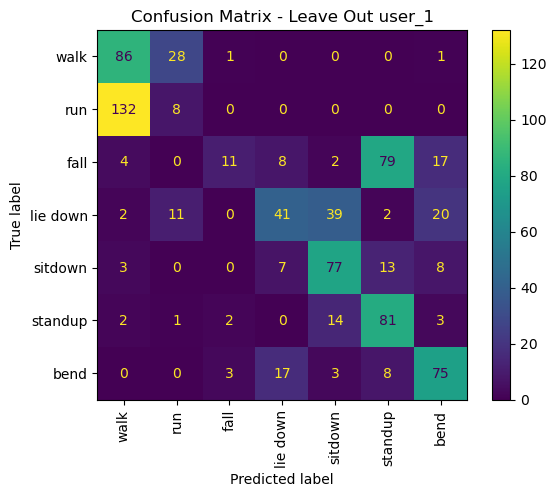

Training time: 12.4 seconds


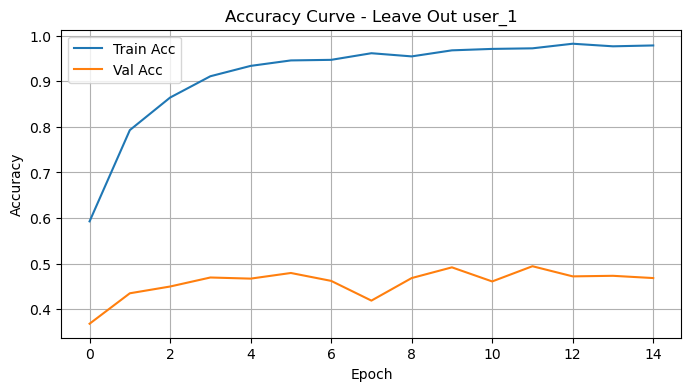

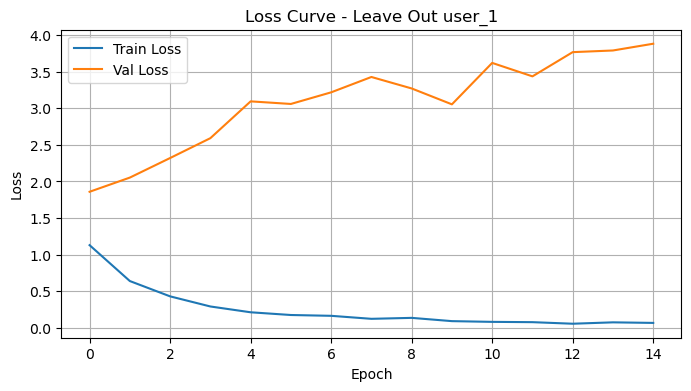


==== LEAVE OUT: user_2 ====
Number of train windows: 1571
Number of val windows:   822
Epoch 01/15 | Train Loss: 1.3239 | Train Acc: 46.59% | Val Loss: 1.1137 | Val Acc: 61.68%
Epoch 02/15 | Train Loss: 0.7940 | Train Acc: 67.03% | Val Loss: 1.0913 | Val Acc: 59.98%
Epoch 03/15 | Train Loss: 0.5459 | Train Acc: 77.78% | Val Loss: 1.4674 | Val Acc: 54.87%
Epoch 04/15 | Train Loss: 0.4410 | Train Acc: 82.50% | Val Loss: 1.5266 | Val Acc: 56.57%
Epoch 05/15 | Train Loss: 0.3108 | Train Acc: 89.24% | Val Loss: 1.5924 | Val Acc: 54.99%
Epoch 06/15 | Train Loss: 0.2547 | Train Acc: 91.34% | Val Loss: 1.7755 | Val Acc: 56.57%
Epoch 07/15 | Train Loss: 0.1618 | Train Acc: 95.16% | Val Loss: 2.4166 | Val Acc: 53.65%
Epoch 08/15 | Train Loss: 0.1522 | Train Acc: 94.53% | Val Loss: 1.9214 | Val Acc: 56.57%
Epoch 09/15 | Train Loss: 0.0939 | Train Acc: 97.01% | Val Loss: 2.3674 | Val Acc: 58.27%
Epoch 10/15 | Train Loss: 0.0859 | Train Acc: 97.45% | Val Loss: 2.2472 | Val Acc: 56.08%
Epoch 11/15 

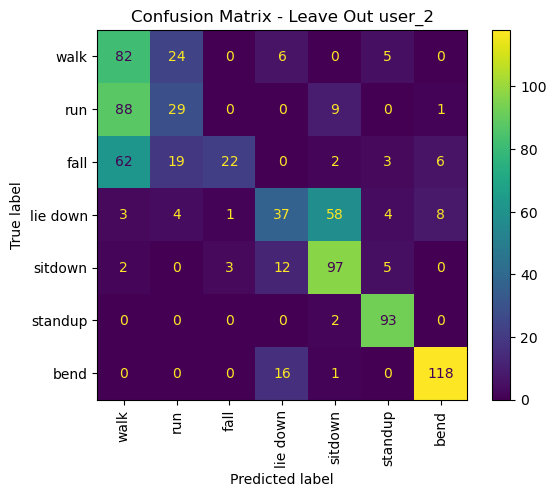

Training time: 13.4 seconds


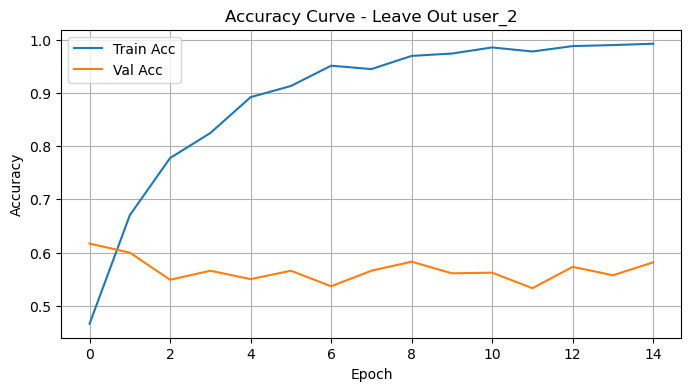

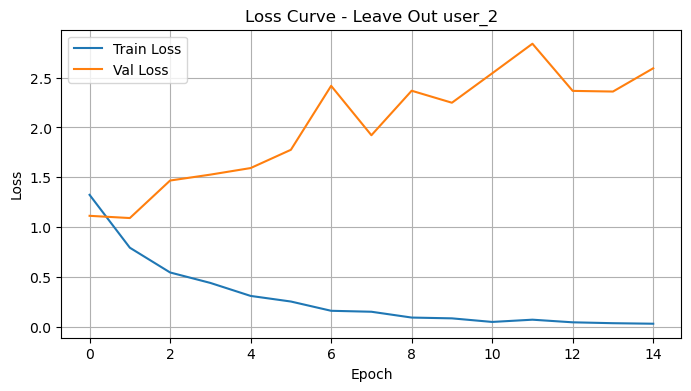


==== LEAVE OUT: user_3 ====
Number of train windows: 1631
Number of val windows:   762
Epoch 01/15 | Train Loss: 1.1488 | Train Acc: 56.10% | Val Loss: 2.0210 | Val Acc: 35.43%
Epoch 02/15 | Train Loss: 0.6456 | Train Acc: 75.11% | Val Loss: 2.3113 | Val Acc: 34.12%
Epoch 03/15 | Train Loss: 0.4850 | Train Acc: 80.32% | Val Loss: 2.1060 | Val Acc: 47.38%
Epoch 04/15 | Train Loss: 0.3744 | Train Acc: 85.78% | Val Loss: 2.3183 | Val Acc: 39.11%
Epoch 05/15 | Train Loss: 0.2984 | Train Acc: 88.90% | Val Loss: 2.6269 | Val Acc: 43.18%
Epoch 06/15 | Train Loss: 0.2300 | Train Acc: 91.85% | Val Loss: 2.4433 | Val Acc: 49.21%
Epoch 07/15 | Train Loss: 0.1516 | Train Acc: 95.16% | Val Loss: 2.6337 | Val Acc: 52.89%
Epoch 08/15 | Train Loss: 0.1057 | Train Acc: 97.12% | Val Loss: 2.6580 | Val Acc: 52.49%
Epoch 09/15 | Train Loss: 0.0766 | Train Acc: 98.22% | Val Loss: 2.6499 | Val Acc: 53.67%
Epoch 10/15 | Train Loss: 0.0781 | Train Acc: 97.36% | Val Loss: 3.3793 | Val Acc: 43.96%
Epoch 11/15 

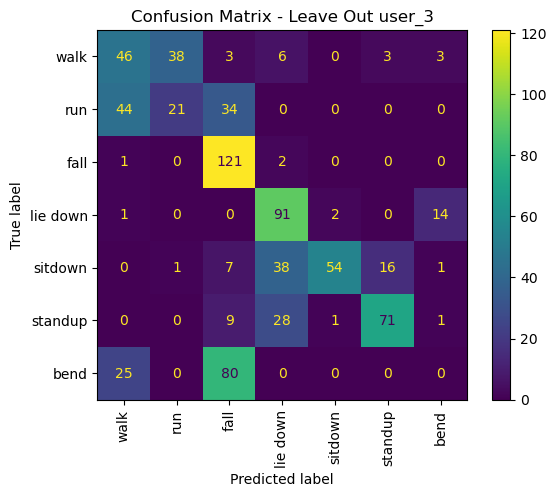

Training time: 13.8 seconds


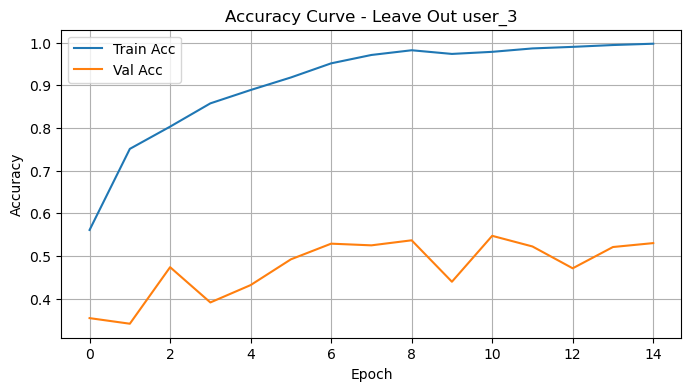

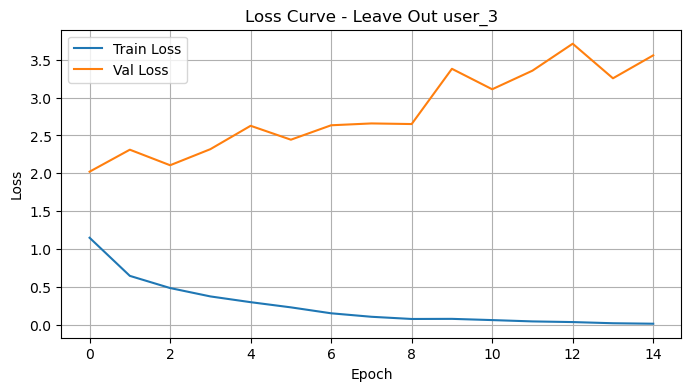

In [16]:
import os
import re
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import time
from sklearn.metrics import f1_score, recall_score, precision_score

DATASET_ROOT = r'F:/Datasets/CSI-HAR-Dataset-Raspberry-Pi-4/CSI-HAR-Dataset'  # update this!
ACTIVITIES = ['walk', 'run', 'fall', 'lie down', 'sitdown', 'standup', 'bend']
USERS = ['user_1', 'user_2', 'user_3']
# ========= CONFIGURATION =========


INPUT_DIM = 52
HIDDEN_DIM = 128
NUM_CLASSES = len(ACTIVITIES)
BATCH_SIZE = 32
EPOCHS = 15
LEARNING_RATE = 1e-4
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEED = 42
WINDOW_LEN = 400      # <-- Adjustable window size
STRIDE = 80          # <-- Adjustable stride (overlap)
np.random.seed(SEED)
torch.manual_seed(SEED)

# -------- DATA LOADING WITH WINDOWING --------

def load_windowed_data_by_user():
    """
    Returns: dict of user -> list of (windowed_array, label_index)
    Each windowed_array: (WINDOW_LEN, INPUT_DIM)
    """
    user_windows = {u: [] for u in USERS}
    for activity in ACTIVITIES:
        folder = os.path.join(DATASET_ROOT, activity)
        files = [f for f in os.listdir(folder) if f.endswith('.csv') and not f.startswith('Annotation')]
        for f in files:
            # match user in filename
            match = re.match(r'(user_\d)_sample_\d+_' + activity, f)
            if match:
                user = match.group(1)
                label = ACTIVITIES.index(activity)
                arr = pd.read_csv(os.path.join(folder, f), header=None)
                arr = arr.apply(pd.to_numeric, errors='coerce').values
                arr = arr[~np.isnan(arr).all(axis=1)]
                arr = arr[:, ~np.isnan(arr).all(axis=0)]
                if arr.shape[1] != INPUT_DIM:
                    continue # skip malformed file
                # windowing
                n_windows = (arr.shape[0] - WINDOW_LEN) // STRIDE + 1
                for w in range(n_windows):
                    start = w * STRIDE
                    end = start + WINDOW_LEN
                    if end > arr.shape[0]:
                        break  # don't create incomplete window
                    user_windows[user].append( (arr[start:end, :], label) )
    return user_windows

class CSIDataset(Dataset):
    def __init__(self, window_label_pairs, scaler=None, fit_scaler=False):
        # window_label_pairs: list of (arr, label_index)
        if len(window_label_pairs) == 0:
            self.data = np.empty((0, 0, 0))
            self.labels = []
            self.scaler = scaler
            print("[WARNING] Dataset is empty!")
            return
        self.labels = [l for _, l in window_label_pairs]
        stack = np.stack([arr for arr, _ in window_label_pairs])  # (N, W, C)
        N, W, C = stack.shape
        flat = stack.reshape(-1, C)
        if fit_scaler:
            self.scaler = StandardScaler().fit(flat)
        else:
            self.scaler = scaler
        self.data = self.scaler.transform(flat).reshape(N, W, C)
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32), self.labels[idx]


# ============== MODEL DEFINITION (BASELINE) ===============
class AttentionGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.attn_query = nn.Linear(hidden_dim, hidden_dim)
        self.attn_key   = nn.Linear(hidden_dim, hidden_dim)
        self.attn_value = nn.Linear(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, num_classes)
    def forward(self, x):
        # x: (B, T, C)
        gru_out, _ = self.gru(x)
        Q = self.attn_query(gru_out)
        K = self.attn_key(gru_out)
        V = self.attn_value(gru_out)
        attn_scores = torch.matmul(Q, K.transpose(1,2)) / (Q.size(-1) ** 0.5)
        attn_weights = torch.softmax(attn_scores, dim=-1)
        attn_out = torch.matmul(attn_weights, V)
        pooled = attn_out.mean(dim=1)
        logits = self.fc(pooled)
        return logits

# =========== LEAVE-ONE-USER-OUT CROSS-VALIDATION =============
results = []


user_samples = load_windowed_data_by_user()
for leave_out_user in USERS:
    print(f"\n==== LEAVE OUT: {leave_out_user} ====")
    # Split
    train_samples = []
    val_samples = []
    for u in USERS:
        if u == leave_out_user:
            val_samples += user_samples[u]
        else:
            train_samples += user_samples[u]
    # Prepare datasets (fit scaler only on train)
    scaler = StandardScaler()
    train_ds = CSIDataset(train_samples, scaler, fit_scaler=True)
    val_ds = CSIDataset(val_samples, train_ds.scaler, fit_scaler=False)


    if len(train_ds) == 0 or len(val_ds) == 0:
        print(f"[SKIP] No data for fold (train: {len(train_ds)}, val: {len(val_ds)}), skipping this user.")
        continue
            
    print(f"Number of train windows: {len(train_ds)}")
    print(f"Number of val windows:   {len(val_ds)}")
    
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
    
    model = AttentionGRU(INPUT_DIM, HIDDEN_DIM, NUM_CLASSES).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()
    
    train_accs, val_accs, train_losses, val_losses = [], [], [], []
    
    t0 = time.time()
    for epoch in range(1, EPOCHS+1):
        model.train()
        total_loss = 0
        y_true_train, y_pred_train = [], []
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * xb.size(0)
            # For train accuracy
            preds = out.argmax(dim=1).cpu().numpy()
            y_pred_train.extend(preds)
            y_true_train.extend(yb.cpu().numpy())
        train_loss = total_loss / len(train_ds)
        train_acc = np.mean(np.array(y_true_train) == np.array(y_pred_train))
    
        # Validation
        model.eval()
        y_true, y_pred = [], []
        total_val_loss = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(DEVICE)
                out = model(xb)
                loss = criterion(out, yb.to(DEVICE))
                total_val_loss += loss.item() * xb.size(0)
                pred = out.argmax(dim=1).cpu().numpy()
                y_pred.extend(pred)
                y_true.extend(yb)
        val_loss = total_val_loss / len(val_ds)
        val_acc = np.mean(np.array(y_true) == np.array(y_pred))
    
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
    
        print(f"Epoch {epoch:02d}/{EPOCHS} | "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}% | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")

 

    # Compute average F1, recall, precision for this fold
    f1 = f1_score(y_true, y_pred, average='macro')
    rec = recall_score(y_true, y_pred, average='macro')
    prec = precision_score(y_true, y_pred, average='macro')
    acc = np.mean(np.array(y_true) == np.array(y_pred))
        
    results.append({
        "user_left_out": leave_out_user,
        "accuracy": acc,
        "f1": f1,
        "recall": rec,
        "precision": prec,
        "train_time": elapsed
        # You can add more, e.g. confusion_matrix, best_epoch, etc.
    })



    
    elapsed = time.time() - t0
    
    # Final Eval (already in your code)
    print("\n--- Final Evaluation ---")
    print(classification_report(y_true, y_pred, target_names=ACTIVITIES, digits=3))
    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=ACTIVITIES).plot(xticks_rotation='vertical')
    plt.title(f'Confusion Matrix - Leave Out {leave_out_user}')
    plt.show()
    print(f"Training time: {elapsed:.1f} seconds")
    
    # Accuracy Curves
    plt.figure(figsize=(8, 4))
    plt.plot(train_accs, label='Train Acc')
    plt.plot(val_accs, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f"Accuracy Curve - Leave Out {leave_out_user}")
    plt.legend()
    plt.grid()
    plt.show()
    
    plt.figure(figsize=(8, 4))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f"Loss Curve - Leave Out {leave_out_user}")
    plt.legend()
    plt.grid()
    plt.show()


==== LEAVE-ONE-USER-OUT RESULTS SUMMARY ====


,accuracy,f1,recall,precision,train_time
user_left_out,,,,,
user_1,0.468480,0.433086,0.493267,0.481250,8.820017
user_2,0.581509,0.560379,0.587439,0.628784,12.437119
user_3,0.530184,0.475378,0.514594,0.501045,13.442338



==== MEAN METRICS OVER 3 FOLDS ====
accuracy       0.526724
f1             0.489614
recall         0.531767
precision      0.537026
train_time    11.566491
dtype: float64

==== MODEL ARCHITECTURE ====
AttentionGRU(
  (gru): GRU(52, 128, batch_first=True)
  (attn_query): Linear(in_features=128, out_features=128, bias=True)
  (attn_key): Linear(in_features=128, out_features=128, bias=True)
  (attn_value): Linear(in_features=128, out_features=128, bias=True)
  (fc): Linear(in_features=128, out_features=7, bias=True)
)

Total parameters: 120,327


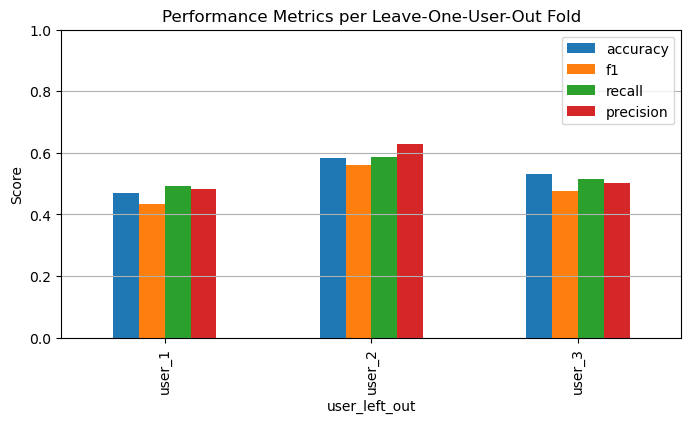

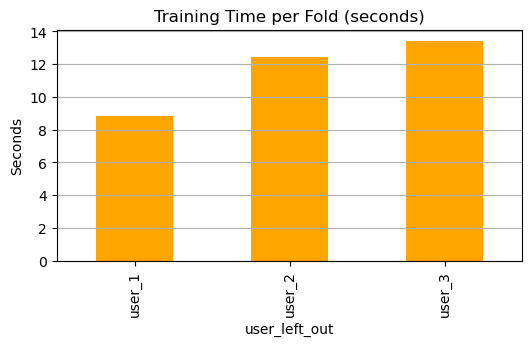

In [18]:
import pandas as pd

# Summarize results as DataFrame
df = pd.DataFrame(results)
df.index = df['user_left_out']
print("==== LEAVE-ONE-USER-OUT RESULTS SUMMARY ====")
display(df[['accuracy', 'f1', 'recall', 'precision', 'train_time']])

# Averages
print("\n==== MEAN METRICS OVER 3 FOLDS ====")
print(df[['accuracy', 'f1', 'recall', 'precision', 'train_time']].mean())

# Print model summary (assumes last model instance exists, adjust as needed)
print("\n==== MODEL ARCHITECTURE ====")
print(model)
n_params = sum(p.numel() for p in model.parameters())
print(f"\nTotal parameters: {n_params:,}")

# Plot comparison of metrics per fold
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
df[['accuracy', 'f1', 'recall', 'precision']].plot(kind='bar', ax=ax)
plt.title("Performance Metrics per Leave-One-User-Out Fold")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()

plt.figure(figsize=(6,3))
df['train_time'].plot(kind='bar', color='orange')
plt.title("Training Time per Fold (seconds)")
plt.ylabel("Seconds")
plt.grid(axis='y')
plt.show()


In [10]:
import os
# deterministic CUDA setup (if you want reproducibility); must come before torch import for cuBLAS
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

import re
import logging
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, recall_score, precision_score

# ====== CONFIGURATION ======
DATASET_ROOT = r'F:/Datasets/CSI-HAR-Dataset-Raspberry-Pi-4/CSI-HAR-Dataset'  # adjust if needed
ACTIVITIES = ['walk', 'run', 'fall', 'lie down', 'sitdown', 'standup', 'bend']
USERS = ['user_1', 'user_2', 'user_3']

TRAIN_USERS = ['user_1', 'user_3']
VAL_USER = 'user_2'

INPUT_DIM = 52
HIDDEN_DIM = 64
NUM_CLASSES = len(ACTIVITIES)
BATCH_SIZE = 64
EPOCHS = 150
PATIENCE = 10
LEARNING_RATE = 1e-4
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEED = 42
WINDOW_LEN = 400
STRIDE = 80

# reproducibility
np.random.seed(SEED)
torch.manual_seed(SEED)
try:
    torch.use_deterministic_algorithms(True)
except Exception:
    pass
torch.backends.cudnn.benchmark = False

# logging
logging.basicConfig(
    level=logging.INFO,
    format='[%(asctime)s] %(levelname)s: %(message)s',
    datefmt='%H:%M:%S'
)
logger = logging.getLogger(__name__)


# -------- DATA LOADING WITH PER-FILE NORMALIZATION & WINDOWING --------
def load_windowed_data_by_user():
    """
    Returns dict: user -> list of (windowed_array, label_index)
    Each CSV file is normalized (per-column standardization) before windowing.
    """
    user_windows = {u: [] for u in USERS}
    for activity in ACTIVITIES:
        folder = os.path.join(DATASET_ROOT, activity)
        if not os.path.isdir(folder):
            logger.warning(f"Missing activity folder: {folder} (skipping '{activity}')")
            continue
        # build regex for activity name (tolerant to spaces/underscores)
        parts = activity.strip().split()
        if len(parts) > 1:
            activity_regex = r'[_ ]+'.join(re.escape(p) for p in parts)
        else:
            activity_regex = re.escape(activity)
        pattern = rf'^(user_\d+)_sample_\d+_{activity_regex}.*\.csv$'
        files = [f for f in os.listdir(folder) if f.lower().endswith('.csv') and not f.lower().startswith('annotation')]
        for f in files:
            match = re.match(pattern, f, flags=re.IGNORECASE)
            if not match:
                continue
            user = match.group(1)
            if user not in USERS:
                continue
            label = ACTIVITIES.index(activity)
            full_path = os.path.join(folder, f)
            try:
                arr = pd.read_csv(full_path, header=None)
            except Exception as e:
                logger.warning(f"Failed to read '{full_path}': {e}")
                continue
            arr = arr.apply(pd.to_numeric, errors='coerce').values
            arr = arr[~np.isnan(arr).all(axis=1)]
            arr = arr[:, ~np.isnan(arr).all(axis=0)]
            if arr.shape[1] != INPUT_DIM:
                logger.debug(f"Skipping '{f}' due to unexpected dim {arr.shape}")
                continue
            if arr.shape[0] < WINDOW_LEN:
                continue  # too short for even one window

            # Per-file normalization: standardize each column
            mean = np.nanmean(arr, axis=0, keepdims=True)
            std = np.nanstd(arr, axis=0, keepdims=True)
            std[std < 1e-6] = 1.0  # avoid division by zero
            arr = (arr - mean) / std

            n_windows = (arr.shape[0] - WINDOW_LEN) // STRIDE + 1
            for w in range(n_windows):
                start = w * STRIDE
                end = start + WINDOW_LEN
                if end > arr.shape[0]:
                    break
                window = arr[start:end, :]
                user_windows[user].append((window, label))
    return user_windows


class CSIDataset(Dataset):
    def __init__(self, window_label_pairs):
        if len(window_label_pairs) == 0:
            self.data = np.empty((0, 0, 0))
            self.labels = []
            logger.warning("[WARNING] Empty dataset initialized")
            return
        self.labels = [l for _, l in window_label_pairs]
        stack = np.stack([arr for arr, _ in window_label_pairs])  # (N, W, C)
        self.data = stack  # already normalized per-file
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32), self.labels[idx]


# ============== MODEL ===============
class AttentionGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, dropout=0.1):
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.attn_query = nn.Linear(hidden_dim, hidden_dim)
        self.attn_key = nn.Linear(hidden_dim, hidden_dim)
        self.attn_value = nn.Linear(hidden_dim, hidden_dim)
        self.layer_norm = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, num_classes)
    def forward(self, x):
        gru_out, _ = self.gru(x)  # (B, T, H)
        Q = self.attn_query(gru_out)
        K = self.attn_key(gru_out)
        V = self.attn_value(gru_out)
        attn_scores = torch.matmul(Q, K.transpose(1, 2)) / (Q.size(-1) ** 0.5)
        attn_weights = torch.softmax(attn_scores, dim=-1)
        attn_out = torch.matmul(attn_weights, V)
        attn_out = self.layer_norm(attn_out + gru_out)
        attn_out = self.dropout(attn_out)
        pooled = attn_out.mean(dim=1)
        logits = self.fc(pooled)
        return logits


# Evaluation helper
def evaluate(model, loader, criterion):
    model.eval()
    y_true, y_pred = [], []
    total_loss = 0.0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            out = model(xb)
            loss = criterion(out, yb)
            total_loss += loss.item() * xb.size(0)
            preds = out.argmax(dim=1).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(yb.cpu().numpy())
    avg_loss = total_loss / len(loader.dataset) if len(loader.dataset) > 0 else float('inf')
    accuracy = (np.array(y_true) == np.array(y_pred)).mean() if len(y_true) > 0 else 0.0
    return avg_loss, accuracy, y_true, y_pred


def main():
# =========== LEAVE-ONE-USER-OUT CROSS-VALIDATION =============
    results = []
    
    
    user_samples = load_windowed_data_by_user()
    for leave_out_user in USERS:
        print(f"\n==== LEAVE OUT: {leave_out_user} ====")
        # Split
        train_samples = []
        val_samples = []
        for u in USERS:
            if u == leave_out_user:
                val_samples += user_samples[u]
            else:
                train_samples += user_samples[u]
        # Prepare datasets (fit scaler only on train)
        scaler = StandardScaler()
        train_ds = CSIDataset(train_samples, scaler, fit_scaler=True)
        val_ds = CSIDataset(val_samples, train_ds.scaler, fit_scaler=False)
    
    
        if len(train_ds) == 0 or len(val_ds) == 0:
            print(f"[SKIP] No data for fold (train: {len(train_ds)}, val: {len(val_ds)}), skipping this user.")
            continue
                
        print(f"Number of train windows: {len(train_ds)}")
        print(f"Number of val windows:   {len(val_ds)}")
        
        train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
        val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
        
        model = AttentionGRU(INPUT_DIM, HIDDEN_DIM, NUM_CLASSES).to(DEVICE)
        optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
        criterion = nn.CrossEntropyLoss()
        
        train_accs, val_accs, train_losses, val_losses = [], [], [], []
        
        t0 = time.time()
        for epoch in range(1, EPOCHS+1):
            model.train()
            total_loss = 0
            y_true_train, y_pred_train = [], []
            for xb, yb in train_loader:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                optimizer.zero_grad()
                out = model(xb)
                loss = criterion(out, yb)
                loss.backward()
                optimizer.step()
                total_loss += loss.item() * xb.size(0)
                # For train accuracy
                preds = out.argmax(dim=1).cpu().numpy()
                y_pred_train.extend(preds)
                y_true_train.extend(yb.cpu().numpy())
            train_loss = total_loss / len(train_ds)
            train_acc = np.mean(np.array(y_true_train) == np.array(y_pred_train))
        
            # Validation
            model.eval()
            y_true, y_pred = [], []
            total_val_loss = 0
            with torch.no_grad():
                for xb, yb in val_loader:
                    xb = xb.to(DEVICE)
                    out = model(xb)
                    loss = criterion(out, yb.to(DEVICE))
                    total_val_loss += loss.item() * xb.size(0)
                    pred = out.argmax(dim=1).cpu().numpy()
                    y_pred.extend(pred)
                    y_true.extend(yb)
            val_loss = total_val_loss / len(val_ds)
            val_acc = np.mean(np.array(y_true) == np.array(y_pred))
        
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accs.append(train_acc)
            val_accs.append(val_acc)
        
            print(f"Epoch {epoch:02d}/{EPOCHS} | "
                  f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}% | "
                  f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")
    
     
    
        # Compute average F1, recall, precision for this fold
        f1 = f1_score(y_true, y_pred, average='macro')
        rec = recall_score(y_true, y_pred, average='macro')
        prec = precision_score(y_true, y_pred, average='macro')
        acc = np.mean(np.array(y_true) == np.array(y_pred))
            
        results.append({
            "user_left_out": leave_out_user,
            "accuracy": acc,
            "f1": f1,
            "recall": rec,
            "precision": prec,
            "train_time": elapsed
            # You can add more, e.g. confusion_matrix, best_epoch, etc.
        })
    
    
    
        
        elapsed = time.time() - t0
        
        # Final Eval (already in your code)
        print("\n--- Final Evaluation ---")
        print(classification_report(y_true, y_pred, target_names=ACTIVITIES, digits=3))
        cm = confusion_matrix(y_true, y_pred)
        ConfusionMatrixDisplay(cm, display_labels=ACTIVITIES).plot(xticks_rotation='vertical')
        plt.title(f'Confusion Matrix - Leave Out {leave_out_user}')
        plt.show()
        print(f"Training time: {elapsed:.1f} seconds")
        
        # Accuracy Curves
        plt.figure(figsize=(8, 4))
        plt.plot(train_accs, label='Train Acc')
        plt.plot(val_accs, label='Val Acc')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title(f"Accuracy Curve - Leave Out {leave_out_user}")
        plt.legend()
        plt.grid()
        plt.show()
        
        plt.figure(figsize=(8, 4))
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Val Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f"Loss Curve - Leave Out {leave_out_user}")
        plt.legend()
        plt.grid()
        plt.show()
    
if __name__ == "__main__":
    main()



==== LEAVE OUT: user_1 ====


TypeError: CSIDataset.__init__() got an unexpected keyword argument 'fit_scaler'

In [ ]:
Expiment 2: scheduling LR, reducing hidden layer dimension, improving data loading

[14:55:50] INFO: Number of train windows: 1392
[14:55:50] INFO: Number of val windows:   732
[14:55:51] INFO: Epoch 01/150 | Train Loss: 1.9639 | Train Acc: 16.09% | Val Loss: 1.9204 | Val Acc: 19.54% | LR: 1.0e-04
[14:55:52] INFO: Epoch 02/150 | Train Loss: 1.9156 | Train Acc: 21.91% | Val Loss: 1.8902 | Val Acc: 23.91% | LR: 1.0e-04
[14:55:53] INFO: Epoch 03/150 | Train Loss: 1.8830 | Train Acc: 29.74% | Val Loss: 1.8678 | Val Acc: 27.87% | LR: 1.0e-04
[14:55:53] INFO: Epoch 04/150 | Train Loss: 1.8591 | Train Acc: 33.55% | Val Loss: 1.8478 | Val Acc: 31.69% | LR: 1.0e-04
[14:55:54] INFO: Epoch 05/150 | Train Loss: 1.8385 | Train Acc: 33.26% | Val Loss: 1.8302 | Val Acc: 31.83% | LR: 1.0e-04
[14:55:55] INFO: Epoch 06/150 | Train Loss: 1.8168 | Train Acc: 36.21% | Val Loss: 1.8096 | Val Acc: 34.84% | LR: 1.0e-04
[14:55:55] INFO: Epoch 07/150 | Train Loss: 1.7928 | Train Acc: 37.21% | Val Loss: 1.7843 | Val Acc: 35.93% | LR: 1.0e-04
[14:55:56] INFO: Epoch 08/150 | Train Loss: 1.7687 | 

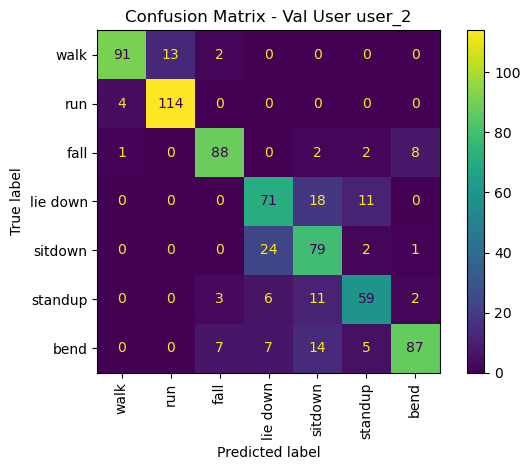

[14:57:34] INFO: Final metrics: accuracy=0.8046, f1=0.8018, recall=0.8007, precision=0.8078
[14:57:34] INFO: Training time: 103.2 seconds


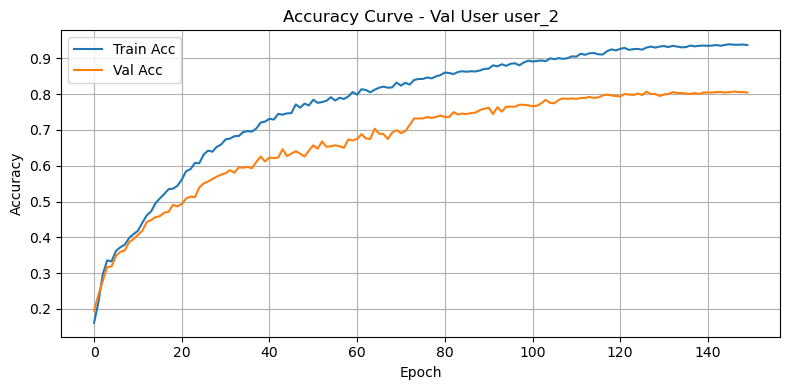

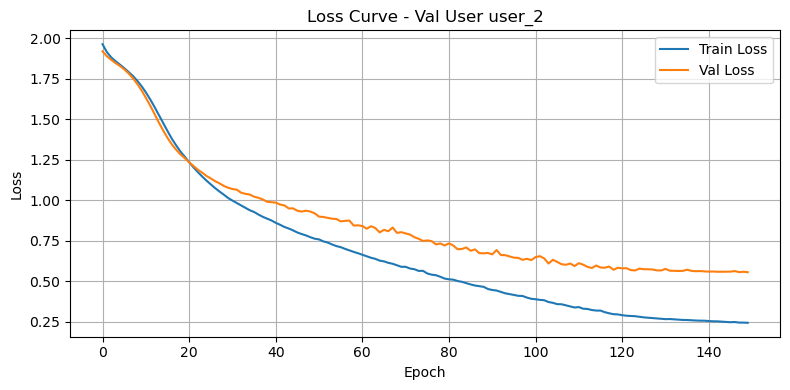

In [14]:
import os
# deterministic CUDA setup (if you want reproducibility); must come before torch import for cuBLAS
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

import re
import logging
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, recall_score, precision_score

# ====== CONFIGURATION ======
DATASET_ROOT = r'F:/Datasets/CSI-HAR-Dataset-Raspberry-Pi-4/CSI-HAR-Dataset'  # adjust if needed
ACTIVITIES = ['walk', 'run', 'fall', 'lie down', 'sitdown', 'standup', 'bend']
USERS = ['user_1', 'user_2', 'user_3']

TRAIN_USERS = ['user_1', 'user_3']
VAL_USER = 'user_2'

INPUT_DIM = 52
HIDDEN_DIM = 64
NUM_CLASSES = len(ACTIVITIES)
BATCH_SIZE = 64
EPOCHS = 150
PATIENCE = 10
LEARNING_RATE = 1e-4
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEED = 42
WINDOW_LEN = 450
STRIDE = 80

# reproducibility
np.random.seed(SEED)
torch.manual_seed(SEED)
try:
    torch.use_deterministic_algorithms(True)
except Exception:
    pass
torch.backends.cudnn.benchmark = False

# logging
logging.basicConfig(
    level=logging.INFO,
    format='[%(asctime)s] %(levelname)s: %(message)s',
    datefmt='%H:%M:%S'
)
logger = logging.getLogger(__name__)


# -------- DATA LOADING WITH PER-FILE NORMALIZATION & WINDOWING --------
def load_windowed_data_by_user():
    """
    Returns dict: user -> list of (windowed_array, label_index)
    Each CSV file is normalized (per-column standardization) before windowing.
    """
    user_windows = {u: [] for u in USERS}
    for activity in ACTIVITIES:
        folder = os.path.join(DATASET_ROOT, activity)
        if not os.path.isdir(folder):
            logger.warning(f"Missing activity folder: {folder} (skipping '{activity}')")
            continue
        # build regex for activity name (tolerant to spaces/underscores)
        parts = activity.strip().split()
        if len(parts) > 1:
            activity_regex = r'[_ ]+'.join(re.escape(p) for p in parts)
        else:
            activity_regex = re.escape(activity)
        pattern = rf'^(user_\d+)_sample_\d+_{activity_regex}.*\.csv$'
        files = [f for f in os.listdir(folder) if f.lower().endswith('.csv') and not f.lower().startswith('annotation')]
        for f in files:
            match = re.match(pattern, f, flags=re.IGNORECASE)
            if not match:
                continue
            user = match.group(1)
            if user not in USERS:
                continue
            label = ACTIVITIES.index(activity)
            full_path = os.path.join(folder, f)
            try:
                arr = pd.read_csv(full_path, header=None)
            except Exception as e:
                logger.warning(f"Failed to read '{full_path}': {e}")
                continue
            arr = arr.apply(pd.to_numeric, errors='coerce').values
            arr = arr[~np.isnan(arr).all(axis=1)]
            arr = arr[:, ~np.isnan(arr).all(axis=0)]
            if arr.shape[1] != INPUT_DIM:
                logger.debug(f"Skipping '{f}' due to unexpected dim {arr.shape}")
                continue
            if arr.shape[0] < WINDOW_LEN:
                continue  # too short for even one window

            # Per-file normalization: standardize each column
            mean = np.nanmean(arr, axis=0, keepdims=True)
            std = np.nanstd(arr, axis=0, keepdims=True)
            std[std < 1e-6] = 1.0  # avoid division by zero
            arr = (arr - mean) / std

            n_windows = (arr.shape[0] - WINDOW_LEN) // STRIDE + 1
            for w in range(n_windows):
                start = w * STRIDE
                end = start + WINDOW_LEN
                if end > arr.shape[0]:
                    break
                window = arr[start:end, :]
                user_windows[user].append((window, label))
    return user_windows


class CSIDataset(Dataset):
    def __init__(self, window_label_pairs):
        if len(window_label_pairs) == 0:
            self.data = np.empty((0, 0, 0))
            self.labels = []
            logger.warning("[WARNING] Empty dataset initialized")
            return
        self.labels = [l for _, l in window_label_pairs]
        stack = np.stack([arr for arr, _ in window_label_pairs])  # (N, W, C)
        self.data = stack  # already normalized per-file
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32), self.labels[idx]


# ============== MODEL ===============
class AttentionGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, dropout=0.3):
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.attn_query = nn.Linear(hidden_dim, hidden_dim)
        self.attn_key = nn.Linear(hidden_dim, hidden_dim)
        self.attn_value = nn.Linear(hidden_dim, hidden_dim)
        self.layer_norm = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, num_classes)
    def forward(self, x):
        gru_out, _ = self.gru(x)  # (B, T, H)
        Q = self.attn_query(gru_out)
        K = self.attn_key(gru_out)
        V = self.attn_value(gru_out)
        attn_scores = torch.matmul(Q, K.transpose(1, 2)) / (Q.size(-1) ** 0.5)
        attn_weights = torch.softmax(attn_scores, dim=-1)
        attn_out = torch.matmul(attn_weights, V)
        attn_out = self.layer_norm(attn_out + gru_out)
        attn_out = self.dropout(attn_out)
        pooled = attn_out.mean(dim=1)
        logits = self.fc(pooled)
        return logits


# Evaluation helper
def evaluate(model, loader, criterion):
    model.eval()
    y_true, y_pred = [], []
    total_loss = 0.0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            out = model(xb)
            loss = criterion(out, yb)
            total_loss += loss.item() * xb.size(0)
            preds = out.argmax(dim=1).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(yb.cpu().numpy())
    avg_loss = total_loss / len(loader.dataset) if len(loader.dataset) > 0 else float('inf')
    accuracy = (np.array(y_true) == np.array(y_pred)).mean() if len(y_true) > 0 else 0.0
    return avg_loss, accuracy, y_true, y_pred


def main():
    user_samples = load_windowed_data_by_user()

    # Build train/val sets: train = user_1 & user_3; val = user_2
    train_samples = []
    for u in TRAIN_USERS:
        train_samples += user_samples.get(u, [])
    val_samples = user_samples.get(VAL_USER, [])

    train_ds = CSIDataset(train_samples)
    val_ds = CSIDataset(val_samples)
    if len(train_ds) == 0 or len(val_ds) == 0:
        logger.error(f"Empty train or val set (train: {len(train_ds)}, val: {len(val_ds)}), aborting.")
        return

    logger.info(f"Number of train windows: {len(train_ds)}")
    logger.info(f"Number of val windows:   {len(val_ds)}")

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

    model = AttentionGRU(INPUT_DIM, HIDDEN_DIM, NUM_CLASSES).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3
    )
    criterion = nn.CrossEntropyLoss()

    train_accs, val_accs, train_losses, val_losses = [], [], [], []
    best_val_loss = float('inf')
    best_epoch = 0
    patience_counter = 0
    best_model_state = None

    t0 = time.time()
    for epoch in range(1, EPOCHS + 1):
        model.train()
        epoch_loss = 0.0
        y_true_train, y_pred_train = [], []
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            epoch_loss += loss.item() * xb.size(0)
            preds = out.argmax(dim=1).cpu().numpy()
            y_pred_train.extend(preds)
            y_true_train.extend(yb.cpu().numpy())
        train_loss = epoch_loss / len(train_ds)
        train_acc = (np.array(y_true_train) == np.array(y_pred_train)).mean()

        val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]['lr']

        logger.info(f"Epoch {epoch:02d}/{EPOCHS} | "
                    f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}% | "
                    f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}% | LR: {current_lr:.1e}")

        if val_loss < best_val_loss - 1e-5:
            best_val_loss = val_loss
            best_epoch = epoch
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                logger.info(f"Early stopping triggered at epoch {epoch}.")
                break

    elapsed = time.time() - t0
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    # Final evaluation
    val_loss, val_acc, y_true, y_pred = evaluate(model, val_loader, criterion)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_true, y_pred, average='macro', zero_division=0)
    prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
    acc = val_acc

    logger.info("\n--- Final Evaluation ---")
    logger.info(f"Best epoch: {best_epoch} (best val loss: {best_val_loss:.4f})")
    logger.info(classification_report(y_true, y_pred, target_names=ACTIVITIES, digits=3))
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=ACTIVITIES)
    disp.plot(xticks_rotation='vertical')
    plt.title(f'Confusion Matrix - Val User {VAL_USER}')
    plt.tight_layout()
    plt.show()

    logger.info(f"Final metrics: accuracy={acc:.4f}, f1={f1:.4f}, recall={rec:.4f}, precision={prec:.4f}")
    logger.info(f"Training time: {elapsed:.1f} seconds")

    # Curves
    plt.figure(figsize=(8, 4))
    plt.plot(train_accs, label='Train Acc')
    plt.plot(val_accs, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f"Accuracy Curve - Val User {VAL_USER}")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 4))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f"Loss Curve - Val User {VAL_USER}")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

    return {
        "results": [{
            "user_left_out": VAL_USER,
            "accuracy": acc,
            "f1": f1,
            "recall": rec,
            "precision": prec,
            "train_time": elapsed,
            "best_epoch": best_epoch
        }],
        "model": model,
        "best_epoch": best_epoch,
        "metrics": {"accuracy": acc, "f1": f1, "recall": rec, "precision": prec},
        "y_true": y_true,
        "y_pred": y_pred
    }


if __name__ == "__main__":
    summary = main()


==== LEAVE-ONE-USER-OUT RESULTS SUMMARY ====


,accuracy,f1,recall,precision,train_time
user_left_out,,,,,
user_2,0.768856,0.765606,0.764248,0.771678,107.847765



==== MEAN METRICS ====
accuracy        0.768856
f1              0.765606
recall          0.764248
precision       0.771678
train_time    107.847765
dtype: float64

==== MODEL ARCHITECTURE ====
AttentionGRU(
  (gru): GRU(52, 64, batch_first=True)
  (attn_query): Linear(in_features=64, out_features=64, bias=True)
  (attn_key): Linear(in_features=64, out_features=64, bias=True)
  (attn_value): Linear(in_features=64, out_features=64, bias=True)
  (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=64, out_features=7, bias=True)
)

Total parameters: 35,719


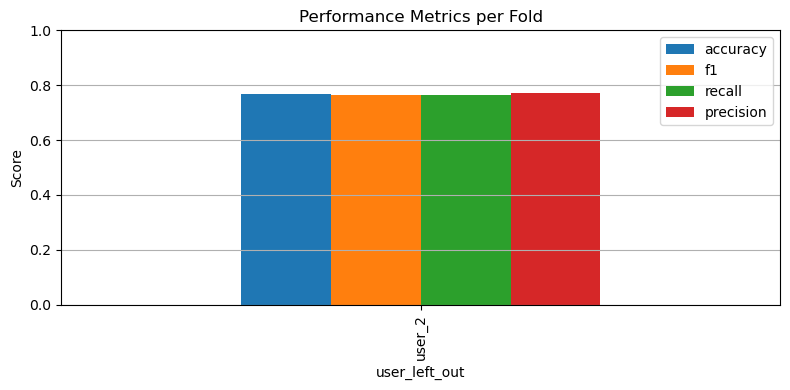

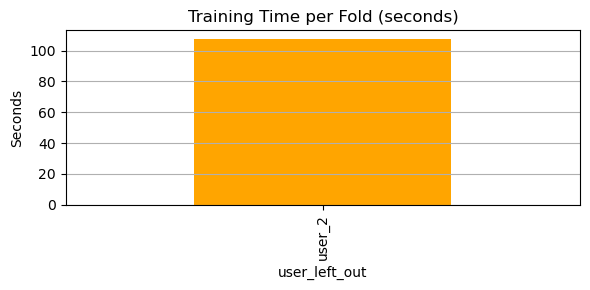

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure we have `summary`; if not, rerun main to get it.
try:
    summary
except NameError:
    summary = main()  # this will re-run training if needed

# Extract and organize
results = summary["results"]
df = pd.DataFrame(results).set_index("user_left_out")

print("==== LEAVE-ONE-USER-OUT RESULTS SUMMARY ====")
display(df[['accuracy', 'f1', 'recall', 'precision', 'train_time']])

print("\n==== MEAN METRICS ====")
print(df[['accuracy', 'f1', 'recall', 'precision', 'train_time']].mean())

print("\n==== MODEL ARCHITECTURE ====")
model = summary["model"]
print(model)
n_params = sum(p.numel() for p in model.parameters())
print(f"\nTotal parameters: {n_params:,}")

# Performance metrics per fold
fig, ax = plt.subplots(figsize=(8, 4))
df[['accuracy', 'f1', 'recall', 'precision']].plot(kind='bar', ax=ax)
ax.set_title("Performance Metrics per Fold")
ax.set_ylabel("Score")
ax.set_ylim(0, 1)
ax.grid(axis='y')
plt.tight_layout()
plt.show()

# Training time
plt.figure(figsize=(6, 3))
df['train_time'].plot(kind='bar', color='orange')
plt.title("Training Time per Fold (seconds)")
plt.ylabel("Seconds")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


==== LEAVE-ONE-USER-OUT RESULTS SUMMARY ====


,accuracy,f1,recall,precision,train_time
user_left_out,,,,,
user_2,0.742092,0.735896,0.733985,0.745169,58.145809



==== MEAN METRICS ====
accuracy       0.742092
f1             0.735896
recall         0.733985
precision      0.745169
train_time    58.145809
dtype: float64

==== MODEL ARCHITECTURE ====
AttentionGRU(
  (gru): GRU(52, 64, batch_first=True)
  (attn_query): Linear(in_features=64, out_features=64, bias=True)
  (attn_key): Linear(in_features=64, out_features=64, bias=True)
  (attn_value): Linear(in_features=64, out_features=64, bias=True)
  (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=64, out_features=7, bias=True)
)

Total parameters: 35,719

'y_true' and/or 'y_pred' not in scope; skipping detailed per-class report.


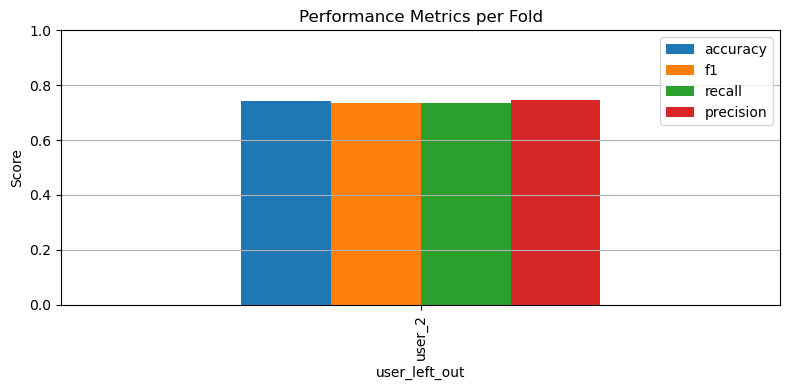

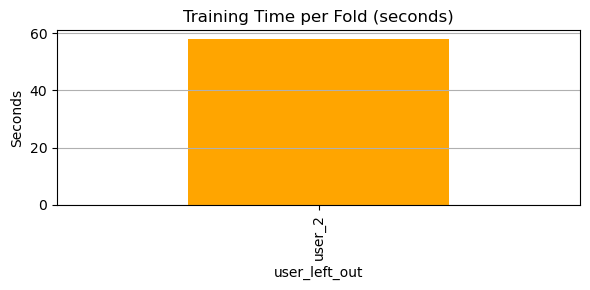

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Build or recover results
try:
    results  # existing from prior run
except NameError:
    # assemble from expected single-fold variables
    try:
        results = [{
            "user_left_out": VAL_USER,
            "accuracy": acc,
            "f1": f1,
            "recall": rec,
            "precision": prec,
            "train_time": elapsed,
            "best_epoch": best_epoch
        }]
    except NameError as e:
        raise RuntimeError(f"Cannot build summary: missing variable {e}. Ensure acc, f1, rec, prec, elapsed, best_epoch, and VAL_USER are in scope.")

# DataFrame summary
df = pd.DataFrame(results).set_index("user_left_out")

print("==== LEAVE-ONE-USER-OUT RESULTS SUMMARY ====")
display(df[['accuracy', 'f1', 'recall', 'precision', 'train_time']])

print("\n==== MEAN METRICS ====")
print(df[['accuracy', 'f1', 'recall', 'precision', 'train_time']].mean())

# Model architecture & parameter count
print("\n==== MODEL ARCHITECTURE ====")
try:
    print(model)
    n_params = sum(p.numel() for p in model.parameters())
    print(f"\nTotal parameters: {n_params:,}")
except NameError:
    print("Model object 'model' not found in scope.")

# Classification report and confusion matrix if predictions are available
if 'y_true' in globals() and 'y_pred' in globals():
    print("\n==== CLASSIFICATION REPORT ====")
    print(classification_report(y_true, y_pred, target_names=ACTIVITIES, digits=3))
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=ACTIVITIES)
    disp.plot(xticks_rotation='vertical')
    plt.title(f'Confusion Matrix - Val User {VAL_USER}')
    plt.tight_layout()
    plt.show()
else:
    print("\n'y_true' and/or 'y_pred' not in scope; skipping detailed per-class report.")

# Performance metrics per fold
fig, ax = plt.subplots(figsize=(8, 4))
df[['accuracy', 'f1', 'recall', 'precision']].plot(kind='bar', ax=ax)
ax.set_title("Performance Metrics per Fold")
ax.set_ylabel("Score")
ax.set_ylim(0, 1)
ax.grid(axis='y')
plt.tight_layout()
plt.show()

# Training time bar
plt.figure(figsize=(6, 3))
df['train_time'].plot(kind='bar', color='orange')
plt.title("Training Time per Fold (seconds)")
plt.ylabel("Seconds")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


C:\Users\Adrian\anaconda3\envs\myenv\lib\site-packages\torch\nn\modules\rnn.py:1392: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\RNN.cpp:1410.)
  result = _VF.gru(


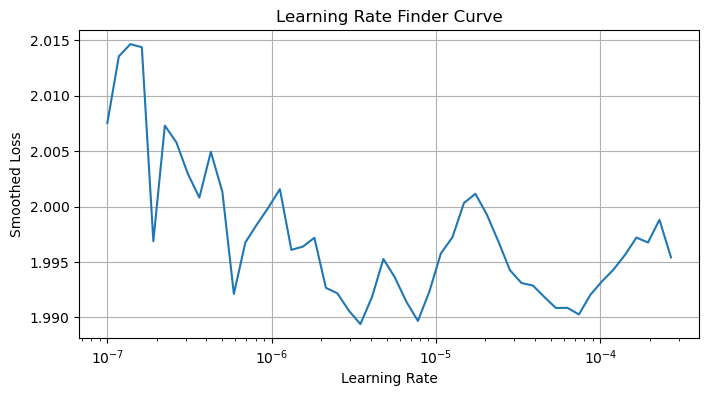

Best learning rate (minimum loss): 3.47e-06


In [34]:
import copy

def lr_finder(model, train_loader, criterion, optimizer, device, 
              start_lr=1e-7, end_lr=1, num_iters=1400, beta=0.98):
    model = copy.deepcopy(model)  # Don't affect original weights
    lrs = []
    losses = []
    avg_loss = 0.
    best_loss = float('inf')
    lr_mult = (end_lr / start_lr) ** (1/num_iters)
    optimizer.param_groups[0]['lr'] = start_lr
    iter_count = 0

    for xb, yb in train_loader:
        if iter_count >= num_iters:
            break
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        # Compute the smoothed loss to avoid sharp jumps
        avg_loss = beta * avg_loss + (1-beta) * loss.item()
        smoothed_loss = avg_loss / (1 - beta**(iter_count+1))
        lrs.append(optimizer.param_groups[0]['lr'])
        losses.append(smoothed_loss)

        if smoothed_loss < best_loss or iter_count == 0:
            best_loss = smoothed_loss

        # Stop if the loss explodes (10x the best loss seen so far)
        if smoothed_loss > 10 * best_loss:
            break

        loss.backward()
        optimizer.step()

        # Increase LR for next batch
        optimizer.param_groups[0]['lr'] *= lr_mult
        iter_count += 1

    return lrs, losses

# ---- Usage Example ----
# 1. Re-initialize your model, optimizer, criterion
# 2. Use only a subset of your train_loader if your dataset is large (set num_iters accordingly)
# 3. Plot results and pick the best LR visually

# Example:
model = AttentionGRU(INPUT_DIM, HIDDEN_DIM, NUM_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-7)
criterion = nn.CrossEntropyLoss()

lrs, losses = lr_finder(model, train_loader, criterion, optimizer, DEVICE, 
                       start_lr=1e-7, end_lr=1, num_iters=100)

import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.plot(lrs, losses)
plt.xscale('log')
plt.xlabel("Learning Rate")
plt.ylabel("Smoothed Loss")
plt.title("Learning Rate Finder Curve")
plt.grid()
plt.show()

# Find and print LR where loss decreases fastest before rising
min_loss_idx = np.argmin(losses)
best_lr = lrs[min_loss_idx]
print(f"Best learning rate (minimum loss): {best_lr:.2e}")


In [ ]:
Experiment 3: Adding CNN

[01:28:43] INFO: Number of train windows: 1571
[01:28:43] INFO: Number of val windows:   822
[01:28:45] INFO: Epoch 01/150 | Train Loss: 1.8640 | Train Acc: 28.20% | Val Loss: 1.8192 | Val Acc: 33.45% | LR: 1.0e-04
[01:28:47] INFO: Epoch 02/150 | Train Loss: 1.6775 | Train Acc: 41.44% | Val Loss: 1.6445 | Val Acc: 39.66% | LR: 1.0e-04
[01:28:50] INFO: Epoch 03/150 | Train Loss: 1.5285 | Train Acc: 51.37% | Val Loss: 1.5047 | Val Acc: 47.57% | LR: 1.0e-04
[01:28:52] INFO: Epoch 04/150 | Train Loss: 1.3952 | Train Acc: 57.29% | Val Loss: 1.3897 | Val Acc: 54.38% | LR: 1.0e-04
[01:28:54] INFO: Epoch 05/150 | Train Loss: 1.2747 | Train Acc: 62.25% | Val Loss: 1.2845 | Val Acc: 56.57% | LR: 1.0e-04
[01:28:56] INFO: Epoch 06/150 | Train Loss: 1.1744 | Train Acc: 63.72% | Val Loss: 1.1948 | Val Acc: 60.46% | LR: 1.0e-04
[01:28:58] INFO: Epoch 07/150 | Train Loss: 1.0865 | Train Acc: 72.88% | Val Loss: 1.1320 | Val Acc: 61.92% | LR: 1.0e-04
[01:29:01] INFO: Epoch 08/150 | Train Loss: 1.0174 | 

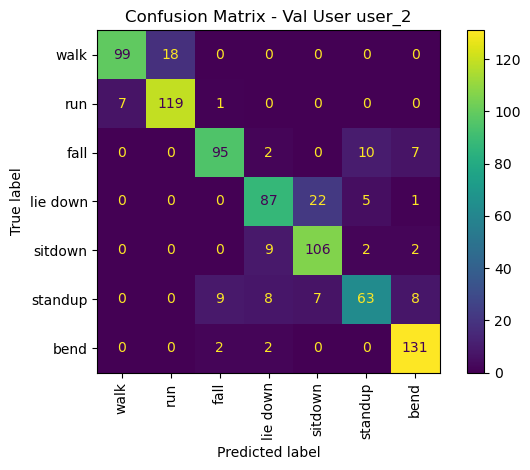

[01:31:02] INFO: Final metrics: accuracy=0.8516, f1=0.8438, recall=0.8425, precision=0.8497
[01:31:02] INFO: Training time: 138.8 seconds


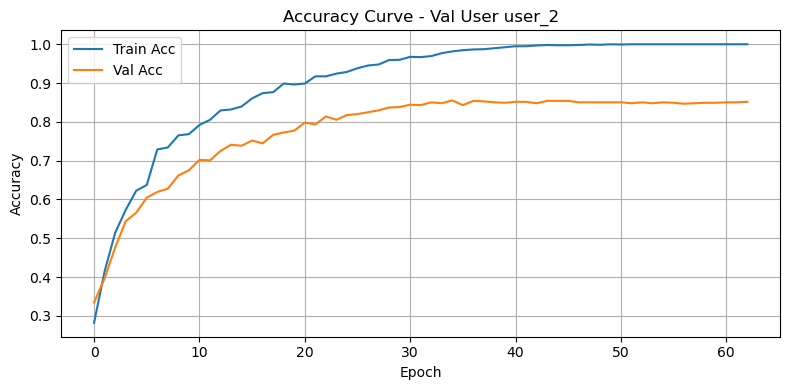

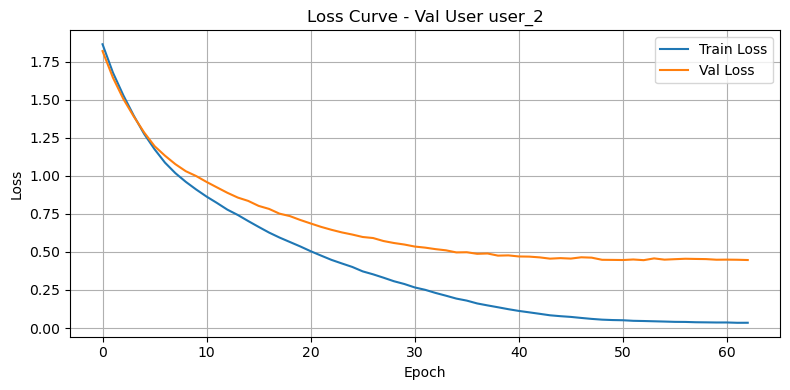

In [7]:
import os
# deterministic CUDA setup (if you want reproducibility); must come before torch import for cuBLAS
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

import re
import logging
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, recall_score, precision_score

# ====== CONFIGURATION ======
DATASET_ROOT = r'F:/Datasets/CSI-HAR-Dataset-Raspberry-Pi-4/CSI-HAR-Dataset'  # adjust if needed
ACTIVITIES = ['walk', 'run', 'fall', 'lie down', 'sitdown', 'standup', 'bend']
USERS = ['user_1', 'user_2', 'user_3']

TRAIN_USERS = ['user_1', 'user_3']
VAL_USER = 'user_2'

INPUT_DIM = 52
HIDDEN_DIM = 64
NUM_CLASSES = len(ACTIVITIES)
BATCH_SIZE = 64
EPOCHS = 150
PATIENCE = 10
LEARNING_RATE = 1e-4
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEED = 42
WINDOW_LEN = 400
STRIDE = 80

# reproducibility
np.random.seed(SEED)
torch.manual_seed(SEED)
try:
    torch.use_deterministic_algorithms(True)
except Exception:
    pass
torch.backends.cudnn.benchmark = False

# logging
logging.basicConfig(
    level=logging.INFO,
    format='[%(asctime)s] %(levelname)s: %(message)s',
    datefmt='%H:%M:%S'
)
logger = logging.getLogger(__name__)


# -------- DATA LOADING WITH PER-FILE NORMALIZATION & WINDOWING --------
def load_windowed_data_by_user():
    """
    Returns dict: user -> list of (windowed_array, label_index)
    Each CSV file is normalized (per-column standardization) before windowing.
    """
    user_windows = {u: [] for u in USERS}
    for activity in ACTIVITIES:
        folder = os.path.join(DATASET_ROOT, activity)
        if not os.path.isdir(folder):
            logger.warning(f"Missing activity folder: {folder} (skipping '{activity}')")
            continue
        # build regex for activity name (tolerant to spaces/underscores)
        parts = activity.strip().split()
        if len(parts) > 1:
            activity_regex = r'[_ ]+'.join(re.escape(p) for p in parts)
        else:
            activity_regex = re.escape(activity)
        pattern = rf'^(user_\d+)_sample_\d+_{activity_regex}.*\.csv$'
        files = [f for f in os.listdir(folder) if f.lower().endswith('.csv') and not f.lower().startswith('annotation')]
        for f in files:
            match = re.match(pattern, f, flags=re.IGNORECASE)
            if not match:
                continue
            user = match.group(1)
            if user not in USERS:
                continue
            label = ACTIVITIES.index(activity)
            full_path = os.path.join(folder, f)
            try:
                arr = pd.read_csv(full_path, header=None)
            except Exception as e:
                logger.warning(f"Failed to read '{full_path}': {e}")
                continue
            arr = arr.apply(pd.to_numeric, errors='coerce').values
            arr = arr[~np.isnan(arr).all(axis=1)]
            arr = arr[:, ~np.isnan(arr).all(axis=0)]
            if arr.shape[1] != INPUT_DIM:
                logger.debug(f"Skipping '{f}' due to unexpected dim {arr.shape}")
                continue
            if arr.shape[0] < WINDOW_LEN:
                continue  # too short for even one window

            # Per-file normalization: standardize each column
            mean = np.nanmean(arr, axis=0, keepdims=True)
            std = np.nanstd(arr, axis=0, keepdims=True)
            std[std < 1e-6] = 1.0  # avoid division by zero
            arr = (arr - mean) / std

            n_windows = (arr.shape[0] - WINDOW_LEN) // STRIDE + 1
            for w in range(n_windows):
                start = w * STRIDE
                end = start + WINDOW_LEN
                if end > arr.shape[0]:
                    break
                window = arr[start:end, :]
                user_windows[user].append((window, label))
    return user_windows


class CSIDataset(Dataset):
    def __init__(self, window_label_pairs):
        if len(window_label_pairs) == 0:
            self.data = np.empty((0, 0, 0))
            self.labels = []
            logger.warning("[WARNING] Empty dataset initialized")
            return
        self.labels = [l for _, l in window_label_pairs]
        stack = np.stack([arr for arr, _ in window_label_pairs])  # (N, W, C)
        self.data = stack  # already normalized per-file
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32), self.labels[idx]


# ============== MODEL ===============
class CNNAttentionGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, cnn_channels=32, dropout=0.3):
        super().__init__()
        # CNN front-end: operate over (time, subcarrier) as a 2D “image”
        self.cnn = nn.Sequential(
            nn.Conv2d(1, cnn_channels, kernel_size=(3, 5), padding=(1, 2)),  # preserves T and C
            nn.ReLU(),
            nn.BatchNorm2d(cnn_channels),
            nn.MaxPool2d((1, 2))  # downsample subcarrier dimension by 2
        )
        # After conv+pool: shape (B, cnn_channels, T, input_dim//2)
        self.gru_input_dim = cnn_channels * (input_dim // 2)
        self.gru = nn.GRU(self.gru_input_dim, hidden_dim, batch_first=True)
        # attention layers (same as before)
        self.attn_query = nn.Linear(hidden_dim, hidden_dim)
        self.attn_key = nn.Linear(hidden_dim, hidden_dim)
        self.attn_value = nn.Linear(hidden_dim, hidden_dim)
        self.layer_norm = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        # x: (B, T, C) where C = original input_dim (subcarriers)
        B, T, C = x.shape
        x = x.unsqueeze(1)  # (B,1,T,C) so we can conv2d over time×subcarrier
        x = self.cnn(x)     # (B, F, T, C_new) where C_new = C//2
        B, F, T_new, C_new = x.shape
        # collapse feature maps into a sequence for GRU: (B, T_new, F * C_new)
        x = x.permute(0, 2, 1, 3).reshape(B, T_new, F * C_new)
        gru_out, _ = self.gru(x)  # (B, T_new, H)
        Q = self.attn_query(gru_out)
        K = self.attn_key(gru_out)
        V = self.attn_value(gru_out)
        attn_scores = torch.matmul(Q, K.transpose(1, 2)) / (Q.size(-1) ** 0.5)
        attn_weights = torch.softmax(attn_scores, dim=-1)
        attn_out = torch.matmul(attn_weights, V)  # (B, T_new, H)
        attn_out = self.layer_norm(attn_out + gru_out)
        attn_out = self.dropout(attn_out)
        pooled = attn_out.mean(dim=1)  # (B, H)
        logits = self.fc(pooled)
        return logits

# Evaluation helper
def evaluate(model, loader, criterion):
    model.eval()
    y_true, y_pred = [], []
    total_loss = 0.0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            out = model(xb)
            loss = criterion(out, yb)
            total_loss += loss.item() * xb.size(0)
            preds = out.argmax(dim=1).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(yb.cpu().numpy())
    avg_loss = total_loss / len(loader.dataset) if len(loader.dataset) > 0 else float('inf')
    accuracy = (np.array(y_true) == np.array(y_pred)).mean() if len(y_true) > 0 else 0.0
    return avg_loss, accuracy, y_true, y_pred


def main():
    user_samples = load_windowed_data_by_user()

    # Build train/val sets: train = user_1 & user_3; val = user_2
    train_samples = []
    for u in TRAIN_USERS:
        train_samples += user_samples.get(u, [])
    val_samples = user_samples.get(VAL_USER, [])

    train_ds = CSIDataset(train_samples)
    val_ds = CSIDataset(val_samples)
    if len(train_ds) == 0 or len(val_ds) == 0:
        logger.error(f"Empty train or val set (train: {len(train_ds)}, val: {len(val_ds)}), aborting.")
        return

    logger.info(f"Number of train windows: {len(train_ds)}")
    logger.info(f"Number of val windows:   {len(val_ds)}")

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

    model = CNNAttentionGRU(INPUT_DIM, HIDDEN_DIM, NUM_CLASSES).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3
    )
    criterion = nn.CrossEntropyLoss()

    train_accs, val_accs, train_losses, val_losses = [], [], [], []
    best_val_loss = float('inf')
    best_epoch = 0
    patience_counter = 0
    best_model_state = None

    t0 = time.time()
    for epoch in range(1, EPOCHS + 1):
        model.train()
        epoch_loss = 0.0
        y_true_train, y_pred_train = [], []
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            epoch_loss += loss.item() * xb.size(0)
            preds = out.argmax(dim=1).cpu().numpy()
            y_pred_train.extend(preds)
            y_true_train.extend(yb.cpu().numpy())
        train_loss = epoch_loss / len(train_ds)
        train_acc = (np.array(y_true_train) == np.array(y_pred_train)).mean()

        val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]['lr']

        logger.info(f"Epoch {epoch:02d}/{EPOCHS} | "
                    f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}% | "
                    f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}% | LR: {current_lr:.1e}")

        if val_loss < best_val_loss - 1e-5:
            best_val_loss = val_loss
            best_epoch = epoch
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                logger.info(f"Early stopping triggered at epoch {epoch}.")
                break

    elapsed = time.time() - t0
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    # Final evaluation
    val_loss, val_acc, y_true, y_pred = evaluate(model, val_loader, criterion)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_true, y_pred, average='macro', zero_division=0)
    prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
    acc = val_acc

    logger.info("\n--- Final Evaluation ---")
    logger.info(f"Best epoch: {best_epoch} (best val loss: {best_val_loss:.4f})")
    logger.info(classification_report(y_true, y_pred, target_names=ACTIVITIES, digits=3))
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=ACTIVITIES)
    disp.plot(xticks_rotation='vertical')
    plt.title(f'Confusion Matrix - Val User {VAL_USER}')
    plt.tight_layout()
    plt.show()

    logger.info(f"Final metrics: accuracy={acc:.4f}, f1={f1:.4f}, recall={rec:.4f}, precision={prec:.4f}")
    logger.info(f"Training time: {elapsed:.1f} seconds")

    # Curves
    plt.figure(figsize=(8, 4))
    plt.plot(train_accs, label='Train Acc')
    plt.plot(val_accs, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f"Accuracy Curve - Val User {VAL_USER}")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 4))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f"Loss Curve - Val User {VAL_USER}")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

    return {
        "results": [{
            "user_left_out": VAL_USER,
            "accuracy": acc,
            "f1": f1,
            "recall": rec,
            "precision": prec,
            "train_time": elapsed,
            "best_epoch": best_epoch
        }],
        "model": model,
        "best_epoch": best_epoch,
        "metrics": {"accuracy": acc, "f1": f1, "recall": rec, "precision": prec},
        "y_true": y_true,
        "y_pred": y_pred
    }


if __name__ == "__main__":
    summary = main()


==== LEAVE-ONE-USER-OUT RESULTS SUMMARY ====


,accuracy,f1,recall,precision,train_time,best_epoch
user_left_out,,,,,,
user_2,0.851582,0.843798,0.842472,0.849694,138.825023,53



==== MEAN METRICS ====
      accuracy        f1    recall  precision  train_time
mean  0.851582  0.843798  0.842472   0.849694  138.825023

==== MEAN ± STD ====
      accuracy        f1    recall  precision
mean  0.851582  0.843798  0.842472   0.849694
std        NaN       NaN       NaN        NaN

==== MODEL ARCHITECTURE ====
CNNAttentionGRU(
  (cnn): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 5), stride=(1, 1), padding=(1, 2))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (gru): GRU(832, 64, batch_first=True)
  (attn_query): Linear(in_features=64, out_features=64, bias=True)
  (attn_key): Linear(in_features=64, out_features=64, bias=True)
  (attn_value): Linear(in_features=64, out_features=64, bias=True)
  (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (f

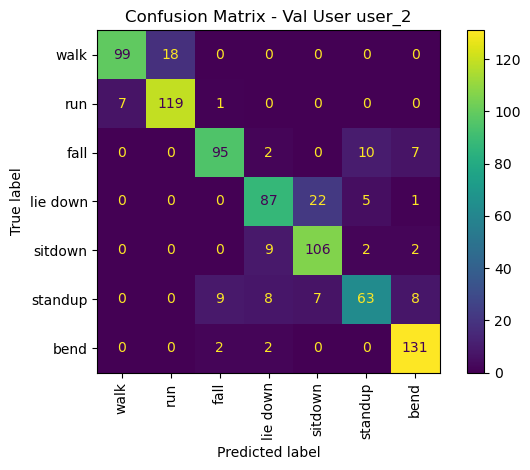

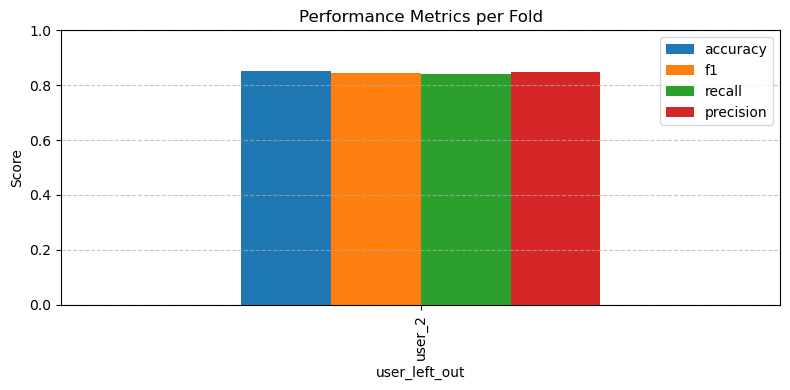

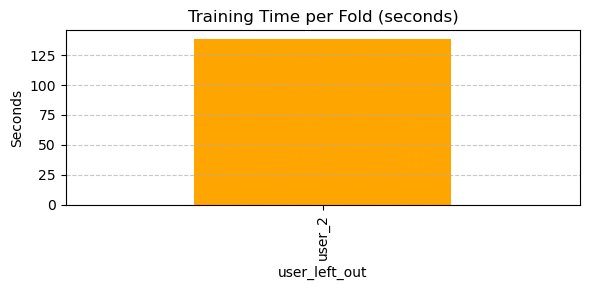

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# --- extract results ---
if 'summary' in globals() and isinstance(summary, dict):
    results = summary.get("results", [])
else:
    # fallback to legacy variables if summary not present
    try:
        results = [{
            "user_left_out": VAL_USER,
            "accuracy": acc,
            "f1": f1,
            "recall": rec,
            "precision": prec,
            "train_time": elapsed,
            "best_epoch": best_epoch
        }]
    except NameError as e:
        raise RuntimeError(f"Cannot build summary: missing variable {e}. Ensure summary or required metrics are in scope.")

# Build DataFrame
df = pd.DataFrame(results)
if "user_left_out" in df.columns:
    df.set_index("user_left_out", inplace=True)

# --- Summary tables ---
print("==== LEAVE-ONE-USER-OUT RESULTS SUMMARY ====")
display(df[['accuracy', 'f1', 'recall', 'precision', 'train_time', 'best_epoch']])

print("\n==== MEAN METRICS ====")
mean_metrics = df[['accuracy', 'f1', 'recall', 'precision', 'train_time']].mean()
print(mean_metrics.to_frame(name="mean").T)

print("\n==== MEAN ± STD ====")
agg = df[['accuracy', 'f1', 'recall', 'precision']].agg(['mean', 'std'])
print(agg)

# --- Model architecture & size ---
print("\n==== MODEL ARCHITECTURE ====")
model_obj = None
if 'summary' in globals():
    model_obj = summary.get('model', None)
if model_obj is None:
    model_obj = globals().get('model', None)
if model_obj is not None:
    print(model_obj)
    try:
        n_params = sum(p.numel() for p in model_obj.parameters())
        print(f"\nTotal parameters: {n_params:,}")
    except Exception:
        pass
else:
    print("Model object not found in scope.")

# --- Classification report & confusion matrix ---
# Prefer summary's y_true/y_pred then globals
y_true = None; y_pred = None
if 'summary' in globals():
    y_true = summary.get("y_true", None)
    y_pred = summary.get("y_pred", None)
if y_true is None or y_pred is None:
    y_true = globals().get('y_true', y_true)
    y_pred = globals().get('y_pred', y_pred)

if y_true is not None and y_pred is not None:
    print("\n==== CLASSIFICATION REPORT ====")
    print(classification_report(y_true, y_pred, target_names=ACTIVITIES, digits=3, zero_division=0))
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=ACTIVITIES)
    disp.plot(xticks_rotation='vertical')
    plt.title(f'Confusion Matrix - Val User {VAL_USER}')
    plt.tight_layout()
    plt.show()
else:
    print("\nNo prediction targets available; skipping classification report/confusion matrix.")

# --- Plots ---
fig, ax = plt.subplots(figsize=(8, 4))
df[['accuracy', 'f1', 'recall', 'precision']].plot(kind='bar', ax=ax)
ax.set_title("Performance Metrics per Fold")
ax.set_ylabel("Score")
ax.set_ylim(0, 1)
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 3))
if 'train_time' in df.columns:
    df['train_time'].plot(kind='bar', color='orange')
    plt.title("Training Time per Fold (seconds)")
    plt.ylabel("Seconds")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("\nNo 'train_time' column to plot.")


In [ ]:
Experiment 4: PCA/ with/without whitening

[21:30:17] INFO: Per-file PCA: mean retained variance over files: 0.9754 ± 0.0253
[21:30:17] INFO:   Activity 'walk': mean retained variance: 0.9911 ± 0.0041
[21:30:17] INFO:   Activity 'run': mean retained variance: 0.9901 ± 0.0058
[21:30:17] INFO:   Activity 'fall': mean retained variance: 0.9455 ± 0.0335
[21:30:17] INFO:   Activity 'lie down': mean retained variance: 0.9816 ± 0.0138
[21:30:17] INFO:   Activity 'sitdown': mean retained variance: 0.9800 ± 0.0097
[21:30:17] INFO:   Activity 'standup': mean retained variance: 0.9581 ± 0.0351
[21:30:17] INFO:   Activity 'bend': mean retained variance: 0.9816 ± 0.0061
[21:30:17] INFO: Number of train windows: 1571
[21:30:17] INFO: Number of val windows:   822
[21:30:18] INFO: Epoch 01/150 | Train Loss: 1.9264 | Train Acc: 16.04% | Val Loss: 1.9202 | Val Acc: 19.71% | LR: 1.0e-04
[21:30:19] INFO: Epoch 02/150 | Train Loss: 1.8760 | Train Acc: 27.69% | Val Loss: 1.8891 | Val Acc: 30.66% | LR: 1.0e-04
[21:30:19] INFO: Epoch 03/150 | Train Lo

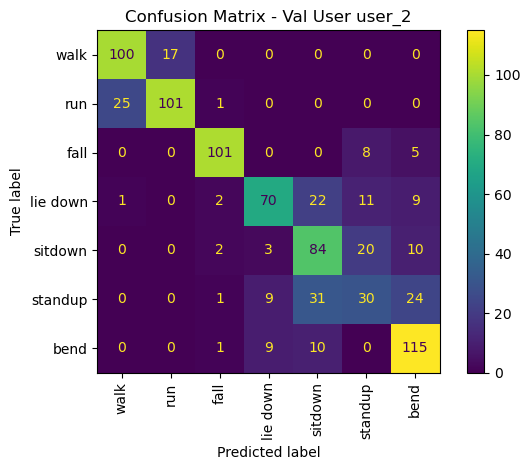

[21:31:46] INFO: Final metrics: accuracy=0.7311, f1=0.7152, recall=0.7169, precision=0.7237
[21:31:46] INFO: Training time: 88.0 seconds


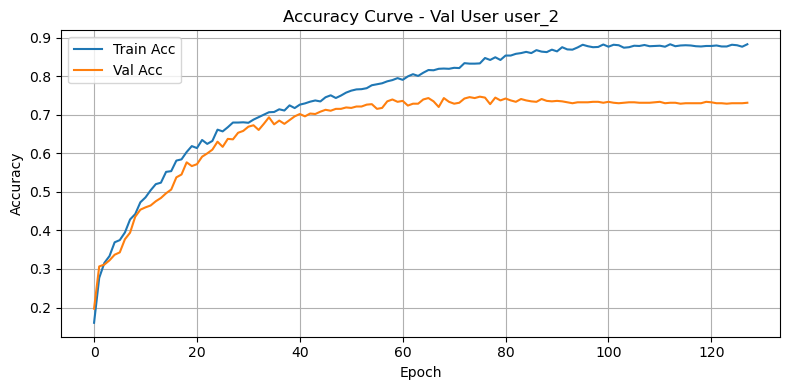

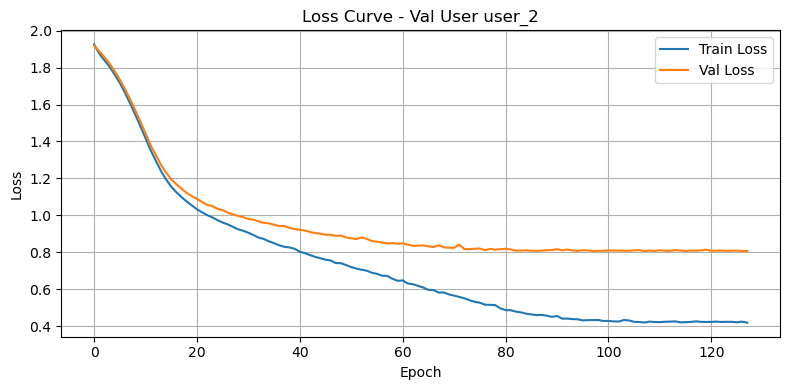

In [23]:
import os
# deterministic CUDA setup (if you want reproducibility); must come before torch import for cuBLAS
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

import re
import logging
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, recall_score, precision_score

# ====== CONFIGURATION ======
DATASET_ROOT = r'F:/Datasets/CSI-HAR-Dataset-Raspberry-Pi-4/CSI-HAR-Dataset'  # adjust if needed
ACTIVITIES = ['walk', 'run', 'fall', 'lie down', 'sitdown', 'standup', 'bend']
USERS = ['user_1', 'user_2', 'user_3']

TRAIN_USERS = ['user_1', 'user_3']
VAL_USER = 'user_2'

INPUT_DIM = 52
HIDDEN_DIM = 64
NUM_CLASSES = len(ACTIVITIES)
BATCH_SIZE = 64
EPOCHS = 150
PATIENCE = 20
LEARNING_RATE = 1e-4
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEED = 42
WINDOW_LEN = 400
STRIDE = 80

# reproducibility
np.random.seed(SEED)
torch.manual_seed(SEED)
try:
    torch.use_deterministic_algorithms(True)
except Exception:
    pass
torch.backends.cudnn.benchmark = False

# logging
logging.basicConfig(
    level=logging.INFO,
    format='[%(asctime)s] %(levelname)s: %(message)s',
    datefmt='%H:%M:%S'
)
logger = logging.getLogger(__name__)


# -------- DATA LOADING WITH PER-FILE NORMALIZATION & WINDOWING --------
from sklearn.decomposition import PCA  # add this import near top

# ---- PCA-per-file config ----
USE_PCA_PER_FILE = True          # toggle per-file PCA
PCA_COMPONENTS = 10             # target reduced subcarrier dimension per file
PCA_WHITEN = False              # whether to whiten (usually False for HAR)

# Modified loader to support per-file PCA
def load_windowed_data_by_user(return_pca_stats=False):
    """
    Returns: dict of user -> list of (windowed_array, label_index)
    Applies per-file normalization and, optionally, PCA per file before windowing.
    If return_pca_stats=True, also returns a dict with PCA explained variance info.
    """
    user_windows = {u: [] for u in USERS}
    cum_explained_variances = []  # per-file total variance retained by PCA_COMPONENTS
    per_activity_variances = {act: [] for act in ACTIVITIES}

    for activity in ACTIVITIES:
        folder = os.path.join(DATASET_ROOT, activity)
        if not os.path.isdir(folder):
            logger.warning(f"Missing activity folder: {folder} (skipping '{activity}')")
            continue
        parts = activity.strip().split()
        if len(parts) > 1:
            activity_regex = r'[_ ]+'.join(re.escape(p) for p in parts)
        else:
            activity_regex = re.escape(activity)
        pattern = rf'^(user_\d+)_sample_\d+_{activity_regex}.*\.csv$'
        files = [f for f in os.listdir(folder) if f.lower().endswith('.csv') and not f.lower().startswith('annotation')]
        for f in files:
            match = re.match(pattern, f, flags=re.IGNORECASE)
            if not match:
                continue
            user = match.group(1)
            if user not in USERS:
                continue
            label = ACTIVITIES.index(activity)
            full_path = os.path.join(folder, f)
            try:
                arr = pd.read_csv(full_path, header=None)
            except Exception as e:
                logger.warning(f"Failed to read '{full_path}': {e}")
                continue
            arr = arr.apply(pd.to_numeric, errors='coerce').values
            arr = arr[~np.isnan(arr).all(axis=1)]
            arr = arr[:, ~np.isnan(arr).all(axis=0)]
            if arr.shape[1] != INPUT_DIM:
                logger.debug(f"Skipping '{f}' due to unexpected dim {arr.shape}")
                continue
            if arr.shape[0] < WINDOW_LEN:
                continue  # too short for even one window

            # Per-file normalization: standardize each column
            mean = np.nanmean(arr, axis=0, keepdims=True)
            std = np.nanstd(arr, axis=0, keepdims=True)
            std[std < 1e-6] = 1.0
            arr = (arr - mean) / std  # shape (T, C)

            # Per-file PCA (if enabled)
            if USE_PCA_PER_FILE and PCA_COMPONENTS is not None and PCA_COMPONENTS < INPUT_DIM:
                pca = PCA(n_components=PCA_COMPONENTS, whiten=PCA_WHITEN, random_state=SEED)
                arr_pca = pca.fit_transform(arr)  # (T, k)
                # record explained variance retention
                cum_var = np.sum(pca.explained_variance_ratio_)  # how much variance retained
                cum_explained_variances.append(cum_var)
                per_activity_variances[activity].append(cum_var)
                arr = arr_pca  # replace with reduced representation
                current_input_dim = PCA_COMPONENTS
            else:
                current_input_dim = INPUT_DIM  # no PCA or identity

            # Windowing on the (possibly PCA-reduced) arr
            n_windows = (arr.shape[0] - WINDOW_LEN) // STRIDE + 1
            for w in range(n_windows):
                start = w * STRIDE
                end = start + WINDOW_LEN
                if end > arr.shape[0]:
                    break
                window = arr[start:end, :]  # shape (WINDOW_LEN, current_input_dim)
                user_windows[user].append((window, label))

    stats = None
    if return_pca_stats:
        # aggregate stats
        stats = {
            "cum_explained_variances": cum_explained_variances,  # list of floats per file that had PCA
            "per_activity": {act: np.array(per_activity_variances[act]) for act in ACTIVITIES}
        }
    if return_pca_stats:
        return user_windows, stats
    else:
        return user_windows

class CSIDataset(Dataset):
    def __init__(self, window_label_pairs):
        if len(window_label_pairs) == 0:
            self.data = np.empty((0, 0, 0))
            self.labels = []
            logger.warning("[WARNING] Empty dataset initialized")
            return
        self.labels = [l for _, l in window_label_pairs]
        stack = np.stack([arr for arr, _ in window_label_pairs])  # (N, W, C)
        self.data = stack  # already normalized per-file
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32), self.labels[idx]


# ============== MODEL ===============
class CNNAttentionGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, cnn_channels=10, dropout=0.3):
        super().__init__()
        # CNN front-end: operate over (time, subcarrier) as a 2D “image”
        self.cnn = nn.Sequential(
            nn.Conv2d(1, cnn_channels, kernel_size=(3, 5), padding=(1, 2)),  # preserves T and C
            nn.ReLU(),
            nn.BatchNorm2d(cnn_channels),
            nn.MaxPool2d((1, 2))  # downsample subcarrier dimension by 2
        )
        # After conv+pool: shape (B, cnn_channels, T, input_dim//2)
        self.gru_input_dim = cnn_channels * (input_dim // 2)
        self.gru = nn.GRU(self.gru_input_dim, hidden_dim, batch_first=True)
        # attention layers (same as before)
        self.attn_query = nn.Linear(hidden_dim, hidden_dim)
        self.attn_key = nn.Linear(hidden_dim, hidden_dim)
        self.attn_value = nn.Linear(hidden_dim, hidden_dim)
        self.layer_norm = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        # x: (B, T, C) where C = original input_dim (subcarriers)
        B, T, C = x.shape
        x = x.unsqueeze(1)  # (B,1,T,C) so we can conv2d over time×subcarrier
        x = self.cnn(x)     # (B, F, T, C_new) where C_new = C//2
        B, F, T_new, C_new = x.shape
        # collapse feature maps into a sequence for GRU: (B, T_new, F * C_new)
        x = x.permute(0, 2, 1, 3).reshape(B, T_new, F * C_new)
        gru_out, _ = self.gru(x)  # (B, T_new, H)
        Q = self.attn_query(gru_out)
        K = self.attn_key(gru_out)
        V = self.attn_value(gru_out)
        attn_scores = torch.matmul(Q, K.transpose(1, 2)) / (Q.size(-1) ** 0.5)
        attn_weights = torch.softmax(attn_scores, dim=-1)
        attn_out = torch.matmul(attn_weights, V)  # (B, T_new, H)
        attn_out = self.layer_norm(attn_out + gru_out)
        attn_out = self.dropout(attn_out)
        pooled = attn_out.mean(dim=1)  # (B, H)
        logits = self.fc(pooled)
        return logits

# Evaluation helper
def evaluate(model, loader, criterion):
    model.eval()
    y_true, y_pred = [], []
    total_loss = 0.0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            out = model(xb)
            loss = criterion(out, yb)
            total_loss += loss.item() * xb.size(0)
            preds = out.argmax(dim=1).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(yb.cpu().numpy())
    avg_loss = total_loss / len(loader.dataset) if len(loader.dataset) > 0 else float('inf')
    accuracy = (np.array(y_true) == np.array(y_pred)).mean() if len(y_true) > 0 else 0.0
    return avg_loss, accuracy, y_true, y_pred

def main():
    # Load with per-file PCA stats
    user_samples, pca_info = load_windowed_data_by_user(return_pca_stats=True)

    # Determine input dim after per-file PCA and log variance retention
    if USE_PCA_PER_FILE and PCA_COMPONENTS is not None and PCA_COMPONENTS < INPUT_DIM:
        all_vals = np.array(pca_info["cum_explained_variances"])
        logger.info(f"Per-file PCA: mean retained variance over files: {all_vals.mean():.4f} ± {all_vals.std():.4f}")
        for act in ACTIVITIES:
            arr = pca_info["per_activity"].get(act, np.array([]))
            if arr.size > 0:
                logger.info(f"  Activity '{act}': mean retained variance: {arr.mean():.4f} ± {arr.std():.4f}")
        input_dim_for_model = PCA_COMPONENTS
    else:
        input_dim_for_model = INPUT_DIM

    # Build train/val sets: train = TRAIN_USERS; val = VAL_USER
    train_samples = []
    for u in TRAIN_USERS:
        train_samples += user_samples.get(u, [])
    val_samples = user_samples.get(VAL_USER, [])

    train_ds = CSIDataset(train_samples)
    val_ds = CSIDataset(val_samples)
    if len(train_ds) == 0 or len(val_ds) == 0:
        logger.error(f"Empty train or val set (train: {len(train_ds)}, val: {len(val_ds)}), aborting.")
        return

    logger.info(f"Number of train windows: {len(train_ds)}")
    logger.info(f"Number of val windows:   {len(val_ds)}")

    # DataLoaders (was missing, causing the NameError)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

    # Model instantiation using adjusted input dim
    model = CNNAttentionGRU(input_dim_for_model, HIDDEN_DIM, NUM_CLASSES).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3
    )
    criterion = nn.CrossEntropyLoss()

    train_accs, val_accs, train_losses, val_losses = [], [], [], []
    best_val_loss = float('inf')
    best_epoch = 0
    patience_counter = 0
    best_model_state = None

    t0 = time.time()
    for epoch in range(1, EPOCHS + 1):
        model.train()
        epoch_loss = 0.0
        y_true_train, y_pred_train = [], []
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            epoch_loss += loss.item() * xb.size(0)
            preds = out.argmax(dim=1).cpu().numpy()
            y_pred_train.extend(preds)
            y_true_train.extend(yb.cpu().numpy())
        train_loss = epoch_loss / len(train_ds)
        train_acc = (np.array(y_true_train) == np.array(y_pred_train)).mean()

        val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]['lr']

        logger.info(f"Epoch {epoch:02d}/{EPOCHS} | "
                    f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}% | "
                    f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}% | LR: {current_lr:.1e}")

        if val_loss < best_val_loss - 1e-5:
            best_val_loss = val_loss
            best_epoch = epoch
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                logger.info(f"Early stopping triggered at epoch {epoch}.")
                break

    elapsed = time.time() - t0
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    # Final evaluation
    val_loss, val_acc, y_true, y_pred = evaluate(model, val_loader, criterion)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_true, y_pred, average='macro', zero_division=0)
    prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
    acc = val_acc

    logger.info("\n--- Final Evaluation ---")
    logger.info(f"Best epoch: {best_epoch} (best val loss: {best_val_loss:.4f})")
    logger.info(classification_report(y_true, y_pred, target_names=ACTIVITIES, digits=3))
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=ACTIVITIES)
    disp.plot(xticks_rotation='vertical')
    plt.title(f'Confusion Matrix - Val User {VAL_USER}')
    plt.tight_layout()
    plt.show()

    logger.info(f"Final metrics: accuracy={acc:.4f}, f1={f1:.4f}, recall={rec:.4f}, precision={prec:.4f}")
    logger.info(f"Training time: {elapsed:.1f} seconds")

    # Curves
    plt.figure(figsize=(8, 4))
    plt.plot(train_accs, label='Train Acc')
    plt.plot(val_accs, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f"Accuracy Curve - Val User {VAL_USER}")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 4))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f"Loss Curve - Val User {VAL_USER}")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

    return {
        "results": [{
            "user_left_out": VAL_USER,
            "accuracy": acc,
            "f1": f1,
            "recall": rec,
            "precision": prec,
            "train_time": elapsed,
            "best_epoch": best_epoch
        }],
        "model": model,
        "best_epoch": best_epoch,
        "metrics": {"accuracy": acc, "f1": f1, "recall": rec, "precision": prec},
        "y_true": y_true,
        "y_pred": y_pred
    }


if __name__ == "__main__":
    summary = main()


==== LEAVE-ONE-USER-OUT RESULTS SUMMARY ====


,accuracy,f1,recall,precision,train_time,best_epoch
user_left_out,,,,,,
user_2,0.731144,0.715186,0.71688,0.723676,88.023991,108



==== MEAN METRICS ====
      accuracy        f1   recall  precision  train_time
mean  0.731144  0.715186  0.71688   0.723676   88.023991

==== MEAN ± STD ====
      accuracy        f1   recall  precision
mean  0.731144  0.715186  0.71688   0.723676
std        NaN       NaN      NaN        NaN

==== MODEL ARCHITECTURE ====
CNNAttentionGRU(
  (cnn): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 5), stride=(1, 1), padding=(1, 2))
    (1): ReLU()
    (2): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (gru): GRU(50, 64, batch_first=True)
  (attn_query): Linear(in_features=64, out_features=64, bias=True)
  (attn_key): Linear(in_features=64, out_features=64, bias=True)
  (attn_value): Linear(in_features=64, out_features=64, bias=True)
  (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Li

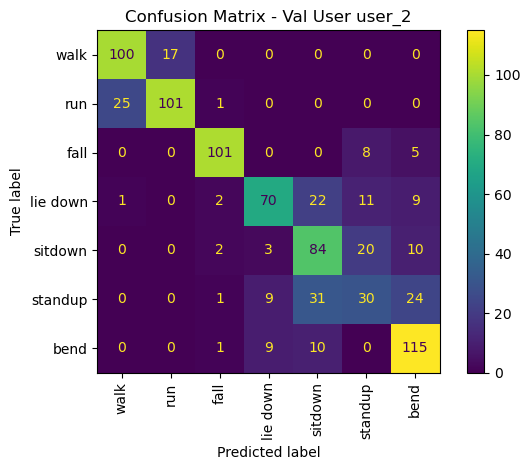

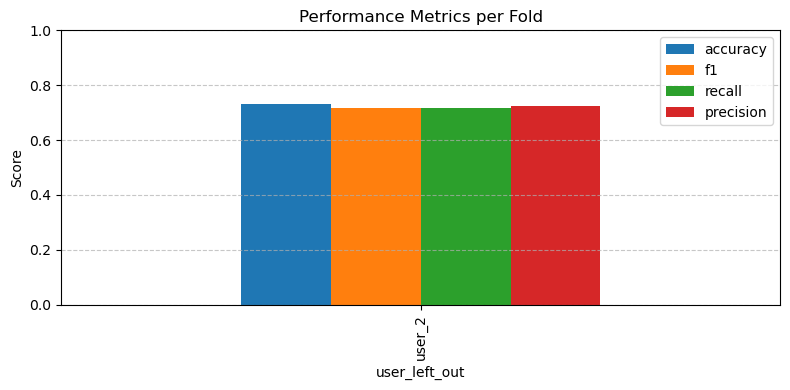

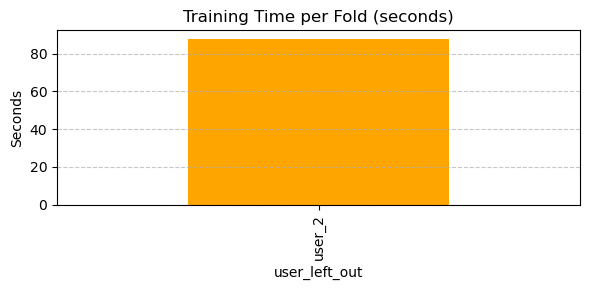

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# --- extract results ---
if 'summary' in globals() and isinstance(summary, dict):
    results = summary.get("results", [])
else:
    # fallback to legacy variables if summary not present
    try:
        results = [{
            "user_left_out": VAL_USER,
            "accuracy": acc,
            "f1": f1,
            "recall": rec,
            "precision": prec,
            "train_time": elapsed,
            "best_epoch": best_epoch
        }]
    except NameError as e:
        raise RuntimeError(f"Cannot build summary: missing variable {e}. Ensure summary or required metrics are in scope.")

# Build DataFrame
df = pd.DataFrame(results)
if "user_left_out" in df.columns:
    df.set_index("user_left_out", inplace=True)

# --- Summary tables ---
print("==== LEAVE-ONE-USER-OUT RESULTS SUMMARY ====")
display(df[['accuracy', 'f1', 'recall', 'precision', 'train_time', 'best_epoch']])

print("\n==== MEAN METRICS ====")
mean_metrics = df[['accuracy', 'f1', 'recall', 'precision', 'train_time']].mean()
print(mean_metrics.to_frame(name="mean").T)

print("\n==== MEAN ± STD ====")
agg = df[['accuracy', 'f1', 'recall', 'precision']].agg(['mean', 'std'])
print(agg)

# --- Model architecture & size ---
print("\n==== MODEL ARCHITECTURE ====")
model_obj = None
if 'summary' in globals():
    model_obj = summary.get('model', None)
if model_obj is None:
    model_obj = globals().get('model', None)
if model_obj is not None:
    print(model_obj)
    try:
        n_params = sum(p.numel() for p in model_obj.parameters())
        print(f"\nTotal parameters: {n_params:,}")
    except Exception:
        pass
else:
    print("Model object not found in scope.")

# --- Classification report & confusion matrix ---
# Prefer summary's y_true/y_pred then globals
y_true = None; y_pred = None
if 'summary' in globals():
    y_true = summary.get("y_true", None)
    y_pred = summary.get("y_pred", None)
if y_true is None or y_pred is None:
    y_true = globals().get('y_true', y_true)
    y_pred = globals().get('y_pred', y_pred)

if y_true is not None and y_pred is not None:
    print("\n==== CLASSIFICATION REPORT ====")
    print(classification_report(y_true, y_pred, target_names=ACTIVITIES, digits=3, zero_division=0))
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=ACTIVITIES)
    disp.plot(xticks_rotation='vertical')
    plt.title(f'Confusion Matrix - Val User {VAL_USER}')
    plt.tight_layout()
    plt.show()
else:
    print("\nNo prediction targets available; skipping classification report/confusion matrix.")

# --- Plots ---
fig, ax = plt.subplots(figsize=(8, 4))
df[['accuracy', 'f1', 'recall', 'precision']].plot(kind='bar', ax=ax)
ax.set_title("Performance Metrics per Fold")
ax.set_ylabel("Score")
ax.set_ylim(0, 1)
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 3))
if 'train_time' in df.columns:
    df['train_time'].plot(kind='bar', color='orange')
    plt.title("Training Time per Fold (seconds)")
    plt.ylabel("Seconds")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("\nNo 'train_time' column to plot.")


In [ ]:
https://chatgpt.com/c/688e7dea-6d0c-832d-afb8-31fe675f9a47

In [ ]:
Experiment5: Savitzky Golay

[00:15:15] INFO: Number of train windows: 1571
[00:15:15] INFO: Number of val windows:   822
[00:15:17] INFO: Epoch 01/150 | Train Loss: 1.8766 | Train Acc: 26.61% | Val Loss: 1.8514 | Val Acc: 31.51% | LR: 1.0e-04
[00:15:19] INFO: Epoch 02/150 | Train Loss: 1.7058 | Train Acc: 41.31% | Val Loss: 1.6950 | Val Acc: 36.74% | LR: 1.0e-04
[00:15:21] INFO: Epoch 03/150 | Train Loss: 1.5638 | Train Acc: 52.64% | Val Loss: 1.5556 | Val Acc: 46.11% | LR: 1.0e-04
[00:15:23] INFO: Epoch 04/150 | Train Loss: 1.4303 | Train Acc: 58.88% | Val Loss: 1.4366 | Val Acc: 53.65% | LR: 1.0e-04
[00:15:26] INFO: Epoch 05/150 | Train Loss: 1.3061 | Train Acc: 64.29% | Val Loss: 1.3253 | Val Acc: 59.49% | LR: 1.0e-04
[00:15:28] INFO: Epoch 06/150 | Train Loss: 1.1977 | Train Acc: 66.96% | Val Loss: 1.2271 | Val Acc: 63.14% | LR: 1.0e-04
[00:15:30] INFO: Epoch 07/150 | Train Loss: 1.1035 | Train Acc: 73.07% | Val Loss: 1.1573 | Val Acc: 66.30% | LR: 1.0e-04
[00:15:32] INFO: Epoch 08/150 | Train Loss: 1.0295 | 

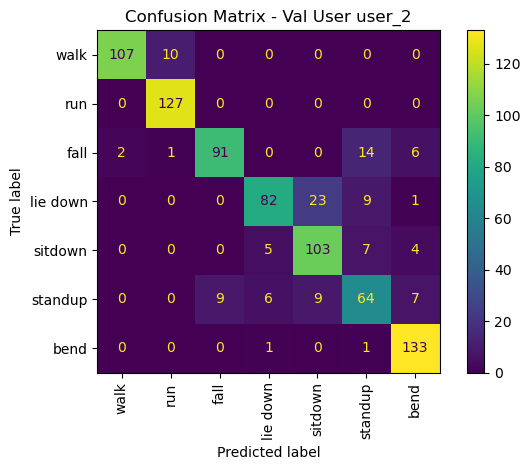

[00:17:59] INFO: Final metrics: accuracy=0.8601, f1=0.8508, recall=0.8500, precision=0.8574
[00:17:59] INFO: Training time: 163.3 seconds


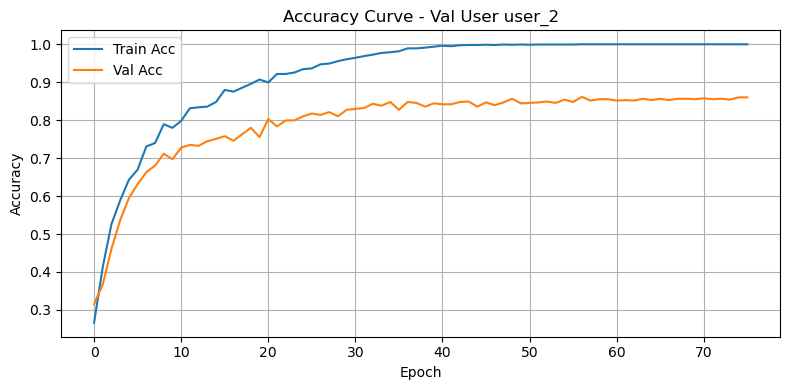

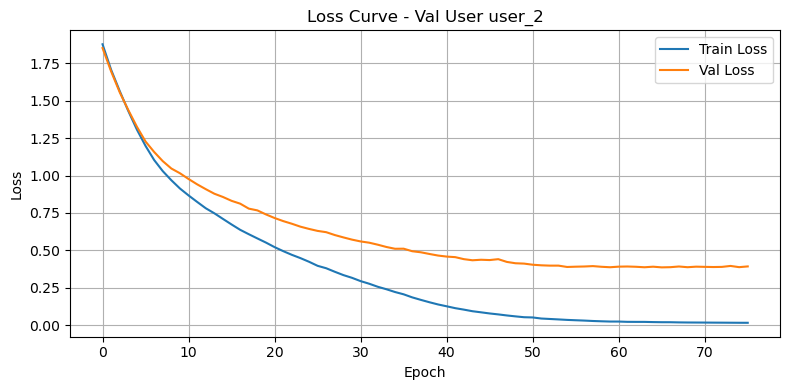

In [30]:
import os
# deterministic CUDA setup (if you want reproducibility); must come before torch import for cuBLAS
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

import re
import logging
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, recall_score, precision_score
from scipy.signal import savgol_filter  # for Savitzky–Golay smoothing


# ====== CONFIGURATION ======
DATASET_ROOT = r'F:/Datasets/CSI-HAR-Dataset-Raspberry-Pi-4/CSI-HAR-Dataset'  # adjust if needed
ACTIVITIES = ['walk', 'run', 'fall', 'lie down', 'sitdown', 'standup', 'bend']
USERS = ['user_1', 'user_2', 'user_3']

TRAIN_USERS = ['user_1', 'user_3']
VAL_USER = 'user_2'

INPUT_DIM = 52
HIDDEN_DIM = 64
NUM_CLASSES = len(ACTIVITIES)
BATCH_SIZE = 64
EPOCHS = 150
PATIENCE = 10
LEARNING_RATE = 1e-4
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEED = 42
WINDOW_LEN = 400
STRIDE = 80


# === Savitzky–Golay filter settings ===
SG_ENABLED = True
SG_WINDOW_LENGTH = 11   # must be odd, controls smoothing span
SG_POLYORDER = 7        # polynomial order; < window_length
SG_MODE = 'mirror'      # boundary handling




# reproducibility
np.random.seed(SEED)
torch.manual_seed(SEED)
try:
    torch.use_deterministic_algorithms(True)
except Exception:
    pass
torch.backends.cudnn.benchmark = False

# logging
logging.basicConfig(
    level=logging.INFO,
    format='[%(asctime)s] %(levelname)s: %(message)s',
    datefmt='%H:%M:%S'
)
logger = logging.getLogger(__name__)


# -------- DATA LOADING WITH PER-FILE NORMALIZATION & WINDOWING --------
from sklearn.decomposition import PCA  # add this import near top

# ---- PCA-per-file config ----
USE_PCA_PER_FILE = True          # toggle per-file PCA
PCA_COMPONENTS = 32             # target reduced subcarrier dimension per file
PCA_WHITEN = True              # whether to whiten (usually False for HAR)

# Modified loader to support per-file PCA
def load_windowed_data_by_user():
    """
    Returns dict: user -> list of (windowed_array, label_index)
    Each CSV file is normalized (per-column standardization) and, if enabled,
    Savitzky–Golay smoothed along time per subcarrier before windowing.
    """
    user_windows = {u: [] for u in USERS}
    for activity in ACTIVITIES:
        folder = os.path.join(DATASET_ROOT, activity)
        if not os.path.isdir(folder):
            logger.warning(f"Missing activity folder: {folder} (skipping '{activity}')")
            continue
        parts = activity.strip().split()
        if len(parts) > 1:
            activity_regex = r'[_ ]+'.join(re.escape(p) for p in parts)
        else:
            activity_regex = re.escape(activity)
        pattern = rf'^(user_\d+)_sample_\d+_{activity_regex}.*\.csv$'
        files = [f for f in os.listdir(folder) if f.lower().endswith('.csv') and not f.lower().startswith('annotation')]
        for f in files:
            match = re.match(pattern, f, flags=re.IGNORECASE)
            if not match:
                continue
            user = match.group(1)
            if user not in USERS:
                continue
            label = ACTIVITIES.index(activity)
            full_path = os.path.join(folder, f)
            try:
                arr = pd.read_csv(full_path, header=None)
            except Exception as e:
                logger.warning(f"Failed to read '{full_path}': {e}")
                continue
            arr = arr.apply(pd.to_numeric, errors='coerce').values
            arr = arr[~np.isnan(arr).all(axis=1)]
            arr = arr[:, ~np.isnan(arr).all(axis=0)]
            if arr.shape[1] != INPUT_DIM:
                logger.debug(f"Skipping '{f}' due to unexpected dim {arr.shape}")
                continue
            if arr.shape[0] < WINDOW_LEN:
                continue  # too short for even one window

            # Per-file normalization: standardize each column
            mean = np.nanmean(arr, axis=0, keepdims=True)
            std = np.nanstd(arr, axis=0, keepdims=True)
            std[std < 1e-6] = 1.0
            arr = (arr - mean) / std  # (T, C)

            # Apply Savitzky–Golay smoothing per subcarrier if enabled
            if SG_ENABLED:
                # ensure window_length is valid for this file
                wl = SG_WINDOW_LENGTH
                if wl % 2 == 0:
                    wl += 1  # enforce odd
                if wl > arr.shape[0]:
                    wl = arr.shape[0] if arr.shape[0] % 2 == 1 else arr.shape[0] - 1
                try:
                    arr = savgol_filter(arr, window_length=wl, polyorder=SG_POLYORDER,
                                        axis=0, mode=SG_MODE)
                except Exception as e:
                    logger.warning(f"SG filter failed for '{f}' with wl={wl}, poly={SG_POLYORDER}: {e}")
                    # fallback: keep original normalized arr

            # Windowing
            n_windows = (arr.shape[0] - WINDOW_LEN) // STRIDE + 1
            for w in range(n_windows):
                start = w * STRIDE
                end = start + WINDOW_LEN
                if end > arr.shape[0]:
                    break
                window = arr[start:end, :]  # (WINDOW_LEN, INPUT_DIM)
                user_windows[user].append((window, label))
    return user_windows



class CSIDataset(Dataset):
    def __init__(self, window_label_pairs):
        if len(window_label_pairs) == 0:
            self.data = np.empty((0, 0, 0))
            self.labels = []
            logger.warning("[WARNING] Empty dataset initialized")
            return
        self.labels = [l for _, l in window_label_pairs]
        stack = np.stack([arr for arr, _ in window_label_pairs])  # (N, W, C)
        self.data = stack  # already normalized per-file
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32), self.labels[idx]


# ============== MODEL ===============
class CNNAttentionGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, cnn_channels=32, dropout=0.3):
        super().__init__()
        # CNN front-end: operate over (time, subcarrier) as a 2D “image”
        self.cnn = nn.Sequential(
            nn.Conv2d(1, cnn_channels, kernel_size=(3, 5), padding=(1, 2)),  # preserves T and C
            nn.ReLU(),
            nn.BatchNorm2d(cnn_channels),
            nn.MaxPool2d((1, 2))  # downsample subcarrier dimension by 2
        )
        # After conv+pool: shape (B, cnn_channels, T, input_dim//2)
        self.gru_input_dim = cnn_channels * (input_dim // 2)
        self.gru = nn.GRU(self.gru_input_dim, hidden_dim, batch_first=True)
        # attention layers (same as before)
        self.attn_query = nn.Linear(hidden_dim, hidden_dim)
        self.attn_key = nn.Linear(hidden_dim, hidden_dim)
        self.attn_value = nn.Linear(hidden_dim, hidden_dim)
        self.layer_norm = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        # x: (B, T, C) where C = original input_dim (subcarriers)
        B, T, C = x.shape
        x = x.unsqueeze(1)  # (B,1,T,C) so we can conv2d over time×subcarrier
        x = self.cnn(x)     # (B, F, T, C_new) where C_new = C//2
        B, F, T_new, C_new = x.shape
        # collapse feature maps into a sequence for GRU: (B, T_new, F * C_new)
        x = x.permute(0, 2, 1, 3).reshape(B, T_new, F * C_new)
        gru_out, _ = self.gru(x)  # (B, T_new, H)
        Q = self.attn_query(gru_out)
        K = self.attn_key(gru_out)
        V = self.attn_value(gru_out)
        attn_scores = torch.matmul(Q, K.transpose(1, 2)) / (Q.size(-1) ** 0.5)
        attn_weights = torch.softmax(attn_scores, dim=-1)
        attn_out = torch.matmul(attn_weights, V)  # (B, T_new, H)
        attn_out = self.layer_norm(attn_out + gru_out)
        attn_out = self.dropout(attn_out)
        pooled = attn_out.mean(dim=1)  # (B, H)
        logits = self.fc(pooled)
        return logits

# Evaluation helper
def evaluate(model, loader, criterion):
    model.eval()
    y_true, y_pred = [], []
    total_loss = 0.0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            out = model(xb)
            loss = criterion(out, yb)
            total_loss += loss.item() * xb.size(0)
            preds = out.argmax(dim=1).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(yb.cpu().numpy())
    avg_loss = total_loss / len(loader.dataset) if len(loader.dataset) > 0 else float('inf')
    accuracy = (np.array(y_true) == np.array(y_pred)).mean() if len(y_true) > 0 else 0.0
    return avg_loss, accuracy, y_true, y_pred

def main():
    # Load with per-fil stats
    user_samples = load_windowed_data_by_user()

    # Build train/val sets: train = TRAIN_USERS; val = VAL_USER
    train_samples = []
    for u in TRAIN_USERS:
        train_samples += user_samples.get(u, [])
    val_samples = user_samples.get(VAL_USER, [])

    train_ds = CSIDataset(train_samples)
    val_ds = CSIDataset(val_samples)
    if len(train_ds) == 0 or len(val_ds) == 0:
        logger.error(f"Empty train or val set (train: {len(train_ds)}, val: {len(val_ds)}), aborting.")
        return

    logger.info(f"Number of train windows: {len(train_ds)}")
    logger.info(f"Number of val windows:   {len(val_ds)}")

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

    # No PCA: use original input dim
    model = CNNAttentionGRU(INPUT_DIM, HIDDEN_DIM, NUM_CLASSES).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3
    )
    criterion = nn.CrossEntropyLoss()

    train_accs, val_accs, train_losses, val_losses = [], [], [], []
    best_val_loss = float('inf')
    best_epoch = 0
    patience_counter = 0
    best_model_state = None

    t0 = time.time()
    for epoch in range(1, EPOCHS + 1):
        model.train()
        epoch_loss = 0.0
        y_true_train, y_pred_train = [], []
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            epoch_loss += loss.item() * xb.size(0)
            preds = out.argmax(dim=1).cpu().numpy()
            y_pred_train.extend(preds)
            y_true_train.extend(yb.cpu().numpy())
        train_loss = epoch_loss / len(train_ds)
        train_acc = (np.array(y_true_train) == np.array(y_pred_train)).mean()

        val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]['lr']

        logger.info(f"Epoch {epoch:02d}/{EPOCHS} | "
                    f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}% | "
                    f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}% | LR: {current_lr:.1e}")

        if val_loss < best_val_loss - 1e-5:
            best_val_loss = val_loss
            best_epoch = epoch
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                logger.info(f"Early stopping triggered at epoch {epoch}.")
                break

    elapsed = time.time() - t0
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    # Final evaluation
    val_loss, val_acc, y_true, y_pred = evaluate(model, val_loader, criterion)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_true, y_pred, average='macro', zero_division=0)
    prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
    acc = val_acc

    logger.info("\n--- Final Evaluation ---")
    logger.info(f"Best epoch: {best_epoch} (best val loss: {best_val_loss:.4f})")
    logger.info(classification_report(y_true, y_pred, target_names=ACTIVITIES, digits=3))
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=ACTIVITIES)
    disp.plot(xticks_rotation='vertical')
    plt.title(f'Confusion Matrix - Val User {VAL_USER}')
    plt.tight_layout()
    plt.show()

    logger.info(f"Final metrics: accuracy={acc:.4f}, f1={f1:.4f}, recall={rec:.4f}, precision={prec:.4f}")
    logger.info(f"Training time: {elapsed:.1f} seconds")

    # Curves
    plt.figure(figsize=(8, 4))
    plt.plot(train_accs, label='Train Acc')
    plt.plot(val_accs, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f"Accuracy Curve - Val User {VAL_USER}")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 4))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f"Loss Curve - Val User {VAL_USER}")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

    return {
        "results": [{
            "user_left_out": VAL_USER,
            "accuracy": acc,
            "f1": f1,
            "recall": rec,
            "precision": prec,
            "train_time": elapsed,
            "best_epoch": best_epoch
        }],
        "model": model,
        "best_epoch": best_epoch,
        "metrics": {"accuracy": acc, "f1": f1, "recall": rec, "precision": prec},
        "y_true": y_true,
        "y_pred": y_pred
    }


if __name__ == "__main__":
    summary = main()


==== LEAVE-ONE-USER-OUT RESULTS SUMMARY ====


,accuracy,f1,recall,precision,train_time,best_epoch
user_left_out,,,,,,
user_2,0.731144,0.715186,0.71688,0.723676,88.023991,108



==== MEAN METRICS ====
      accuracy        f1   recall  precision  train_time
mean  0.731144  0.715186  0.71688   0.723676   88.023991

==== MEAN ± STD ====
      accuracy        f1   recall  precision
mean  0.731144  0.715186  0.71688   0.723676
std        NaN       NaN      NaN        NaN

==== MODEL ARCHITECTURE ====
CNNAttentionGRU(
  (cnn): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 5), stride=(1, 1), padding=(1, 2))
    (1): ReLU()
    (2): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (gru): GRU(50, 64, batch_first=True)
  (attn_query): Linear(in_features=64, out_features=64, bias=True)
  (attn_key): Linear(in_features=64, out_features=64, bias=True)
  (attn_value): Linear(in_features=64, out_features=64, bias=True)
  (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Li

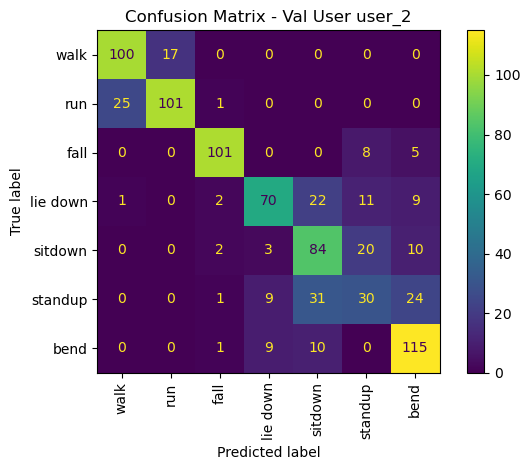

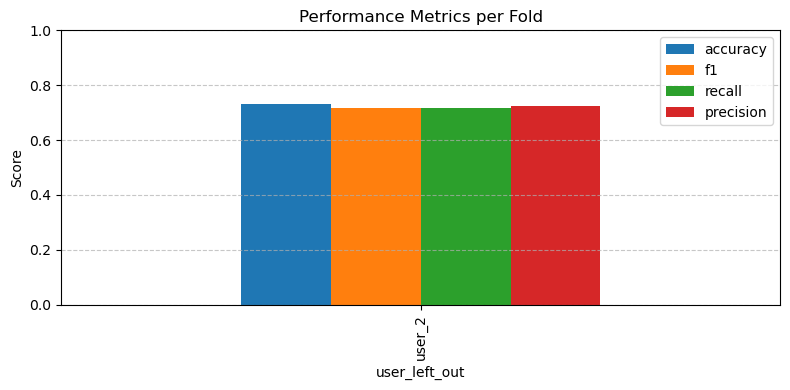

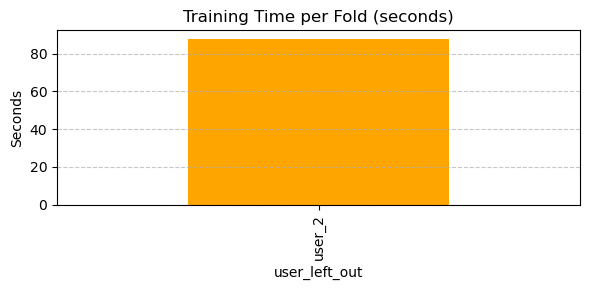

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# --- extract results ---
if 'summary' in globals() and isinstance(summary, dict):
    results = summary.get("results", [])
else:
    # fallback to legacy variables if summary not present
    try:
        results = [{
            "user_left_out": VAL_USER,
            "accuracy": acc,
            "f1": f1,
            "recall": rec,
            "precision": prec,
            "train_time": elapsed,
            "best_epoch": best_epoch
        }]
    except NameError as e:
        raise RuntimeError(f"Cannot build summary: missing variable {e}. Ensure summary or required metrics are in scope.")

# Build DataFrame
df = pd.DataFrame(results)
if "user_left_out" in df.columns:
    df.set_index("user_left_out", inplace=True)

# --- Summary tables ---
print("==== LEAVE-ONE-USER-OUT RESULTS SUMMARY ====")
display(df[['accuracy', 'f1', 'recall', 'precision', 'train_time', 'best_epoch']])

print("\n==== MEAN METRICS ====")
mean_metrics = df[['accuracy', 'f1', 'recall', 'precision', 'train_time']].mean()
print(mean_metrics.to_frame(name="mean").T)

print("\n==== MEAN ± STD ====")
agg = df[['accuracy', 'f1', 'recall', 'precision']].agg(['mean', 'std'])
print(agg)

# --- Model architecture & size ---
print("\n==== MODEL ARCHITECTURE ====")
model_obj = None
if 'summary' in globals():
    model_obj = summary.get('model', None)
if model_obj is None:
    model_obj = globals().get('model', None)
if model_obj is not None:
    print(model_obj)
    try:
        n_params = sum(p.numel() for p in model_obj.parameters())
        print(f"\nTotal parameters: {n_params:,}")
    except Exception:
        pass
else:
    print("Model object not found in scope.")

# --- Classification report & confusion matrix ---
# Prefer summary's y_true/y_pred then globals
y_true = None; y_pred = None
if 'summary' in globals():
    y_true = summary.get("y_true", None)
    y_pred = summary.get("y_pred", None)
if y_true is None or y_pred is None:
    y_true = globals().get('y_true', y_true)
    y_pred = globals().get('y_pred', y_pred)

if y_true is not None and y_pred is not None:
    print("\n==== CLASSIFICATION REPORT ====")
    print(classification_report(y_true, y_pred, target_names=ACTIVITIES, digits=3, zero_division=0))
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=ACTIVITIES)
    disp.plot(xticks_rotation='vertical')
    plt.title(f'Confusion Matrix - Val User {VAL_USER}')
    plt.tight_layout()
    plt.show()
else:
    print("\nNo prediction targets available; skipping classification report/confusion matrix.")

# --- Plots ---
fig, ax = plt.subplots(figsize=(8, 4))
df[['accuracy', 'f1', 'recall', 'precision']].plot(kind='bar', ax=ax)
ax.set_title("Performance Metrics per Fold")
ax.set_ylabel("Score")
ax.set_ylim(0, 1)
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 3))
if 'train_time' in df.columns:
    df['train_time'].plot(kind='bar', color='orange')
    plt.title("Training Time per Fold (seconds)")
    plt.ylabel("Seconds")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("\nNo 'train_time' column to plot.")


In [ ]:
Experiment 6 Wavelet denoysing

In [27]:
import os
# deterministic CUDA setup (if you want reproducibility); must come before torch import for cuBLAS
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

import re
import logging
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, recall_score, precision_score

# ====== CONFIGURATION ======
DATASET_ROOT = r'F:/Datasets/CSI-HAR-Dataset-Raspberry-Pi-4/CSI-HAR-Dataset'  # adjust if needed
ACTIVITIES = ['walk', 'run', 'fall', 'lie down', 'sitdown', 'standup', 'bend']
USERS = ['user_1', 'user_2', 'user_3']

TRAIN_USERS = ['user_1', 'user_3']
VAL_USER = 'user_2'

INPUT_DIM = 52
HIDDEN_DIM = 64
NUM_CLASSES = len(ACTIVITIES)
BATCH_SIZE = 64
EPOCHS = 150
PATIENCE = 10
LEARNING_RATE = 1e-4
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEED = 42
WINDOW_LEN = 400
STRIDE = 80

# reproducibility
np.random.seed(SEED)
torch.manual_seed(SEED)
try:
    torch.use_deterministic_algorithms(True)
except Exception:
    pass
torch.backends.cudnn.benchmark = False

# logging
logging.basicConfig(
    level=logging.INFO,
    format='[%(asctime)s] %(levelname)s: %(message)s',
    datefmt='%H:%M:%S'
)
logger = logging.getLogger(__name__)


# -------- DATA LOADING WITH PER-FILE NORMALIZATION & WINDOWING --------
import pywt  # PyWavelets needed: install via `pip install pywt` if missing
from pywt import threshold, wavedec

# === Wavelet denoising config ===
WAVELET_ENABLED = True
WAVELET_NAME = 'sym6'        # mother wavelet
WAVELET_LEVEL = 5           # decomposition depth
WAVELET_MODE = 'symmetric'   # signal extension mode for DWT
THRESH_METHOD = 'soft'       # thresholding: 'soft' or 'hard'

def wavelet_denoise_signal(y, wavelet, level, mode, threshold_method='soft'):
    """
    Denoise 1D signal y using wavelet shrinkage (universal threshold).
    """
    # Decompose
    coeffs = pywt.wavedec(y, wavelet=wavelet, level=level, mode=mode)
    # Estimate noise sigma from highest-frequency detail (last in list)
    cD1 = coeffs[-1]
    sigma = np.median(np.abs(cD1)) / 0.6745  # robust estimate
    # Universal threshold
    uthresh = sigma * np.sqrt(2 * np.log(len(y)))
    # Threshold detail coeffs (keep approximation as is)
    new_coeffs = [coeffs[0]]
    for c in coeffs[1:]:
        new_c = pywt.threshold(c, value=uthresh, mode=threshold_method)
        new_coeffs.append(new_c)
    # Reconstruct
    y_denoised = pywt.waverec(new_coeffs, wavelet=wavelet, mode=mode)
    # Match original length
    if y_denoised.shape[0] > len(y):
        y_denoised = y_denoised[: len(y)]
    elif y_denoised.shape[0] < len(y):
        pad = len(y) - y_denoised.shape[0]
        y_denoised = np.pad(y_denoised, (0, pad), mode='edge')
    return y_denoised


def load_windowed_data_by_user():
    """
    Returns dict: user -> list of (windowed_array, label_index)
    Each CSV file is normalized (per-column standardization) and, if enabled,
    wavelet-denoised per subcarrier before windowing with adaptive level clamping.
    """
    user_windows = {u: [] for u in USERS}
    for activity in ACTIVITIES:
        folder = os.path.join(DATASET_ROOT, activity)
        if not os.path.isdir(folder):
            logger.warning(f"Missing activity folder: {folder} (skipping '{activity}')")
            continue
        parts = activity.strip().split()
        if len(parts) > 1:
            activity_regex = r'[_ ]+'.join(re.escape(p) for p in parts)
        else:
            activity_regex = re.escape(activity)
        pattern = rf'^(user_\d+)_sample_\d+_{activity_regex}.*\.csv$'
        files = [f for f in os.listdir(folder)
                 if f.lower().endswith('.csv') and not f.lower().startswith('annotation')]
        for f in files:
            match = re.match(pattern, f, flags=re.IGNORECASE)
            if not match:
                continue
            user = match.group(1)
            if user not in USERS:
                continue
            label = ACTIVITIES.index(activity)
            full_path = os.path.join(folder, f)
            try:
                arr = pd.read_csv(full_path, header=None)
            except Exception as e:
                logger.warning(f"Failed to read '{full_path}': {e}")
                continue
            arr = arr.apply(pd.to_numeric, errors='coerce').values
            arr = arr[~np.isnan(arr).all(axis=1)]
            arr = arr[:, ~np.isnan(arr).all(axis=0)]
            if arr.shape[1] != INPUT_DIM:
                logger.debug(f"Skipping '{f}' due to unexpected dim {arr.shape}")
                continue
            if arr.shape[0] < WINDOW_LEN:
                continue  # too short for even one window

            # Per-file normalization
            mean = np.nanmean(arr, axis=0, keepdims=True)
            std = np.nanstd(arr, axis=0, keepdims=True)
            std[std < 1e-6] = 1.0
            arr = (arr - mean) / std  # shape (T, C)

            # Wavelet denoising per subcarrier with adaptive level
            if WAVELET_ENABLED:
                try:
                    wavelet_obj = pywt.Wavelet(WAVELET_NAME)
                    max_lvl = pywt.dwt_max_level(arr.shape[0], wavelet_obj.dec_len)
                    use_lvl = min(WAVELET_LEVEL, max_lvl)
                    if use_lvl >= 1:
                        denoised_cols = []
                        for i in range(arr.shape[1]):
                            col = arr[:, i]
                            denoised = wavelet_denoise_signal(
                                col,
                                wavelet=WAVELET_NAME,
                                level=use_lvl,
                                mode=WAVELET_MODE,
                                threshold_method=THRESH_METHOD
                            )
                            denoised_cols.append(denoised)
                        arr = np.stack(denoised_cols, axis=1)  # (T, C)
                    else:
                        logger.debug(
                            f"Wavelet level <1 for file '{f}' (len={arr.shape[0]}, "
                            f"filter_len={wavelet_obj.dec_len}); skipping denoising."
                        )
                except Exception as e:
                    logger.warning(f"Wavelet denoising failed for '{f}': {e}")
                    # fallback: keep arr as-is

            # Windowing
            n_windows = (arr.shape[0] - WINDOW_LEN) // STRIDE + 1
            for w in range(n_windows):
                start = w * STRIDE
                end = start + WINDOW_LEN
                if end > arr.shape[0]:
                    break
                window = arr[start:end, :]  # (WINDOW_LEN, INPUT_DIM)
                user_windows[user].append((window, label))
    return user_windows


class CSIDataset(Dataset):
    def __init__(self, window_label_pairs):
        if len(window_label_pairs) == 0:
            self.data = np.empty((0, 0, 0))
            self.labels = []
            logger.warning("[WARNING] Empty dataset initialized")
            return
        self.labels = [l for _, l in window_label_pairs]
        stack = np.stack([arr for arr, _ in window_label_pairs])  # (N, W, C)
        self.data = stack  # already normalized per-file
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32), self.labels[idx]


# ============== MODEL ===============
class CNNAttentionGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, cnn_channels=32, dropout=0.3):
        super().__init__()
        # CNN front-end: operate over (time, subcarrier) as a 2D “image”
        self.cnn = nn.Sequential(
            nn.Conv2d(1, cnn_channels, kernel_size=(3, 5), padding=(1, 2)),  # preserves T and C
            nn.ReLU(),
            nn.BatchNorm2d(cnn_channels),
            nn.MaxPool2d((1, 2))  # downsample subcarrier dimension by 2
        )
        # After conv+pool: shape (B, cnn_channels, T, input_dim//2)
        self.gru_input_dim = cnn_channels * (input_dim // 2)
        self.gru = nn.GRU(self.gru_input_dim, hidden_dim, batch_first=True)
        # attention layers (same as before)
        self.attn_query = nn.Linear(hidden_dim, hidden_dim)
        self.attn_key = nn.Linear(hidden_dim, hidden_dim)
        self.attn_value = nn.Linear(hidden_dim, hidden_dim)
        self.layer_norm = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        # x: (B, T, C) where C = original input_dim (subcarriers)
        B, T, C = x.shape
        x = x.unsqueeze(1)  # (B,1,T,C) so we can conv2d over time×subcarrier
        x = self.cnn(x)     # (B, F, T, C_new) where C_new = C//2
        B, F, T_new, C_new = x.shape
        # collapse feature maps into a sequence for GRU: (B, T_new, F * C_new)
        x = x.permute(0, 2, 1, 3).reshape(B, T_new, F * C_new)
        gru_out, _ = self.gru(x)  # (B, T_new, H)
        Q = self.attn_query(gru_out)
        K = self.attn_key(gru_out)
        V = self.attn_value(gru_out)
        attn_scores = torch.matmul(Q, K.transpose(1, 2)) / (Q.size(-1) ** 0.5)
        attn_weights = torch.softmax(attn_scores, dim=-1)
        attn_out = torch.matmul(attn_weights, V)  # (B, T_new, H)
        attn_out = self.layer_norm(attn_out + gru_out)
        attn_out = self.dropout(attn_out)
        pooled = attn_out.mean(dim=1)  # (B, H)
        logits = self.fc(pooled)
        return logits

# Evaluation helper
def evaluate(model, loader, criterion):
    model.eval()
    y_true, y_pred = [], []
    total_loss = 0.0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            out = model(xb)
            loss = criterion(out, yb)
            total_loss += loss.item() * xb.size(0)
            preds = out.argmax(dim=1).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(yb.cpu().numpy())
    avg_loss = total_loss / len(loader.dataset) if len(loader.dataset) > 0 else float('inf')
    accuracy = (np.array(y_true) == np.array(y_pred)).mean() if len(y_true) > 0 else 0.0
    return avg_loss, accuracy, y_true, y_pred

def main():
    # Load data (with per-file wavelet denoising inside loader)
    user_samples = load_windowed_data_by_user()

    # Build train/val sets: train = TRAIN_USERS; val = VAL_USER
    train_samples = []
    for u in TRAIN_USERS:
        train_samples += user_samples.get(u, [])
    val_samples = user_samples.get(VAL_USER, [])

    train_ds = CSIDataset(train_samples)
    val_ds = CSIDataset(val_samples)
    if len(train_ds) == 0 or len(val_ds) == 0:
        logger.error(f"Empty train or val set (train: {len(train_ds)}, val: {len(val_ds)}), aborting.")
        return

    logger.info(f"Number of train windows: {len(train_ds)}")
    logger.info(f"Number of val windows:   {len(val_ds)}")

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

    # Model instantiation (no PCA, input dim is original)
    model = CNNAttentionGRU(INPUT_DIM, HIDDEN_DIM, NUM_CLASSES).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3
    )
    criterion = nn.CrossEntropyLoss()

    train_accs, val_accs, train_losses, val_losses = [], [], [], []
    best_val_loss = float('inf')
    best_epoch = 0
    patience_counter = 0
    best_model_state = None

    t0 = time.time()
    for epoch in range(1, EPOCHS + 1):
        model.train()
        epoch_loss = 0.0
        y_true_train, y_pred_train = [], []
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            epoch_loss += loss.item() * xb.size(0)
            preds = out.argmax(dim=1).cpu().numpy()
            y_pred_train.extend(preds)
            y_true_train.extend(yb.cpu().numpy())

        train_loss = epoch_loss / len(train_ds)
        train_acc = (np.array(y_true_train) == np.array(y_pred_train)).mean()

        val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]['lr']

        logger.info(f"Epoch {epoch:02d}/{EPOCHS} | "
                    f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}% | "
                    f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}% | LR: {current_lr:.1e}")

        if val_loss < best_val_loss - 1e-5:
            best_val_loss = val_loss
            best_epoch = epoch
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                logger.info(f"Early stopping triggered at epoch {epoch}.")
                break

    elapsed = time.time() - t0
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    # Final evaluation
    val_loss, val_acc, y_true, y_pred = evaluate(model, val_loader, criterion)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_true, y_pred, average='macro', zero_division=0)
    prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
    acc = val_acc

    logger.info("\n--- Final Evaluation ---")
    logger.info(f"Best epoch: {best_epoch} (best val loss: {best_val_loss:.4f})")
    logger.info(classification_report(y_true, y_pred, target_names=ACTIVITIES, digits=3))
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=ACTIVITIES)
    disp.plot(xticks_rotation='vertical')
    plt.title(f'Confusion Matrix - Val User {VAL_USER}')
    plt.tight_layout()
    plt.show()

    logger.info(f'Final metrics: accuracy={acc:.4f}, f1={f1:.4f}, recall={rec:.4f}, precision={prec:.4f}')
    logger.info(f'Training time: {elapsed:.1f} seconds')

    # Curves
    plt.figure(figsize=(8, 4))
    plt.plot(train_accs, label='Train Acc')
    plt.plot(val_accs, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy Curve - Val User {VAL_USER}')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 4))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Loss Curve - Val User {VAL_USER}')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

    return {
        "results": [{
            "user_left_out": VAL_USER,
            "accuracy": acc,
            "f1": f1,
            "recall": rec,
            "precision": prec,
            "train_time": elapsed,
            "best_epoch": best_epoch
        }],
        "model": model,
        "best_epoch": best_epoch,
        "metrics": {
            "accuracy": acc,
            "f1": f1,
            "recall": rec,
            "precision": prec
        },
        "y_true": y_true,
        "y_pred": y_pred
    }

if __name__ == "__main__":
    summary = main()


[23:07:50] WARNING: Wavelet denoising failed for 'user_1_sample_10_walk_A.csv': threshold() got an unexpected keyword argument 'method'
[23:07:50] WARNING: Wavelet denoising failed for 'user_1_sample_11_walk_A.csv': threshold() got an unexpected keyword argument 'method'
[23:07:50] WARNING: Wavelet denoising failed for 'user_1_sample_12_walk_A.csv': threshold() got an unexpected keyword argument 'method'
[23:07:50] WARNING: Wavelet denoising failed for 'user_1_sample_13_walk_A.csv': threshold() got an unexpected keyword argument 'method'
[23:07:50] WARNING: Wavelet denoising failed for 'user_1_sample_14_walk_A.csv': threshold() got an unexpected keyword argument 'method'
[23:07:50] WARNING: Wavelet denoising failed for 'user_1_sample_15_walk_A.csv': threshold() got an unexpected keyword argument 'method'
[23:07:50] WARNING: Wavelet denoising failed for 'user_1_sample_16_walk_A.csv': threshold() got an unexpected keyword argument 'method'
[23:07:50] WARNING: Wavelet denoising failed for

KeyboardInterrupt: 

==== LEAVE-ONE-USER-OUT RESULTS SUMMARY ====


,accuracy,f1,recall,precision,train_time,best_epoch
user_left_out,,,,,,
user_2,0.819951,0.81089,0.81166,0.815166,133.829893,51



==== MEAN METRICS ====
      accuracy       f1   recall  precision  train_time
mean  0.819951  0.81089  0.81166   0.815166  133.829893

==== MEAN ± STD ====
      accuracy       f1   recall  precision
mean  0.819951  0.81089  0.81166   0.815166
std        NaN      NaN      NaN        NaN

==== MODEL ARCHITECTURE ====
CNNAttentionGRU(
  (cnn): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 5), stride=(1, 1), padding=(1, 2))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (gru): GRU(832, 64, batch_first=True)
  (attn_query): Linear(in_features=64, out_features=64, bias=True)
  (attn_key): Linear(in_features=64, out_features=64, bias=True)
  (attn_value): Linear(in_features=64, out_features=64, bias=True)
  (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear

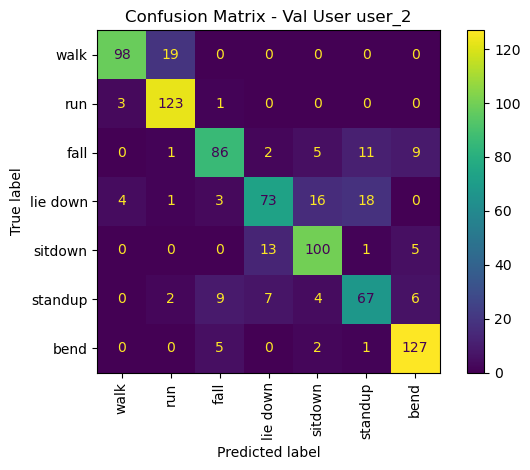

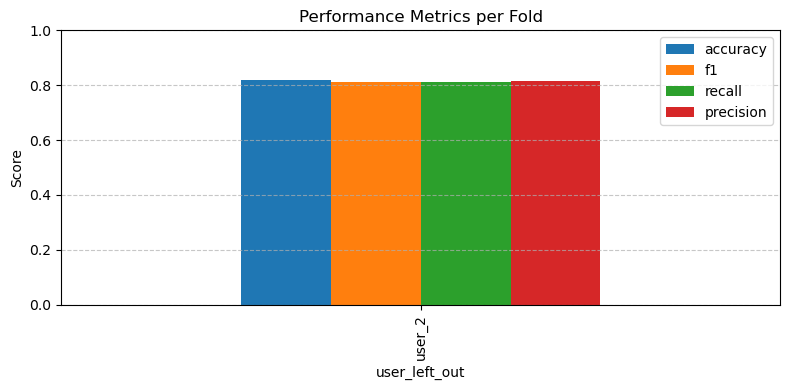

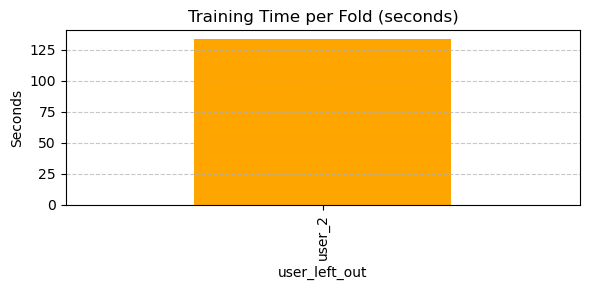

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# --- extract results ---
if 'summary' in globals() and isinstance(summary, dict):
    results = summary.get("results", [])
else:
    # fallback to legacy variables if summary not present
    try:
        results = [{
            "user_left_out": VAL_USER,
            "accuracy": acc,
            "f1": f1,
            "recall": rec,
            "precision": prec,
            "train_time": elapsed,
            "best_epoch": best_epoch
        }]
    except NameError as e:
        raise RuntimeError(f"Cannot build summary: missing variable {e}. Ensure summary or required metrics are in scope.")

# Build DataFrame
df = pd.DataFrame(results)
if "user_left_out" in df.columns:
    df.set_index("user_left_out", inplace=True)

# --- Summary tables ---
print("==== LEAVE-ONE-USER-OUT RESULTS SUMMARY ====")
display(df[['accuracy', 'f1', 'recall', 'precision', 'train_time', 'best_epoch']])

print("\n==== MEAN METRICS ====")
mean_metrics = df[['accuracy', 'f1', 'recall', 'precision', 'train_time']].mean()
print(mean_metrics.to_frame(name="mean").T)

print("\n==== MEAN ± STD ====")
agg = df[['accuracy', 'f1', 'recall', 'precision']].agg(['mean', 'std'])
print(agg)

# --- Model architecture & size ---
print("\n==== MODEL ARCHITECTURE ====")
model_obj = None
if 'summary' in globals():
    model_obj = summary.get('model', None)
if model_obj is None:
    model_obj = globals().get('model', None)
if model_obj is not None:
    print(model_obj)
    try:
        n_params = sum(p.numel() for p in model_obj.parameters())
        print(f"\nTotal parameters: {n_params:,}")
    except Exception:
        pass
else:
    print("Model object not found in scope.")

# --- Classification report & confusion matrix ---
# Prefer summary's y_true/y_pred then globals
y_true = None; y_pred = None
if 'summary' in globals():
    y_true = summary.get("y_true", None)
    y_pred = summary.get("y_pred", None)
if y_true is None or y_pred is None:
    y_true = globals().get('y_true', y_true)
    y_pred = globals().get('y_pred', y_pred)

if y_true is not None and y_pred is not None:
    print("\n==== CLASSIFICATION REPORT ====")
    print(classification_report(y_true, y_pred, target_names=ACTIVITIES, digits=3, zero_division=0))
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=ACTIVITIES)
    disp.plot(xticks_rotation='vertical')
    plt.title(f'Confusion Matrix - Val User {VAL_USER}')
    plt.tight_layout()
    plt.show()
else:
    print("\nNo prediction targets available; skipping classification report/confusion matrix.")

# --- Plots ---
fig, ax = plt.subplots(figsize=(8, 4))
df[['accuracy', 'f1', 'recall', 'precision']].plot(kind='bar', ax=ax)
ax.set_title("Performance Metrics per Fold")
ax.set_ylabel("Score")
ax.set_ylim(0, 1)
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 3))
if 'train_time' in df.columns:
    df['train_time'].plot(kind='bar', color='orange')
    plt.title("Training Time per Fold (seconds)")
    plt.ylabel("Seconds")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("\nNo 'train_time' column to plot.")


In [ ]:
Hampel

[22:26:05] INFO: === Starting main pipeline ===
[22:26:05] INFO: === Starting activity loader ===
[22:28:46] INFO: === Starting activity loader ===
[22:31:35] INFO: === Starting activity loader ===
[22:34:22] INFO: === Starting activity loader ===
[22:37:04] INFO: === Starting activity loader ===
[22:39:54] INFO: === Starting activity loader ===
[22:42:39] INFO: === Starting activity loader ===
[22:45:35] INFO: Number of train windows: 1571
[22:45:35] INFO: Number of val windows:   822
[22:45:38] INFO: Epoch 01/150 | Train Loss: 1.8692 | Train Acc: 27.69% | Val Loss: 1.8270 | Val Acc: 33.58% | LR: 1.0e-04
[22:45:40] INFO: Epoch 02/150 | Train Loss: 1.6877 | Train Acc: 41.25% | Val Loss: 1.6554 | Val Acc: 39.29% | LR: 1.0e-04
[22:45:42] INFO: Epoch 03/150 | Train Loss: 1.5408 | Train Acc: 51.30% | Val Loss: 1.5152 | Val Acc: 46.96% | LR: 1.0e-04
[22:45:44] INFO: Epoch 04/150 | Train Loss: 1.4081 | Train Acc: 57.48% | Val Loss: 1.3995 | Val Acc: 54.01% | LR: 1.0e-04
[22:45:46] INFO: Epoc

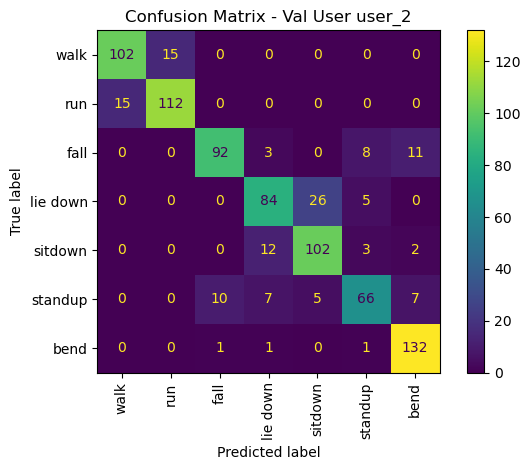

[22:47:57] INFO: Final metrics: accuracy=0.8394, f1=0.8328, recall=0.8315, precision=0.8375
[22:47:57] INFO: Training time: 141.3 seconds


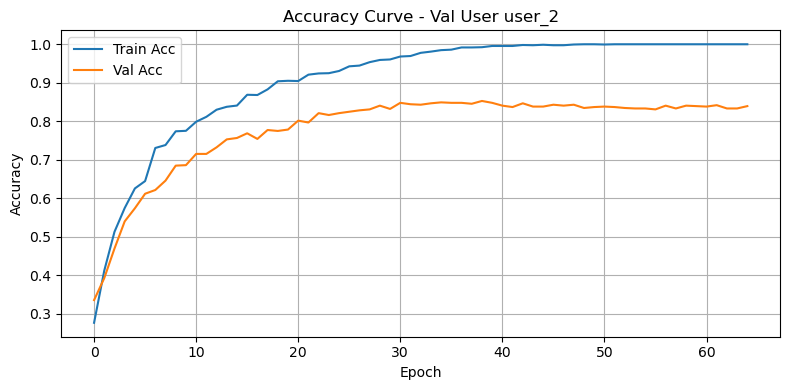

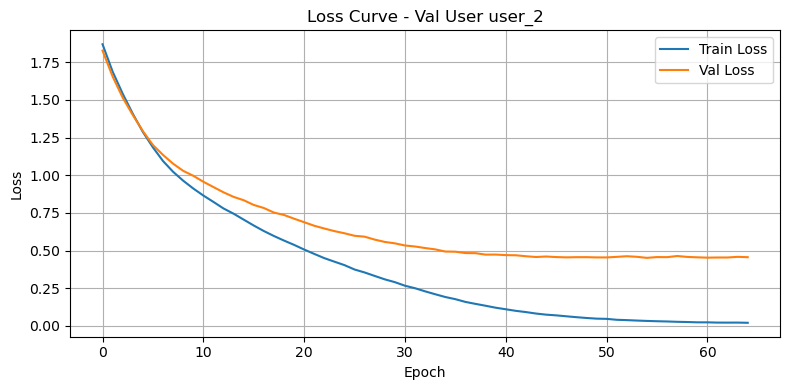

In [5]:
import os
# deterministic CUDA setup (if you want reproducibility); must come before torch import for cuBLAS
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

import re
import logging
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, recall_score, precision_score

# ====== CONFIGURATION ======
DATASET_ROOT = r'F:/Datasets/CSI-HAR-Dataset-Raspberry-Pi-4/CSI-HAR-Dataset'  # adjust if needed
ACTIVITIES = ['walk', 'run', 'fall', 'lie down', 'sitdown', 'standup', 'bend']
USERS = ['user_1', 'user_2', 'user_3']

TRAIN_USERS = ['user_1', 'user_3']
VAL_USER = 'user_2'

INPUT_DIM = 52
HIDDEN_DIM = 64
NUM_CLASSES = len(ACTIVITIES)
BATCH_SIZE = 64
EPOCHS = 150
PATIENCE = 10
LEARNING_RATE = 1e-4
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEED = 42
WINDOW_LEN = 400
STRIDE = 80


# === Hampel filter config ===
HAMPEL_ENABLED = True
HAMPEL_WINDOW_SIZE = 21  # must be odd, controls neighborhood size
HAMPEL_N_SIGMAS = 3      # sensitivity (typically 3)



# reproducibility
np.random.seed(SEED)
torch.manual_seed(SEED)
try:
    torch.use_deterministic_algorithms(True)
except Exception:
    pass
torch.backends.cudnn.benchmark = False

# logging
logging.basicConfig(
    level=logging.INFO,
    format='[%(asctime)s] %(levelname)s: %(message)s',
    datefmt='%H:%M:%S'
)
logger = logging.getLogger(__name__)




def hampel_filter_1d(x, window_size=11, n_sigmas=3):
    """
    Apply Hampel filter to 1D array x. Replaces outliers with local median.
    window_size must be odd.
    """
    if window_size % 2 == 0:
        window_size += 1  # force odd
    n = len(x)
    k = (window_size - 1) // 2
    x_filtered = x.copy()
    for i in range(n):
        start = max(0, i - k)
        end = min(n, i + k + 1)
        window = x[start:end]
        median = np.median(window)
        mad = np.median(np.abs(window - median))
        # scale factor to approximate standard deviation from MAD
        threshold = n_sigmas * 1.4826 * mad
        if np.abs(x[i] - median) > threshold:
            x_filtered[i] = median
    return x_filtered

def load_windowed_data_by_user():
    """
    Returns dict: user -> list of (windowed_array, label_index)
    Each CSV file is normalized (per-column standardization) and, if enabled,
    Hampel-filtered per subcarrier before windowing.
    """
    user_windows = {u: [] for u in USERS}
    for activity in ACTIVITIES:
        logger.info("=== Starting activity loader ===")
        folder = os.path.join(DATASET_ROOT, activity)
        if not os.path.isdir(folder):
            logger.warning(f"Missing activity folder: {folder} (skipping '{activity}')")
            continue
        parts = activity.strip().split()
        if len(parts) > 1:
            activity_regex = r'[_ ]+'.join(re.escape(p) for p in parts)
        else:
            activity_regex = re.escape(activity)
        pattern = rf'^(user_\d+)_sample_\d+_{activity_regex}.*\.csv$'
        files = [f for f in os.listdir(folder)
                 if f.lower().endswith('.csv') and not f.lower().startswith('annotation')]
        for f in files:
            match = re.match(pattern, f, flags=re.IGNORECASE)
            if not match:
                continue
            user = match.group(1)
            if user not in USERS:
                continue
            label = ACTIVITIES.index(activity)
            full_path = os.path.join(folder, f)
            try:
                arr = pd.read_csv(full_path, header=None)
            except Exception as e:
                logger.warning(f"Failed to read '{full_path}': {e}")
                continue
            arr = arr.apply(pd.to_numeric, errors='coerce').values
            arr = arr[~np.isnan(arr).all(axis=1)]
            arr = arr[:, ~np.isnan(arr).all(axis=0)]
            if arr.shape[1] != INPUT_DIM:
                logger.debug(f"Skipping '{f}' due to unexpected dim {arr.shape}")
                continue
            if arr.shape[0] < WINDOW_LEN:
                continue  # too short for even one window

            # Per-file normalization
            mean = np.nanmean(arr, axis=0, keepdims=True)
            std = np.nanstd(arr, axis=0, keepdims=True)
            std[std < 1e-6] = 1.0
            arr = (arr - mean) / std  # shape (T, C)

            # Hampel filtering per subcarrier
            if HAMPEL_ENABLED:
                try:
                    filtered_cols = []
                    for i in range(arr.shape[1]):
                        col = arr[:, i]
                        filtered = hampel_filter_1d(col, window_size=HAMPEL_WINDOW_SIZE, n_sigmas=HAMPEL_N_SIGMAS)
                        filtered_cols.append(filtered)
                    arr = np.stack(filtered_cols, axis=1)  # (T, C)
                except Exception as e:
                    logger.warning(f"Hampel filtering failed for '{f}': {e}")
                    # fallback: keep arr as-is

            # Windowing
            n_windows = (arr.shape[0] - WINDOW_LEN) // STRIDE + 1
            for w in range(n_windows):
                start = w * STRIDE
                end = start + WINDOW_LEN
                if end > arr.shape[0]:
                    break
                window = arr[start:end, :]  # (WINDOW_LEN, INPUT_DIM)
                user_windows[user].append((window, label))
    return user_windows


class CSIDataset(Dataset):
    def __init__(self, window_label_pairs):
        if len(window_label_pairs) == 0:
            self.data = np.empty((0, 0, 0))
            self.labels = []
            logger.warning("[WARNING] Empty dataset initialized")
            return
        self.labels = [l for _, l in window_label_pairs]
        stack = np.stack([arr for arr, _ in window_label_pairs])  # (N, W, C)
        self.data = stack  # already normalized per-file
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32), self.labels[idx]


# ============== MODEL ===============
class CNNAttentionGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, cnn_channels=32, dropout=0.3):
        super().__init__()
        # CNN front-end: operate over (time, subcarrier) as a 2D “image”
        self.cnn = nn.Sequential(
            nn.Conv2d(1, cnn_channels, kernel_size=(3, 5), padding=(1, 2)),  # preserves T and C
            nn.ReLU(),
            nn.BatchNorm2d(cnn_channels),
            nn.MaxPool2d((1, 2))  # downsample subcarrier dimension by 2
        )
        # After conv+pool: shape (B, cnn_channels, T, input_dim//2)
        self.gru_input_dim = cnn_channels * (input_dim // 2)
        self.gru = nn.GRU(self.gru_input_dim, hidden_dim, batch_first=True)
        # attention layers (same as before)
        self.attn_query = nn.Linear(hidden_dim, hidden_dim)
        self.attn_key = nn.Linear(hidden_dim, hidden_dim)
        self.attn_value = nn.Linear(hidden_dim, hidden_dim)
        self.layer_norm = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        # x: (B, T, C) where C = original input_dim (subcarriers)
        B, T, C = x.shape
        x = x.unsqueeze(1)  # (B,1,T,C) so we can conv2d over time×subcarrier
        x = self.cnn(x)     # (B, F, T, C_new) where C_new = C//2
        B, F, T_new, C_new = x.shape
        # collapse feature maps into a sequence for GRU: (B, T_new, F * C_new)
        x = x.permute(0, 2, 1, 3).reshape(B, T_new, F * C_new)
        gru_out, _ = self.gru(x)  # (B, T_new, H)
        Q = self.attn_query(gru_out)
        K = self.attn_key(gru_out)
        V = self.attn_value(gru_out)
        attn_scores = torch.matmul(Q, K.transpose(1, 2)) / (Q.size(-1) ** 0.5)
        attn_weights = torch.softmax(attn_scores, dim=-1)
        attn_out = torch.matmul(attn_weights, V)  # (B, T_new, H)
        attn_out = self.layer_norm(attn_out + gru_out)
        attn_out = self.dropout(attn_out)
        pooled = attn_out.mean(dim=1)  # (B, H)
        logits = self.fc(pooled)
        return logits

# Evaluation helper
def evaluate(model, loader, criterion):
    model.eval()
    y_true, y_pred = [], []
    total_loss = 0.0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            out = model(xb)
            loss = criterion(out, yb)
            total_loss += loss.item() * xb.size(0)
            preds = out.argmax(dim=1).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(yb.cpu().numpy())
    avg_loss = total_loss / len(loader.dataset) if len(loader.dataset) > 0 else float('inf')
    accuracy = (np.array(y_true) == np.array(y_pred)).mean() if len(y_true) > 0 else 0.0
    return avg_loss, accuracy, y_true, y_pred

def main():
    logger.info("=== Starting main pipeline ===")
    # Load data (with per-file wavelet denoising inside loader)
    user_samples = load_windowed_data_by_user()

    # Build train/val sets: train = TRAIN_USERS; val = VAL_USER
    train_samples = []
    for u in TRAIN_USERS:
        train_samples += user_samples.get(u, [])
    val_samples = user_samples.get(VAL_USER, [])

    train_ds = CSIDataset(train_samples)
    val_ds = CSIDataset(val_samples)
    if len(train_ds) == 0 or len(val_ds) == 0:
        logger.error(f"Empty train or val set (train: {len(train_ds)}, val: {len(val_ds)}), aborting.")
        return

    logger.info(f"Number of train windows: {len(train_ds)}")
    logger.info(f"Number of val windows:   {len(val_ds)}")

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

    # Model instantiation (no PCA, input dim is original)
    model = CNNAttentionGRU(INPUT_DIM, HIDDEN_DIM, NUM_CLASSES).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3
    )
    criterion = nn.CrossEntropyLoss()

    train_accs, val_accs, train_losses, val_losses = [], [], [], []
    best_val_loss = float('inf')
    best_epoch = 0
    patience_counter = 0
    best_model_state = None

    t0 = time.time()
    for epoch in range(1, EPOCHS + 1):
        model.train()
        epoch_loss = 0.0
        y_true_train, y_pred_train = [], []
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            epoch_loss += loss.item() * xb.size(0)
            preds = out.argmax(dim=1).cpu().numpy()
            y_pred_train.extend(preds)
            y_true_train.extend(yb.cpu().numpy())

        train_loss = epoch_loss / len(train_ds)
        train_acc = (np.array(y_true_train) == np.array(y_pred_train)).mean()

        val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]['lr']

        logger.info(f"Epoch {epoch:02d}/{EPOCHS} | "
                    f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}% | "
                    f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}% | LR: {current_lr:.1e}")

        if val_loss < best_val_loss - 1e-5:
            best_val_loss = val_loss
            best_epoch = epoch
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                logger.info(f"Early stopping triggered at epoch {epoch}.")
                break

    elapsed = time.time() - t0
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    # Final evaluation
    val_loss, val_acc, y_true, y_pred = evaluate(model, val_loader, criterion)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_true, y_pred, average='macro', zero_division=0)
    prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
    acc = val_acc

    logger.info("\n--- Final Evaluation ---")
    logger.info(f"Best epoch: {best_epoch} (best val loss: {best_val_loss:.4f})")
    logger.info(classification_report(y_true, y_pred, target_names=ACTIVITIES, digits=3))
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=ACTIVITIES)
    disp.plot(xticks_rotation='vertical')
    plt.title(f'Confusion Matrix - Val User {VAL_USER}')
    plt.tight_layout()
    plt.show()

    logger.info(f'Final metrics: accuracy={acc:.4f}, f1={f1:.4f}, recall={rec:.4f}, precision={prec:.4f}')
    logger.info(f'Training time: {elapsed:.1f} seconds')

    # Curves
    plt.figure(figsize=(8, 4))
    plt.plot(train_accs, label='Train Acc')
    plt.plot(val_accs, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy Curve - Val User {VAL_USER}')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 4))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Loss Curve - Val User {VAL_USER}')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

    return {
        "results": [{
            "user_left_out": VAL_USER,
            "accuracy": acc,
            "f1": f1,
            "recall": rec,
            "precision": prec,
            "train_time": elapsed,
            "best_epoch": best_epoch
        }],
        "model": model,
        "best_epoch": best_epoch,
        "metrics": {
            "accuracy": acc,
            "f1": f1,
            "recall": rec,
            "precision": prec
        },
        "y_true": y_true,
        "y_pred": y_pred
    }


summary = main()


==== LEAVE-ONE-USER-OUT RESULTS SUMMARY ====


,accuracy,f1,recall,precision,train_time,best_epoch
user_left_out,,,,,,
user_2,0.839416,0.832761,0.831542,0.837493,141.304484,55



==== MEAN METRICS ====
      accuracy        f1    recall  precision  train_time
mean  0.839416  0.832761  0.831542   0.837493  141.304484

==== MEAN ± STD ====
      accuracy        f1    recall  precision
mean  0.839416  0.832761  0.831542   0.837493
std        NaN       NaN       NaN        NaN

==== MODEL ARCHITECTURE ====
CNNAttentionGRU(
  (cnn): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 5), stride=(1, 1), padding=(1, 2))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (gru): GRU(832, 64, batch_first=True)
  (attn_query): Linear(in_features=64, out_features=64, bias=True)
  (attn_key): Linear(in_features=64, out_features=64, bias=True)
  (attn_value): Linear(in_features=64, out_features=64, bias=True)
  (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (f

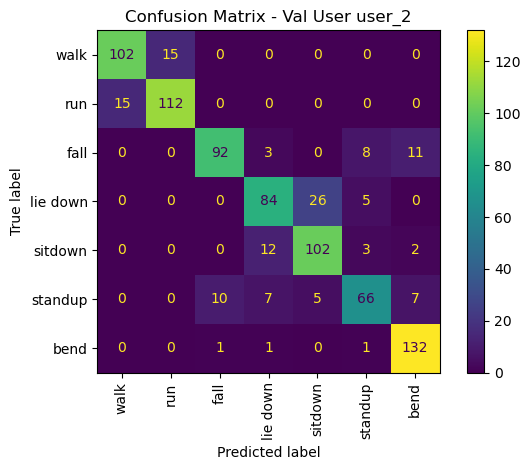

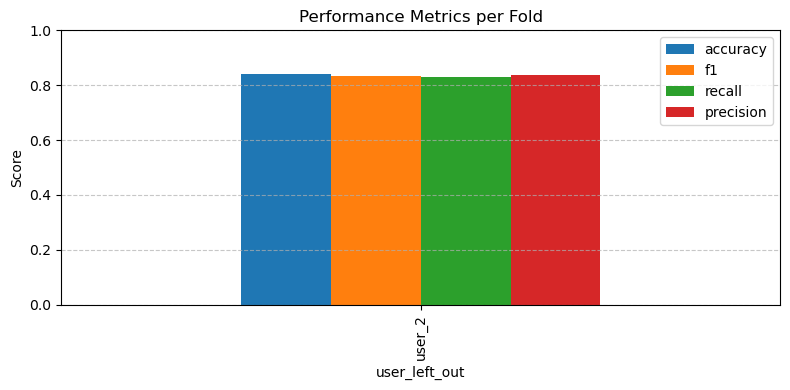

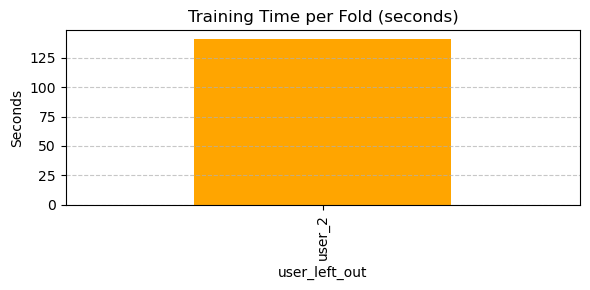

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# --- extract results ---
if 'summary' in globals() and isinstance(summary, dict):
    results = summary.get("results", [])
else:
    # fallback to legacy variables if summary not present
    try:
        results = [{
            "user_left_out": VAL_USER,
            "accuracy": acc,
            "f1": f1,
            "recall": rec,
            "precision": prec,
            "train_time": elapsed,
            "best_epoch": best_epoch
        }]
    except NameError as e:
        raise RuntimeError(f"Cannot build summary: missing variable {e}. Ensure summary or required metrics are in scope.")

# Build DataFrame
df = pd.DataFrame(results)
if "user_left_out" in df.columns:
    df.set_index("user_left_out", inplace=True)

# --- Summary tables ---
print("==== LEAVE-ONE-USER-OUT RESULTS SUMMARY ====")
display(df[['accuracy', 'f1', 'recall', 'precision', 'train_time', 'best_epoch']])

print("\n==== MEAN METRICS ====")
mean_metrics = df[['accuracy', 'f1', 'recall', 'precision', 'train_time']].mean()
print(mean_metrics.to_frame(name="mean").T)

print("\n==== MEAN ± STD ====")
agg = df[['accuracy', 'f1', 'recall', 'precision']].agg(['mean', 'std'])
print(agg)

# --- Model architecture & size ---
print("\n==== MODEL ARCHITECTURE ====")
model_obj = None
if 'summary' in globals():
    model_obj = summary.get('model', None)
if model_obj is None:
    model_obj = globals().get('model', None)
if model_obj is not None:
    print(model_obj)
    try:
        n_params = sum(p.numel() for p in model_obj.parameters())
        print(f"\nTotal parameters: {n_params:,}")
    except Exception:
        pass
else:
    print("Model object not found in scope.")

# --- Classification report & confusion matrix ---
# Prefer summary's y_true/y_pred then globals
y_true = None; y_pred = None
if 'summary' in globals():
    y_true = summary.get("y_true", None)
    y_pred = summary.get("y_pred", None)
if y_true is None or y_pred is None:
    y_true = globals().get('y_true', y_true)
    y_pred = globals().get('y_pred', y_pred)

if y_true is not None and y_pred is not None:
    print("\n==== CLASSIFICATION REPORT ====")
    print(classification_report(y_true, y_pred, target_names=ACTIVITIES, digits=3, zero_division=0))
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=ACTIVITIES)
    disp.plot(xticks_rotation='vertical')
    plt.title(f'Confusion Matrix - Val User {VAL_USER}')
    plt.tight_layout()
    plt.show()
else:
    print("\nNo prediction targets available; skipping classification report/confusion matrix.")

# --- Plots ---
fig, ax = plt.subplots(figsize=(8, 4))
df[['accuracy', 'f1', 'recall', 'precision']].plot(kind='bar', ax=ax)
ax.set_title("Performance Metrics per Fold")
ax.set_ylabel("Score")
ax.set_ylim(0, 1)
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 3))
if 'train_time' in df.columns:
    df['train_time'].plot(kind='bar', color='orange')
    plt.title("Training Time per Fold (seconds)")
    plt.ylabel("Seconds")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("\nNo 'train_time' column to plot.")


In [ ]:
Experiment 7: Data augmentation

[23:15:31] INFO: === Starting main pipeline with paper-style augmentations ===
[23:15:31] INFO: Loading activity 'walk'
[23:15:32] INFO: Loading activity 'run'
[23:15:33] INFO: Loading activity 'fall'
[23:15:34] INFO: Loading activity 'lie down'
[23:15:34] INFO: Loading activity 'sitdown'
[23:15:35] INFO: Loading activity 'standup'
[23:15:36] INFO: Loading activity 'bend'
[23:15:44] INFO: Number of train windows: 9426
[23:15:44] INFO: Number of val windows:   822
[23:15:56] INFO: Epoch 01/150 | Train Loss: 1.6393 | Train Acc (proxy): 40.04% | Val Loss: 1.2463 | Val Acc: 64.23% | LR: 1.0e-04 | MixUp λ(avg): 0.481
[23:16:07] INFO: Epoch 02/150 | Train Loss: 1.2657 | Train Acc (proxy): 47.95% | Val Loss: 0.9831 | Val Acc: 72.51% | LR: 1.0e-04 | MixUp λ(avg): 0.446
[23:16:19] INFO: Epoch 03/150 | Train Loss: 1.0234 | Train Acc (proxy): 59.64% | Val Loss: 0.8210 | Val Acc: 78.47% | LR: 1.0e-04 | MixUp λ(avg): 0.494
[23:16:30] INFO: Epoch 04/150 | Train Loss: 0.9621 | Train Acc (proxy): 57.0

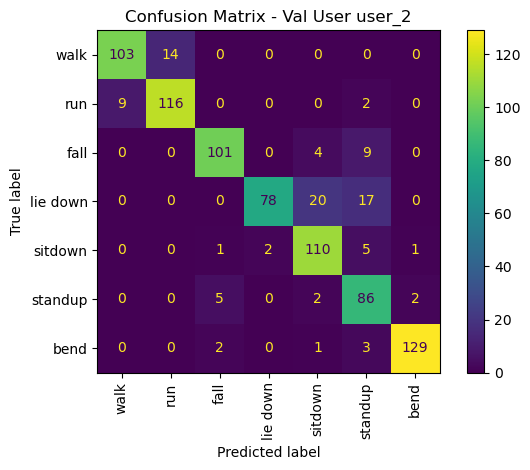

[23:21:22] INFO: Final metrics: accuracy=0.8796, f1=0.8752, recall=0.8776, precision=0.8855
[23:21:22] INFO: Training time: 337.3 seconds


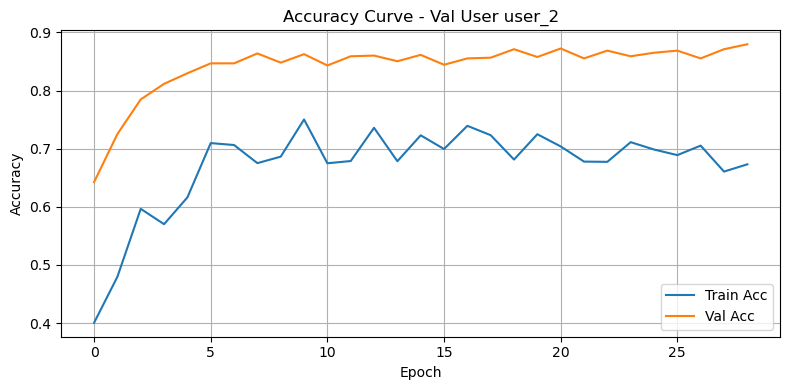

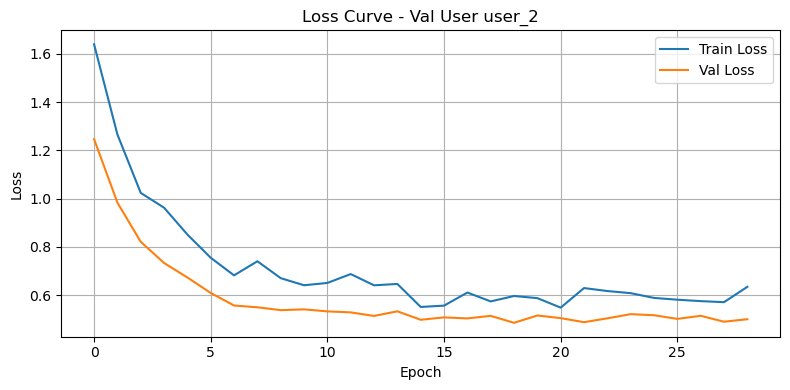

In [9]:
import os
# deterministic CUDA setup (if you want reproducibility); must come before torch import for cuBLAS
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

import re
import logging
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, recall_score, precision_score

# ====== CONFIGURATION ======
DATASET_ROOT = r'F:/Datasets/CSI-HAR-Dataset-Raspberry-Pi-4/CSI-HAR-Dataset'  # adjust if needed
ACTIVITIES = ['walk', 'run', 'fall', 'lie down', 'sitdown', 'standup', 'bend']
USERS = ['user_1', 'user_2', 'user_3']

TRAIN_USERS = ['user_1', 'user_3']
VAL_USER = 'user_2'

INPUT_DIM = 52
HIDDEN_DIM = 64
NUM_CLASSES = len(ACTIVITIES)
BATCH_SIZE = 64
EPOCHS = 150
PATIENCE = 10
LEARNING_RATE = 1e-4
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEED = 42
WINDOW_LEN = 400
STRIDE = 80

# ----- Replace / adjust these hyperparams -----
GAUSSIAN_SIGMA2 = 1e-4     # multiplicative noise variance from paper
SHIFT_STEP = 10            # fixed ±10 shift
MIXUP_ALPHA = 1.0          # paper's best alpha
MIXUP_PROB = 0.7           # reflection ratio: apply mixup with this probability
NOISE_COPIES = 3           # original + 3 noisy variants

# ----- New / replacement augmentation functions -----
def add_gaussian_noise_multiplicative(x, sigma2=GAUSSIAN_SIGMA2):
    """
    Multiplicative Gaussian noise: x + x * N(0, sigma2)
    x: tensor (B, T, C)
    """
    noise = torch.randn_like(x) * (sigma2 ** 0.5)
    return x + x * noise

def fixed_shift_augment_tensor(x, shift=SHIFT_STEP):
    # x: (T, C) torch tensor, returns tuple of (shifted_plus, shifted_minus)
    return torch.roll(x, shifts=shift, dims=0), torch.roll(x, shifts=-shift, dims=0)

def mixup_data(x, y, alpha=MIXUP_ALPHA):
    """
    Standard mixup. Returns mixed inputs, pair of targets, and lambda.
    """
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.0
    batch_size = x.size(0)
    if batch_size == 1:
        return x, y, y, lam
    index = torch.randperm(batch_size, device=x.device)
    x_shuffled = x[index]
    y_shuffled = y[index]
    mixed_x = lam * x + (1 - lam) * x_shuffled
    return mixed_x, y, y_shuffled, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

def augment_training_samples(window_label_pairs):
    """
    Expand training samples: original + multiplicative noise copies + fixed ±SHIFT_STEP shifts.
    Returns new list of (window, label) pairs.
    """
    augmented = []
    for arr, label in window_label_pairs:
        base = torch.tensor(arr, dtype=torch.float32)  # (W, C)
        # original
        augmented.append((arr, label))
        # multiplicative noise variants
        for _ in range(NOISE_COPIES):
            noisy = add_gaussian_noise_multiplicative(base.unsqueeze(0))  # (1, W, C)
            augmented.append((noisy[0].numpy(), label))
        # fixed shifts on original
        shift_p, shift_n = fixed_shift_augment_tensor(base)
        augmented.append((shift_p.numpy(), label))
        augmented.append((shift_n.numpy(), label))
    return augmented


# reproducibility
np.random.seed(SEED)
torch.manual_seed(SEED)
try:
    torch.use_deterministic_algorithms(True)
except Exception:
    pass
torch.backends.cudnn.benchmark = False

# logging
logging.basicConfig(
    level=logging.INFO,
    format='[%(asctime)s] %(levelname)s: %(message)s',
    datefmt='%H:%M:%S'
)
logger = logging.getLogger(__name__)



def load_windowed_data_by_user():
    """
    Returns dict: user -> list of (windowed_array, label_index)
    Each CSV file is normalized (per-column standardization) before windowing.
    Windows are created with stride and window length. No cross-file/global leakage.
    """
    user_windows = {u: [] for u in USERS}
    for activity in ACTIVITIES:
        logger.info(f"Loading activity '{activity}'")
        folder = os.path.join(DATASET_ROOT, activity)
        if not os.path.isdir(folder):
            logger.warning(f"Missing activity folder: {folder} (skipping '{activity}')")
            continue
        parts = activity.strip().split()
        if len(parts) > 1:
            activity_regex = r'[_ ]+'.join(re.escape(p) for p in parts)
        else:
            activity_regex = re.escape(activity)
        pattern = rf'^(user_\d+)_sample_\d+_{activity_regex}.*\.csv$'
        files = [f for f in os.listdir(folder)
                 if f.lower().endswith('.csv') and not f.lower().startswith('annotation')]
        for f in files:
            match = re.match(pattern, f, flags=re.IGNORECASE)
            if not match:
                continue
            user = match.group(1)
            if user not in USERS:
                continue
            label = ACTIVITIES.index(activity)
            full_path = os.path.join(folder, f)
            try:
                arr = pd.read_csv(full_path, header=None)
            except Exception as e:
                logger.warning(f"Failed to read '{full_path}': {e}")
                continue
            arr = arr.apply(pd.to_numeric, errors='coerce').values
            arr = arr[~np.isnan(arr).all(axis=1)]
            arr = arr[:, ~np.isnan(arr).all(axis=0)]
            if arr.shape[1] != INPUT_DIM:
                logger.debug(f"Skipping '{f}' due to unexpected dim {arr.shape}")
                continue
            if arr.shape[0] < WINDOW_LEN:
                continue  # too short for even one window

            # Per-file normalization (standardize each column independently)
            mean = np.nanmean(arr, axis=0, keepdims=True)
            std = np.nanstd(arr, axis=0, keepdims=True)
            std[std < 1e-6] = 1.0  # avoid division by zero
            arr = (arr - mean) / std  # shape (T, C)

            # Windowing
            n_windows = (arr.shape[0] - WINDOW_LEN) // STRIDE + 1
            for w in range(n_windows):
                start = w * STRIDE
                end = start + WINDOW_LEN
                if end > arr.shape[0]:
                    break
                window = arr[start:end, :]  # (WINDOW_LEN, INPUT_DIM)
                user_windows[user].append((window, label))
    return user_windows



class CSIDataset(Dataset):
    def __init__(self, window_label_pairs):
        if len(window_label_pairs) == 0:
            self.data = np.empty((0, 0, 0))
            self.labels = []
            logger.warning("[WARNING] Empty dataset initialized")
            return
        self.labels = [l for _, l in window_label_pairs]
        stack = np.stack([arr for arr, _ in window_label_pairs])  # (N, W, C)
        self.data = stack  # already normalized per-file
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32), self.labels[idx]


# ============== MODEL ===============
class CNNAttentionGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, cnn_channels=32, dropout=0.3):
        super().__init__()
        # CNN front-end: operate over (time, subcarrier) as a 2D “image”
        self.cnn = nn.Sequential(
            nn.Conv2d(1, cnn_channels, kernel_size=(3, 5), padding=(1, 2)),  # preserves T and C
            nn.ReLU(),
            nn.BatchNorm2d(cnn_channels),
            nn.MaxPool2d((1, 2))  # downsample subcarrier dimension by 2
        )
        # After conv+pool: shape (B, cnn_channels, T, input_dim//2)
        self.gru_input_dim = cnn_channels * (input_dim // 2)
        self.gru = nn.GRU(self.gru_input_dim, hidden_dim, batch_first=True)
        # attention layers (same as before)
        self.attn_query = nn.Linear(hidden_dim, hidden_dim)
        self.attn_key = nn.Linear(hidden_dim, hidden_dim)
        self.attn_value = nn.Linear(hidden_dim, hidden_dim)
        self.layer_norm = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        # x: (B, T, C) where C = original input_dim (subcarriers)
        B, T, C = x.shape
        x = x.unsqueeze(1)  # (B,1,T,C) so we can conv2d over time×subcarrier
        x = self.cnn(x)     # (B, F, T, C_new) where C_new = C//2
        B, F, T_new, C_new = x.shape
        # collapse feature maps into a sequence for GRU: (B, T_new, F * C_new)
        x = x.permute(0, 2, 1, 3).reshape(B, T_new, F * C_new)
        gru_out, _ = self.gru(x)  # (B, T_new, H)
        Q = self.attn_query(gru_out)
        K = self.attn_key(gru_out)
        V = self.attn_value(gru_out)
        attn_scores = torch.matmul(Q, K.transpose(1, 2)) / (Q.size(-1) ** 0.5)
        attn_weights = torch.softmax(attn_scores, dim=-1)
        attn_out = torch.matmul(attn_weights, V)  # (B, T_new, H)
        attn_out = self.layer_norm(attn_out + gru_out)
        attn_out = self.dropout(attn_out)
        pooled = attn_out.mean(dim=1)  # (B, H)
        logits = self.fc(pooled)
        return logits

# Evaluation helper
def evaluate(model, loader, criterion):
    model.eval()
    y_true, y_pred = [], []
    total_loss = 0.0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            out = model(xb)
            loss = criterion(out, yb)
            total_loss += loss.item() * xb.size(0)
            preds = out.argmax(dim=1).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(yb.cpu().numpy())
    avg_loss = total_loss / len(loader.dataset) if len(loader.dataset) > 0 else float('inf')
    accuracy = (np.array(y_true) == np.array(y_pred)).mean() if len(y_true) > 0 else 0.0
    return avg_loss, accuracy, y_true, y_pred

def main():
    logger.info("=== Starting main pipeline with paper-style augmentations ===")
    user_samples = load_windowed_data_by_user()

    # Build train/val sets: train = TRAIN_USERS; val = VAL_USER
    train_samples = []
    for u in TRAIN_USERS:
        train_samples += user_samples.get(u, [])
    # apply deterministic paper-style augmentation to training data
    train_samples = augment_training_samples(train_samples)

    val_samples = user_samples.get(VAL_USER, [])

    train_ds = CSIDataset(train_samples)
    val_ds = CSIDataset(val_samples)
    if len(train_ds) == 0 or len(val_ds) == 0:
        logger.error(f"Empty train or val set (train: {len(train_ds)}, val: {len(val_ds)}), aborting.")
        return

    logger.info(f"Number of train windows: {len(train_ds)}")
    logger.info(f"Number of val windows:   {len(val_ds)}")

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

    model = CNNAttentionGRU(INPUT_DIM, HIDDEN_DIM, NUM_CLASSES).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3
    )
    criterion = nn.CrossEntropyLoss()

    train_accs, val_accs, train_losses, val_losses = [], [], [], []
    best_val_loss = float('inf')
    best_epoch = 0
    patience_counter = 0
    best_model_state = None

    t0 = time.time()
    for epoch in range(1, EPOCHS + 1):
        model.train()
        epoch_loss = 0.0
        y_true_train, y_pred_train = [], []
        lam_accum = 0.0
        mixup_count = 0

        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            optimizer.zero_grad()

            # Decide whether to apply MixUp this batch
            if USE_MIXUP and torch.rand(1).item() < MIXUP_PROB:
                xb_mixed, y_a, y_b_shuffled, lam = mixup_data(xb, yb, MIXUP_ALPHA)
                out = model(xb_mixed)
                loss = mixup_criterion(criterion, out, y_a, y_b_shuffled, lam)
                lam_accum += lam
                mixup_count += 1
            else:
                out = model(xb)
                loss = criterion(out, yb)

            preds = out.argmax(dim=1)
            y_pred_train.extend(preds.cpu().numpy())
            y_true_train.extend(yb.cpu().numpy())

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * xb.size(0)

        train_loss = epoch_loss / len(train_ds)
        train_acc = (np.array(y_true_train) == np.array(y_pred_train)).mean()

        val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]['lr']

        mixup_info = ""
        if USE_MIXUP and mixup_count > 0:
            avg_lam = lam_accum / mixup_count
            mixup_info = f" | MixUp λ(avg): {avg_lam:.3f}"
        mixup_note = " (proxy)" if USE_MIXUP else ""

        logger.info(
            f"Epoch {epoch:02d}/{EPOCHS} | "
            f"Train Loss: {train_loss:.4f} | Train Acc{mixup_note}: {train_acc*100:.2f}% | "
            f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}% | LR: {current_lr:.1e}"
            + mixup_info
        )

        if val_loss < best_val_loss - 1e-5:
            best_val_loss = val_loss
            best_epoch = epoch
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                logger.info(f"Early stopping triggered at epoch {epoch}.")
                break

    elapsed = time.time() - t0
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    # Final evaluation
    val_loss, val_acc, y_true, y_pred = evaluate(model, val_loader, criterion)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_true, y_pred, average='macro', zero_division=0)
    prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
    acc = val_acc

    logger.info("\n--- Final Evaluation ---")
    logger.info(f"Best epoch: {best_epoch} (best val loss: {best_val_loss:.4f})")
    logger.info(classification_report(y_true, y_pred, target_names=ACTIVITIES, digits=3))
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=ACTIVITIES)
    disp.plot(xticks_rotation='vertical')
    plt.title(f'Confusion Matrix - Val User {VAL_USER}')
    plt.tight_layout()
    plt.show()

    logger.info(f'Final metrics: accuracy={acc:.4f}, f1={f1:.4f}, recall={rec:.4f}, precision={prec:.4f}')
    logger.info(f'Training time: {elapsed:.1f} seconds')

    # Curves
    plt.figure(figsize=(8, 4))
    plt.plot(train_accs, label='Train Acc')
    plt.plot(val_accs, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy Curve - Val User {VAL_USER}')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 4))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Loss Curve - Val User {VAL_USER}')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

    return {
        "results": [{
            "user_left_out": VAL_USER,
            "accuracy": acc,
            "f1": f1,
            "recall": rec,
            "precision": prec,
            "train_time": elapsed,
            "best_epoch": best_epoch
        }],
        "model": model,
        "best_epoch": best_epoch,
        "metrics": {
            "accuracy": acc,
            "f1": f1,
            "recall": rec,
            "precision": prec
        },
        "y_true": y_true,
        "y_pred": y_pred
    }

summary = main()


==== LEAVE-ONE-USER-OUT RESULTS SUMMARY ====


,accuracy,f1,recall,precision,train_time,best_epoch
user_left_out,,,,,,
user_2,0.879562,0.875202,0.877592,0.885524,337.334006,19



==== MEAN METRICS ====
      accuracy        f1    recall  precision  train_time
mean  0.879562  0.875202  0.877592   0.885524  337.334006

==== MEAN ± STD ====
      accuracy        f1    recall  precision
mean  0.879562  0.875202  0.877592   0.885524
std        NaN       NaN       NaN        NaN

==== MODEL ARCHITECTURE ====
CNNAttentionGRU(
  (cnn): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 5), stride=(1, 1), padding=(1, 2))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (gru): GRU(832, 64, batch_first=True)
  (attn_query): Linear(in_features=64, out_features=64, bias=True)
  (attn_key): Linear(in_features=64, out_features=64, bias=True)
  (attn_value): Linear(in_features=64, out_features=64, bias=True)
  (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (f

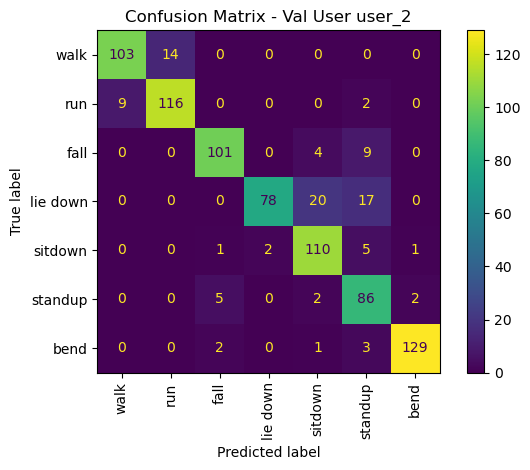

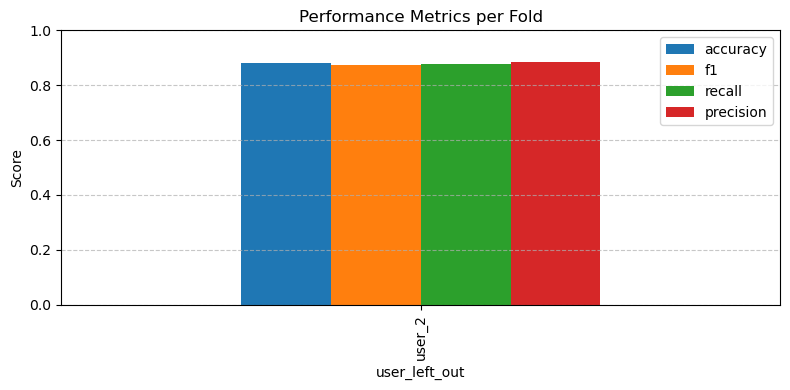

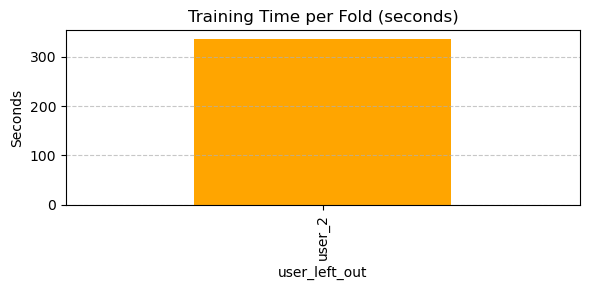

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# --- extract results ---
if 'summary' in globals() and isinstance(summary, dict):
    results = summary.get("results", [])
else:
    # fallback to legacy variables if summary not present
    try:
        results = [{
            "user_left_out": VAL_USER,
            "accuracy": acc,
            "f1": f1,
            "recall": rec,
            "precision": prec,
            "train_time": elapsed,
            "best_epoch": best_epoch
        }]
    except NameError as e:
        raise RuntimeError(f"Cannot build summary: missing variable {e}. Ensure summary or required metrics are in scope.")

# Build DataFrame
df = pd.DataFrame(results)
if "user_left_out" in df.columns:
    df.set_index("user_left_out", inplace=True)

# --- Summary tables ---
print("==== LEAVE-ONE-USER-OUT RESULTS SUMMARY ====")
display(df[['accuracy', 'f1', 'recall', 'precision', 'train_time', 'best_epoch']])

print("\n==== MEAN METRICS ====")
mean_metrics = df[['accuracy', 'f1', 'recall', 'precision', 'train_time']].mean()
print(mean_metrics.to_frame(name="mean").T)

print("\n==== MEAN ± STD ====")
agg = df[['accuracy', 'f1', 'recall', 'precision']].agg(['mean', 'std'])
print(agg)

# --- Model architecture & size ---
print("\n==== MODEL ARCHITECTURE ====")
model_obj = None
if 'summary' in globals():
    model_obj = summary.get('model', None)
if model_obj is None:
    model_obj = globals().get('model', None)
if model_obj is not None:
    print(model_obj)
    try:
        n_params = sum(p.numel() for p in model_obj.parameters())
        print(f"\nTotal parameters: {n_params:,}")
    except Exception:
        pass
else:
    print("Model object not found in scope.")

# --- Classification report & confusion matrix ---
# Prefer summary's y_true/y_pred then globals
y_true = None; y_pred = None
if 'summary' in globals():
    y_true = summary.get("y_true", None)
    y_pred = summary.get("y_pred", None)
if y_true is None or y_pred is None:
    y_true = globals().get('y_true', y_true)
    y_pred = globals().get('y_pred', y_pred)

if y_true is not None and y_pred is not None:
    print("\n==== CLASSIFICATION REPORT ====")
    print(classification_report(y_true, y_pred, target_names=ACTIVITIES, digits=3, zero_division=0))
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=ACTIVITIES)
    disp.plot(xticks_rotation='vertical')
    plt.title(f'Confusion Matrix - Val User {VAL_USER}')
    plt.tight_layout()
    plt.show()
else:
    print("\nNo prediction targets available; skipping classification report/confusion matrix.")

# --- Plots ---
fig, ax = plt.subplots(figsize=(8, 4))
df[['accuracy', 'f1', 'recall', 'precision']].plot(kind='bar', ax=ax)
ax.set_title("Performance Metrics per Fold")
ax.set_ylabel("Score")
ax.set_ylim(0, 1)
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 3))
if 'train_time' in df.columns:
    df['train_time'].plot(kind='bar', color='orange')
    plt.title("Training Time per Fold (seconds)")
    plt.ylabel("Seconds")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("\nNo 'train_time' column to plot.")


In [ ]:
Expirment 8

[20:23:38] INFO: === Starting main pipeline with paper-style augmentations ===
[20:23:38] INFO: Loading activity 'walk'
[20:23:39] INFO: Loading activity 'run'
[20:23:42] INFO: Loading activity 'fall'
[20:23:44] INFO: Loading activity 'lie down'
[20:23:46] INFO: Loading activity 'sitdown'
[20:23:48] INFO: Loading activity 'standup'
[20:23:49] INFO: Loading activity 'bend'
[20:23:53] INFO: Train windows before augmentation: 1571; after augmentation: 6284
[20:23:54] INFO: Number of train windows: 6284
[20:23:54] INFO: Number of val windows:   822
[20:24:15] INFO: Epoch 01/150 | Train Loss: 1.7321 | Train Acc (proxy): 31.78% | Val Loss: 1.4487 | Val Acc: 53.28% | LR: 1.0e-04 | MixUp λ(avg): 0.501
[20:24:23] INFO: Epoch 02/150 | Train Loss: 1.4069 | Train Acc (proxy): 44.43% | Val Loss: 1.1473 | Val Acc: 60.10% | LR: 1.0e-04 | MixUp λ(avg): 0.457
[20:24:30] INFO: Epoch 03/150 | Train Loss: 1.2202 | Train Acc (proxy): 52.72% | Val Loss: 1.0069 | Val Acc: 69.34% | LR: 1.0e-04 | MixUp λ(avg):

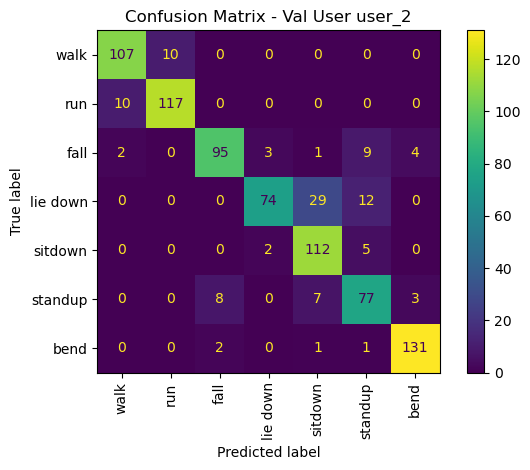

[20:31:42] INFO: Final metrics: accuracy=0.8674, f1=0.8607, recall=0.8621, precision=0.8712
[20:31:42] INFO: Training time: 454.3 seconds


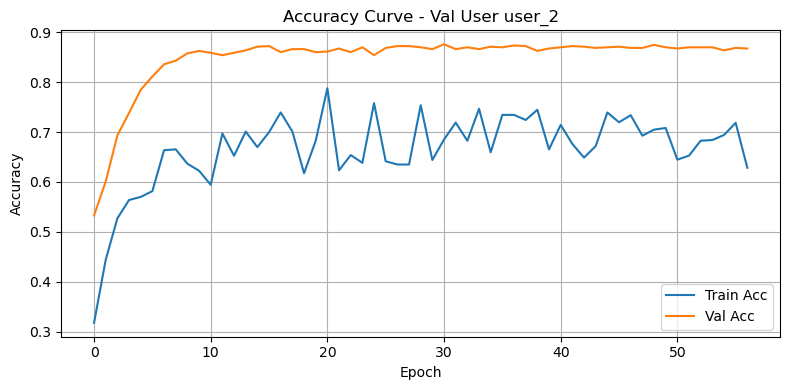

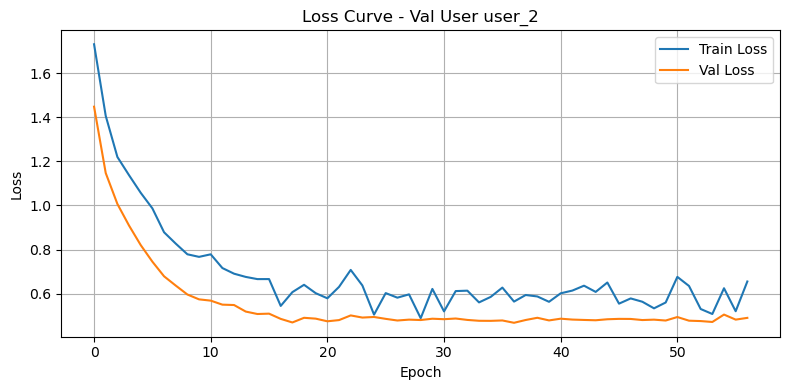

In [18]:
import os
# deterministic CUDA setup (if you want reproducibility); must come before torch import for cuBLAS
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

import re
import logging
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, recall_score, precision_score

# ====== CONFIGURATION ======
DATASET_ROOT = r'F:/Datasets/CSI-HAR-Dataset-Raspberry-Pi-4/CSI-HAR-Dataset'  # adjust if needed
ACTIVITIES = ['walk', 'run', 'fall', 'lie down', 'sitdown', 'standup', 'bend']
USERS = ['user_1', 'user_2', 'user_3']

TRAIN_USERS = ['user_1', 'user_3']
VAL_USER = 'user_2'

INPUT_DIM = 52
HIDDEN_DIM = 64
NUM_CLASSES = len(ACTIVITIES)
BATCH_SIZE = 64
EPOCHS = 150
PATIENCE = 20
LEARNING_RATE = 1e-4
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEED = 42
WINDOW_LEN = 400
STRIDE = 80

# ----- Replace / adjust these hyperparams -----
GAUSSIAN_SIGMA2 = 1e-4     # multiplicative noise variance from paper
SHIFT_STEP = 10            # fixed ±10 shift
MIXUP_ALPHA = 1.0          # paper's best alpha
MIXUP_PROB = 0.7           # reflection ratio: apply mixup with this probability
NOISE_COPIES = 3           # original + 3 noisy variants

# ----- New / replacement augmentation functions -----
def add_gaussian_noise_multiplicative(x, sigma2=GAUSSIAN_SIGMA2):
    """
    Multiplicative Gaussian noise: x + x * N(0, sigma2)
    x: tensor (B, T, C)
    """
    noise = torch.randn_like(x) * (sigma2 ** 0.5)
    return x + x * noise

def fixed_shift_augment_tensor(x, shift=SHIFT_STEP):
    # x: (T, C) torch tensor, returns tuple of (shifted_plus, shifted_minus)
    return torch.roll(x, shifts=shift, dims=0), torch.roll(x, shifts=-shift, dims=0)

def mixup_data(x, y, alpha=MIXUP_ALPHA):
    """
    Standard mixup. Returns mixed inputs, pair of targets, and lambda.
    """
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.0
    batch_size = x.size(0)
    if batch_size == 1:
        return x, y, y, lam
    index = torch.randperm(batch_size, device=x.device)
    x_shuffled = x[index]
    y_shuffled = y[index]
    mixed_x = lam * x + (1 - lam) * x_shuffled
    return mixed_x, y, y_shuffled, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

def augment_training_samples(window_label_pairs):
    """
    Expand training samples: original + multiplicative noise copies + fixed ±SHIFT_STEP shifts.
    Returns new list of (window, label) pairs.
    """
    augmented = []
    for arr, label in window_label_pairs:
        base = torch.tensor(arr, dtype=torch.float32)  # (W, C)
        # original
        augmented.append((arr, label))
        # multiplicative noise variants
        for _ in range(NOISE_COPIES):
            noisy = add_gaussian_noise_multiplicative(base.unsqueeze(0))  # (1, W, C)
            augmented.append((noisy[0].numpy(), label))
        # fixed shifts on original
        shift_p, shift_n = fixed_shift_augment_tensor(base)
        augmented.append((shift_p.numpy(), label))
        augmented.append((shift_n.numpy(), label))
    return augmented


# reproducibility
np.random.seed(SEED)
torch.manual_seed(SEED)
try:
    torch.use_deterministic_algorithms(True)
except Exception:
    pass
torch.backends.cudnn.benchmark = False

# logging
logging.basicConfig(
    level=logging.INFO,
    format='[%(asctime)s] %(levelname)s: %(message)s',
    datefmt='%H:%M:%S'
)
logger = logging.getLogger(__name__)



def load_windowed_data_by_user():
    """
    Returns dict: user -> list of (windowed_array, label_index)
    Each CSV file is normalized (per-column standardization) before windowing.
    Windows are created with stride and window length. No cross-file/global leakage.
    """
    user_windows = {u: [] for u in USERS}
    for activity in ACTIVITIES:
        logger.info(f"Loading activity '{activity}'")
        folder = os.path.join(DATASET_ROOT, activity)
        if not os.path.isdir(folder):
            logger.warning(f"Missing activity folder: {folder} (skipping '{activity}')")
            continue
        parts = activity.strip().split()
        if len(parts) > 1:
            activity_regex = r'[_ ]+'.join(re.escape(p) for p in parts)
        else:
            activity_regex = re.escape(activity)
        pattern = rf'^(user_\d+)_sample_\d+_{activity_regex}.*\.csv$'
        files = [f for f in os.listdir(folder)
                 if f.lower().endswith('.csv') and not f.lower().startswith('annotation')]
        for f in files:
            match = re.match(pattern, f, flags=re.IGNORECASE)
            if not match:
                continue
            user = match.group(1)
            if user not in USERS:
                continue
            label = ACTIVITIES.index(activity)
            full_path = os.path.join(folder, f)
            try:
                arr = pd.read_csv(full_path, header=None)
            except Exception as e:
                logger.warning(f"Failed to read '{full_path}': {e}")
                continue
            arr = arr.apply(pd.to_numeric, errors='coerce').values
            arr = arr[~np.isnan(arr).all(axis=1)]
            arr = arr[:, ~np.isnan(arr).all(axis=0)]
            if arr.shape[1] != INPUT_DIM:
                logger.debug(f"Skipping '{f}' due to unexpected dim {arr.shape}")
                continue
            if arr.shape[0] < WINDOW_LEN:
                continue  # too short for even one window

            # Per-file normalization (standardize each column independently)
            mean = np.nanmean(arr, axis=0, keepdims=True)
            std = np.nanstd(arr, axis=0, keepdims=True)
            std[std < 1e-6] = 1.0  # avoid division by zero
            arr = (arr - mean) / std  # shape (T, C)

            # Windowing
            n_windows = (arr.shape[0] - WINDOW_LEN) // STRIDE + 1
            for w in range(n_windows):
                start = w * STRIDE
                end = start + WINDOW_LEN
                if end > arr.shape[0]:
                    break
                window = arr[start:end, :]  # (WINDOW_LEN, INPUT_DIM)
                user_windows[user].append((window, label))
    return user_windows



class CSIDataset(Dataset):
    def __init__(self, window_label_pairs):
        if len(window_label_pairs) == 0:
            self.data = np.empty((0, 0, 0))
            self.labels = []
            logger.warning("[WARNING] Empty dataset initialized")
            return
        self.labels = [l for _, l in window_label_pairs]
        stack = np.stack([arr for arr, _ in window_label_pairs])  # (N, W, C)
        self.data = stack  # already normalized per-file
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32), self.labels[idx]


# ============== MODEL ===============
class CNNAttentionGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, cnn_channels=32, dropout=0.3):
        super().__init__()
        # CNN front-end: operate over (time, subcarrier) as a 2D “image”
        self.cnn = nn.Sequential(
            nn.Conv2d(1, cnn_channels, kernel_size=(3, 5), padding=(1, 2)),  # preserves T and C
            nn.ReLU(),
            nn.BatchNorm2d(cnn_channels),
            nn.MaxPool2d((1, 2))  # downsample subcarrier dimension by 2
        )
        # After conv+pool: shape (B, cnn_channels, T, input_dim//2)
        self.gru_input_dim = cnn_channels * (input_dim // 2)
        self.gru = nn.GRU(self.gru_input_dim, hidden_dim, batch_first=True)
        # attention layers (same as before)
        self.attn_query = nn.Linear(hidden_dim, hidden_dim)
        self.attn_key = nn.Linear(hidden_dim, hidden_dim)
        self.attn_value = nn.Linear(hidden_dim, hidden_dim)
        self.layer_norm = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        # x: (B, T, C) where C = original input_dim (subcarriers)
        B, T, C = x.shape
        x = x.unsqueeze(1)  # (B,1,T,C) so we can conv2d over time×subcarrier
        x = self.cnn(x)     # (B, F, T, C_new) where C_new = C//2
        B, F, T_new, C_new = x.shape
        # collapse feature maps into a sequence for GRU: (B, T_new, F * C_new)
        x = x.permute(0, 2, 1, 3).reshape(B, T_new, F * C_new)
        gru_out, _ = self.gru(x)  # (B, T_new, H)
        Q = self.attn_query(gru_out)
        K = self.attn_key(gru_out)
        V = self.attn_value(gru_out)
        attn_scores = torch.matmul(Q, K.transpose(1, 2)) / (Q.size(-1) ** 0.5)
        attn_weights = torch.softmax(attn_scores, dim=-1)
        attn_out = torch.matmul(attn_weights, V)  # (B, T_new, H)
        attn_out = self.layer_norm(attn_out + gru_out)
        attn_out = self.dropout(attn_out)
        pooled = attn_out.mean(dim=1)  # (B, H)
        logits = self.fc(pooled)
        return logits

# Evaluation helper
def evaluate(model, loader, criterion):
    model.eval()
    y_true, y_pred = [], []
    total_loss = 0.0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            out = model(xb)
            loss = criterion(out, yb)
            total_loss += loss.item() * xb.size(0)
            preds = out.argmax(dim=1).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(yb.cpu().numpy())
    avg_loss = total_loss / len(loader.dataset) if len(loader.dataset) > 0 else float('inf')
    accuracy = (np.array(y_true) == np.array(y_pred)).mean() if len(y_true) > 0 else 0.0
    return avg_loss, accuracy, y_true, y_pred

def augment_training_samples(samples):
    """
    Expand the training windows by applying shift and white noise augmentations
    per sample, keeping label the same. Does not do MixUp (that’s in-batch).
    """
    augmented = []
    for window, label in samples:
        augmented.append((window, label))  # original

        if USE_SHIFT:
            shift = np.random.randint(-MAX_SHIFT, MAX_SHIFT + 1)
            shifted = np.roll(window, shift, axis=0)
            augmented.append((shifted, label))

        if USE_WHITE_NOISE:
            signal_power = np.mean(window ** 2)
            snr = 10 ** (SNR_DB / 10)
            noise_power = signal_power / snr
            noise = np.random.normal(0, np.sqrt(noise_power), size=window.shape)
            noisy = window + noise
            augmented.append((noisy, label))

        if USE_SHIFT and USE_WHITE_NOISE:
            shift = np.random.randint(-MAX_SHIFT, MAX_SHIFT + 1)
            shifted = np.roll(window, shift, axis=0)
            signal_power = np.mean(shifted ** 2)
            snr = 10 ** (SNR_DB / 10)
            noise_power = signal_power / snr
            noise = np.random.normal(0, np.sqrt(noise_power), size=shifted.shape)
            shifted_noisy = shifted + noise
            augmented.append((shifted_noisy, label))

    return augmented


def main():
    logger.info("=== Starting main pipeline with paper-style augmentations ===")
    user_samples = load_windowed_data_by_user()

    # Build original train/val sets: train = TRAIN_USERS; val = VAL_USER
    train_samples = []
    for u in TRAIN_USERS:
        train_samples += user_samples.get(u, [])
    val_samples = user_samples.get(VAL_USER, [])

    if len(train_samples) == 0 or len(val_samples) == 0:
        logger.error(f"Empty base train or val samples (train: {len(train_samples)}, val: {len(val_samples)})")
        return

    # Expand train set via shift and noise augmentation (paper-style)
    expanded_train_samples = augment_training_samples(train_samples)
    logger.info(f"Train windows before augmentation: {len(train_samples)}; after augmentation: {len(expanded_train_samples)}")

    train_ds = CSIDataset(expanded_train_samples)
    val_ds = CSIDataset(val_samples)
    if len(train_ds) == 0 or len(val_ds) == 0:
        logger.error(f"Empty dataset after wrapping (train: {len(train_ds)}, val: {len(val_ds)}), aborting.")
        return

    logger.info(f"Number of train windows: {len(train_ds)}")
    logger.info(f"Number of val windows:   {len(val_ds)}")

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

    model = CNNAttentionGRU(INPUT_DIM, HIDDEN_DIM, NUM_CLASSES).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
    criterion = nn.CrossEntropyLoss()

    train_accs, val_accs, train_losses, val_losses = [], [], [], []
    best_val_loss = float('inf')
    best_epoch = 0
    patience_counter = 0
    best_model_state = None

    t0 = time.time()
    for epoch in range(1, EPOCHS + 1):
        model.train()
        epoch_loss = 0.0
        y_true_train, y_pred_train = [], []
        lam_accum = 0.0
        mixup_count = 0

        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)

            # In-batch MixUp application with probability
            apply_mix = USE_MIXUP and torch.rand(1).item() < MIXUP_PROB
            optimizer.zero_grad()

            if apply_mix:
                xb_mixed, y_a, y_b_shuffled, lam = mixup_data(xb, yb, MIXUP_ALPHA)
                out = model(xb_mixed)
                loss = mixup_criterion(criterion, out, y_a, y_b_shuffled, lam)
                lam_accum += lam
                mixup_count += 1
                preds = out.argmax(dim=1)
                # for proxy accuracy compare to original yb
                y_pred_train.extend(preds.cpu().numpy())
                y_true_train.extend(yb.cpu().numpy())
            else:
                # no MixUp: apply shift and noise augmentation on-the-fly if desired (optional)
                out = model(xb)
                loss = criterion(out, yb)
                preds = out.argmax(dim=1)
                y_pred_train.extend(preds.cpu().numpy())
                y_true_train.extend(yb.cpu().numpy())

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * xb.size(0)

        train_loss = epoch_loss / len(train_ds)
        train_acc = (np.array(y_true_train) == np.array(y_pred_train)).mean()

        val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]['lr']

        mixup_info = ""
        if USE_MIXUP and mixup_count > 0:
            avg_lam = lam_accum / mixup_count
            mixup_info = f" | MixUp λ(avg): {avg_lam:.3f}"
        mixup_note = " (proxy)" if USE_MIXUP else ""

        logger.info(
            f"Epoch {epoch:02d}/{EPOCHS} | "
            f"Train Loss: {train_loss:.4f} | Train Acc{mixup_note}: {train_acc*100:.2f}% | "
            f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}% | LR: {current_lr:.1e}"
            + mixup_info
        )

        if val_loss < best_val_loss - 1e-5:
            best_val_loss = val_loss
            best_epoch = epoch
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                logger.info(f"Early stopping triggered at epoch {epoch}.")
                break

    elapsed = time.time() - t0
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    # Final evaluation
    val_loss, val_acc, y_true, y_pred = evaluate(model, val_loader, criterion)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_true, y_pred, average='macro', zero_division=0)
    prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
    acc = val_acc

    logger.info("\n--- Final Evaluation ---")
    logger.info(f"Best epoch: {best_epoch} (best val loss: {best_val_loss:.4f})")
    logger.info(classification_report(y_true, y_pred, target_names=ACTIVITIES, digits=3))
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=ACTIVITIES)
    disp.plot(xticks_rotation='vertical')
    plt.title(f'Confusion Matrix - Val User {VAL_USER}')
    plt.tight_layout()
    plt.show()

    logger.info(f'Final metrics: accuracy={acc:.4f}, f1={f1:.4f}, recall={rec:.4f}, precision={prec:.4f}')
    logger.info(f'Training time: {elapsed:.1f} seconds')

    # Curves
    plt.figure(figsize=(8, 4))
    plt.plot(train_accs, label='Train Acc')
    plt.plot(val_accs, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy Curve - Val User {VAL_USER}')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 4))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Loss Curve - Val User {VAL_USER}')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

    return {
        "results": [{
            "user_left_out": VAL_USER,
            "accuracy": acc,
            "f1": f1,
            "recall": rec,
            "precision": prec,
            "train_time": elapsed,
            "best_epoch": best_epoch
        }],
        "model": model,
        "best_epoch": best_epoch,
        "metrics": {
            "accuracy": acc,
            "f1": f1,
            "recall": rec,
            "precision": prec
        },
        "y_true": y_true,
        "y_pred": y_pred
    }

summary = main()


==== LEAVE-ONE-USER-OUT RESULTS SUMMARY ====


,accuracy,f1,recall,precision,train_time,best_epoch
user_left_out,,,,,,
user_2,0.867397,0.860685,0.862096,0.871174,454.291838,37



==== MEAN METRICS ====
      accuracy        f1    recall  precision  train_time
mean  0.867397  0.860685  0.862096   0.871174  454.291838

==== MEAN ± STD ====
      accuracy        f1    recall  precision
mean  0.867397  0.860685  0.862096   0.871174
std        NaN       NaN       NaN        NaN

==== MODEL ARCHITECTURE ====
CNNAttentionGRU(
  (cnn): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 5), stride=(1, 1), padding=(1, 2))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (gru): GRU(832, 64, batch_first=True)
  (attn_query): Linear(in_features=64, out_features=64, bias=True)
  (attn_key): Linear(in_features=64, out_features=64, bias=True)
  (attn_value): Linear(in_features=64, out_features=64, bias=True)
  (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (f

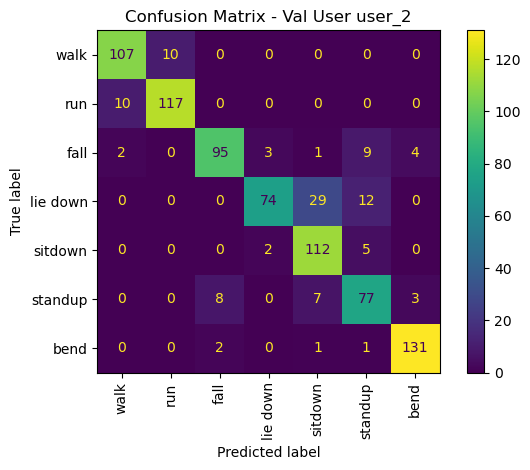

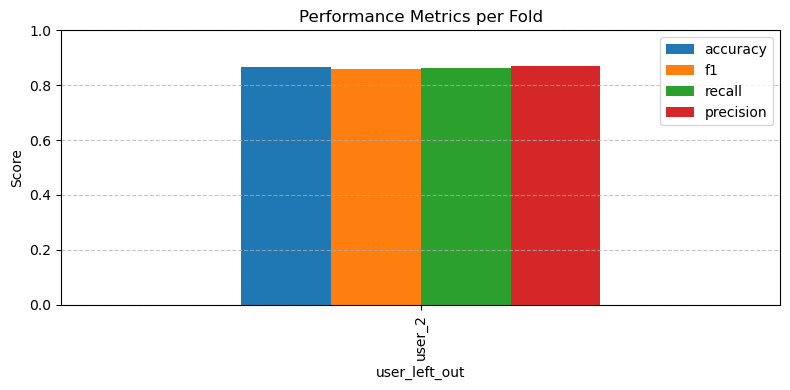

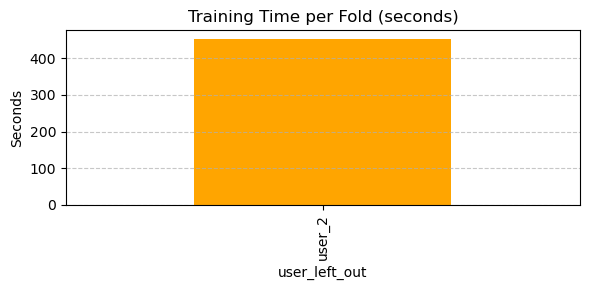

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# --- extract results ---
if 'summary' in globals() and isinstance(summary, dict):
    results = summary.get("results", [])
else:
    # fallback to legacy variables if summary not present
    try:
        results = [{
            "user_left_out": VAL_USER,
            "accuracy": acc,
            "f1": f1,
            "recall": rec,
            "precision": prec,
            "train_time": elapsed,
            "best_epoch": best_epoch
        }]
    except NameError as e:
        raise RuntimeError(f"Cannot build summary: missing variable {e}. Ensure summary or required metrics are in scope.")

# Build DataFrame
df = pd.DataFrame(results)
if "user_left_out" in df.columns:
    df.set_index("user_left_out", inplace=True)

# --- Summary tables ---
print("==== LEAVE-ONE-USER-OUT RESULTS SUMMARY ====")
display(df[['accuracy', 'f1', 'recall', 'precision', 'train_time', 'best_epoch']])

print("\n==== MEAN METRICS ====")
mean_metrics = df[['accuracy', 'f1', 'recall', 'precision', 'train_time']].mean()
print(mean_metrics.to_frame(name="mean").T)

print("\n==== MEAN ± STD ====")
agg = df[['accuracy', 'f1', 'recall', 'precision']].agg(['mean', 'std'])
print(agg)

# --- Model architecture & size ---
print("\n==== MODEL ARCHITECTURE ====")
model_obj = None
if 'summary' in globals():
    model_obj = summary.get('model', None)
if model_obj is None:
    model_obj = globals().get('model', None)
if model_obj is not None:
    print(model_obj)
    try:
        n_params = sum(p.numel() for p in model_obj.parameters())
        print(f"\nTotal parameters: {n_params:,}")
    except Exception:
        pass
else:
    print("Model object not found in scope.")

# --- Classification report & confusion matrix ---
# Prefer summary's y_true/y_pred then globals
y_true = None; y_pred = None
if 'summary' in globals():
    y_true = summary.get("y_true", None)
    y_pred = summary.get("y_pred", None)
if y_true is None or y_pred is None:
    y_true = globals().get('y_true', y_true)
    y_pred = globals().get('y_pred', y_pred)

if y_true is not None and y_pred is not None:
    print("\n==== CLASSIFICATION REPORT ====")
    print(classification_report(y_true, y_pred, target_names=ACTIVITIES, digits=3, zero_division=0))
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=ACTIVITIES)
    disp.plot(xticks_rotation='vertical')
    plt.title(f'Confusion Matrix - Val User {VAL_USER}')
    plt.tight_layout()
    plt.show()
else:
    print("\nNo prediction targets available; skipping classification report/confusion matrix.")

# --- Plots ---
fig, ax = plt.subplots(figsize=(8, 4))
df[['accuracy', 'f1', 'recall', 'precision']].plot(kind='bar', ax=ax)
ax.set_title("Performance Metrics per Fold")
ax.set_ylabel("Score")
ax.set_ylim(0, 1)
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 3))
if 'train_time' in df.columns:
    df['train_time'].plot(kind='bar', color='orange')
    plt.title("Training Time per Fold (seconds)")
    plt.ylabel("Seconds")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("\nNo 'train_time' column to plot.")


In [ ]:
hidden dimension 64

[00:07:21] INFO: === Starting main pipeline with paper-style augmentations ===
[00:07:21] INFO: Loading activity 'walk'
[00:07:22] INFO: Loading activity 'run'
[00:07:22] INFO: Loading activity 'fall'
[00:07:23] INFO: Loading activity 'lie down'
[00:07:24] INFO: Loading activity 'sitdown'
[00:07:25] INFO: Loading activity 'standup'
[00:07:26] INFO: Loading activity 'bend'
[00:07:29] INFO: Train windows before augmentation: 1571; after augmentation: 6284
[00:07:30] INFO: Number of train windows: 6284
[00:07:30] INFO: Number of val windows:   822
[00:07:42] INFO: Epoch 01/150 | Train Loss: 1.6395 | Train Acc (proxy): 39.16% | Val Loss: 1.2974 | Val Acc: 59.25% | LR: 1.0e-04 | MixUp λ(avg): 0.503
[00:07:53] INFO: Epoch 02/150 | Train Loss: 1.3080 | Train Acc (proxy): 47.10% | Val Loss: 1.0634 | Val Acc: 69.59% | LR: 1.0e-04 | MixUp λ(avg): 0.445
[00:08:05] INFO: Epoch 03/150 | Train Loss: 1.1676 | Train Acc (proxy): 54.28% | Val Loss: 0.9299 | Val Acc: 73.60% | LR: 1.0e-04 | MixUp λ(avg):

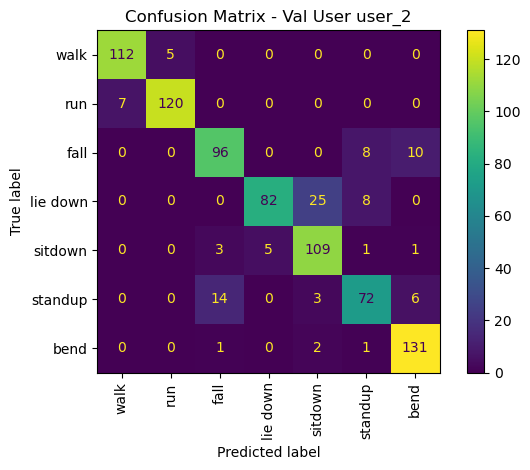

[00:12:56] INFO: Final metrics: accuracy=0.8783, f1=0.8721, recall=0.8716, precision=0.8793
[00:12:56] INFO: Training time: 325.7 seconds


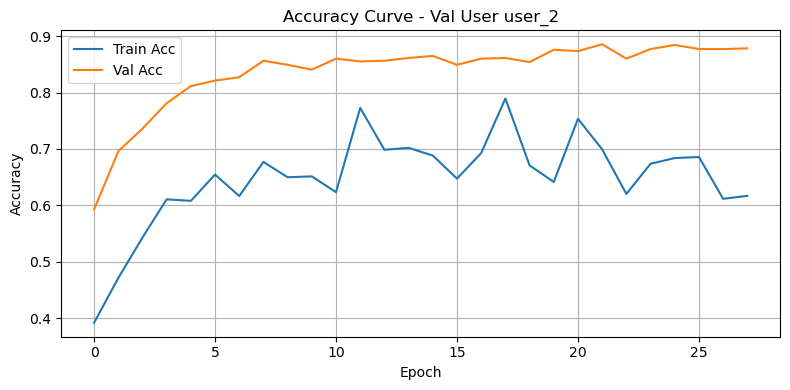

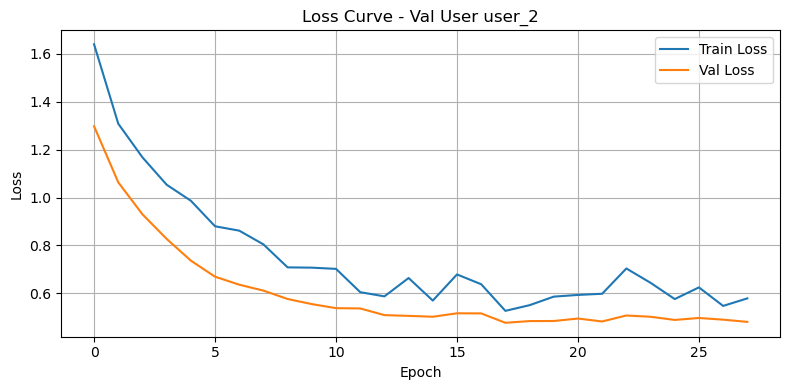

In [13]:
import os
# deterministic CUDA setup (if you want reproducibility); must come before torch import for cuBLAS
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

import re
import logging
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, recall_score, precision_score

# ====== CONFIGURATION ======
DATASET_ROOT = r'F:/Datasets/CSI-HAR-Dataset-Raspberry-Pi-4/CSI-HAR-Dataset'  # adjust if needed
ACTIVITIES = ['walk', 'run', 'fall', 'lie down', 'sitdown', 'standup', 'bend']
USERS = ['user_1', 'user_2', 'user_3']

TRAIN_USERS = ['user_1', 'user_3']
VAL_USER = 'user_2'

INPUT_DIM = 52
HIDDEN_DIM = 64
NUM_CLASSES = len(ACTIVITIES)
BATCH_SIZE = 64
EPOCHS = 150
PATIENCE = 10
LEARNING_RATE = 1e-4
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEED = 42
WINDOW_LEN = 400
STRIDE = 80

# ----- Replace / adjust these hyperparams -----
GAUSSIAN_SIGMA2 = 1e-4     # multiplicative noise variance from paper
SHIFT_STEP = 10            # fixed ±10 shift
MIXUP_ALPHA = 1.0          # paper's best alpha
MIXUP_PROB = 0.7           # reflection ratio: apply mixup with this probability
NOISE_COPIES = 3           # original + 3 noisy variants

# ----- New / replacement augmentation functions -----
def add_gaussian_noise_multiplicative(x, sigma2=GAUSSIAN_SIGMA2):
    """
    Multiplicative Gaussian noise: x + x * N(0, sigma2)
    x: tensor (B, T, C)
    """
    noise = torch.randn_like(x) * (sigma2 ** 0.5)
    return x + x * noise

def fixed_shift_augment_tensor(x, shift=SHIFT_STEP):
    # x: (T, C) torch tensor, returns tuple of (shifted_plus, shifted_minus)
    return torch.roll(x, shifts=shift, dims=0), torch.roll(x, shifts=-shift, dims=0)

def mixup_data(x, y, alpha=MIXUP_ALPHA):
    """
    Standard mixup. Returns mixed inputs, pair of targets, and lambda.
    """
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.0
    batch_size = x.size(0)
    if batch_size == 1:
        return x, y, y, lam
    index = torch.randperm(batch_size, device=x.device)
    x_shuffled = x[index]
    y_shuffled = y[index]
    mixed_x = lam * x + (1 - lam) * x_shuffled
    return mixed_x, y, y_shuffled, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

def augment_training_samples(window_label_pairs):
    """
    Expand training samples: original + multiplicative noise copies + fixed ±SHIFT_STEP shifts.
    Returns new list of (window, label) pairs.
    """
    augmented = []
    for arr, label in window_label_pairs:
        base = torch.tensor(arr, dtype=torch.float32)  # (W, C)
        # original
        augmented.append((arr, label))
        # multiplicative noise variants
        for _ in range(NOISE_COPIES):
            noisy = add_gaussian_noise_multiplicative(base.unsqueeze(0))  # (1, W, C)
            augmented.append((noisy[0].numpy(), label))
        # fixed shifts on original
        shift_p, shift_n = fixed_shift_augment_tensor(base)
        augmented.append((shift_p.numpy(), label))
        augmented.append((shift_n.numpy(), label))
    return augmented


# reproducibility
np.random.seed(SEED)
torch.manual_seed(SEED)
try:
    torch.use_deterministic_algorithms(True)
except Exception:
    pass
torch.backends.cudnn.benchmark = False

# logging
logging.basicConfig(
    level=logging.INFO,
    format='[%(asctime)s] %(levelname)s: %(message)s',
    datefmt='%H:%M:%S'
)
logger = logging.getLogger(__name__)



def load_windowed_data_by_user():
    """
    Returns dict: user -> list of (windowed_array, label_index)
    Each CSV file is normalized (per-column standardization) before windowing.
    Windows are created with stride and window length. No cross-file/global leakage.
    """
    user_windows = {u: [] for u in USERS}
    for activity in ACTIVITIES:
        logger.info(f"Loading activity '{activity}'")
        folder = os.path.join(DATASET_ROOT, activity)
        if not os.path.isdir(folder):
            logger.warning(f"Missing activity folder: {folder} (skipping '{activity}')")
            continue
        parts = activity.strip().split()
        if len(parts) > 1:
            activity_regex = r'[_ ]+'.join(re.escape(p) for p in parts)
        else:
            activity_regex = re.escape(activity)
        pattern = rf'^(user_\d+)_sample_\d+_{activity_regex}.*\.csv$'
        files = [f for f in os.listdir(folder)
                 if f.lower().endswith('.csv') and not f.lower().startswith('annotation')]
        for f in files:
            match = re.match(pattern, f, flags=re.IGNORECASE)
            if not match:
                continue
            user = match.group(1)
            if user not in USERS:
                continue
            label = ACTIVITIES.index(activity)
            full_path = os.path.join(folder, f)
            try:
                arr = pd.read_csv(full_path, header=None)
            except Exception as e:
                logger.warning(f"Failed to read '{full_path}': {e}")
                continue
            arr = arr.apply(pd.to_numeric, errors='coerce').values
            arr = arr[~np.isnan(arr).all(axis=1)]
            arr = arr[:, ~np.isnan(arr).all(axis=0)]
            if arr.shape[1] != INPUT_DIM:
                logger.debug(f"Skipping '{f}' due to unexpected dim {arr.shape}")
                continue
            if arr.shape[0] < WINDOW_LEN:
                continue  # too short for even one window

            # Per-file normalization (standardize each column independently)
            mean = np.nanmean(arr, axis=0, keepdims=True)
            std = np.nanstd(arr, axis=0, keepdims=True)
            std[std < 1e-6] = 1.0  # avoid division by zero
            arr = (arr - mean) / std  # shape (T, C)

            # Windowing
            n_windows = (arr.shape[0] - WINDOW_LEN) // STRIDE + 1
            for w in range(n_windows):
                start = w * STRIDE
                end = start + WINDOW_LEN
                if end > arr.shape[0]:
                    break
                window = arr[start:end, :]  # (WINDOW_LEN, INPUT_DIM)
                user_windows[user].append((window, label))
    return user_windows



class CSIDataset(Dataset):
    def __init__(self, window_label_pairs):
        if len(window_label_pairs) == 0:
            self.data = np.empty((0, 0, 0))
            self.labels = []
            logger.warning("[WARNING] Empty dataset initialized")
            return
        self.labels = [l for _, l in window_label_pairs]
        stack = np.stack([arr for arr, _ in window_label_pairs])  # (N, W, C)
        self.data = stack  # already normalized per-file
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32), self.labels[idx]


# ============== MODEL ===============
class CNNAttentionGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, cnn_channels=64, dropout=0.3):
        super().__init__()
        # CNN front-end: operate over (time, subcarrier) as a 2D “image”
        self.cnn = nn.Sequential(
            nn.Conv2d(1, cnn_channels, kernel_size=(3, 5), padding=(1, 2)),  # preserves T and C
            nn.ReLU(),
            nn.BatchNorm2d(cnn_channels),
            nn.MaxPool2d((1, 2))  # downsample subcarrier dimension by 2
        )
        # After conv+pool: shape (B, cnn_channels, T, input_dim//2)
        self.gru_input_dim = cnn_channels * (input_dim // 2)
        self.gru = nn.GRU(self.gru_input_dim, hidden_dim, batch_first=True)
        # attention layers (same as before)
        self.attn_query = nn.Linear(hidden_dim, hidden_dim)
        self.attn_key = nn.Linear(hidden_dim, hidden_dim)
        self.attn_value = nn.Linear(hidden_dim, hidden_dim)
        self.layer_norm = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        # x: (B, T, C) where C = original input_dim (subcarriers)
        B, T, C = x.shape
        x = x.unsqueeze(1)  # (B,1,T,C) so we can conv2d over time×subcarrier
        x = self.cnn(x)     # (B, F, T, C_new) where C_new = C//2
        B, F, T_new, C_new = x.shape
        # collapse feature maps into a sequence for GRU: (B, T_new, F * C_new)
        x = x.permute(0, 2, 1, 3).reshape(B, T_new, F * C_new)
        gru_out, _ = self.gru(x)  # (B, T_new, H)
        Q = self.attn_query(gru_out)
        K = self.attn_key(gru_out)
        V = self.attn_value(gru_out)
        attn_scores = torch.matmul(Q, K.transpose(1, 2)) / (Q.size(-1) ** 0.5)
        attn_weights = torch.softmax(attn_scores, dim=-1)
        attn_out = torch.matmul(attn_weights, V)  # (B, T_new, H)
        attn_out = self.layer_norm(attn_out + gru_out)
        attn_out = self.dropout(attn_out)
        pooled = attn_out.mean(dim=1)  # (B, H)
        logits = self.fc(pooled)
        return logits

# Evaluation helper
def evaluate(model, loader, criterion):
    model.eval()
    y_true, y_pred = [], []
    total_loss = 0.0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            out = model(xb)
            loss = criterion(out, yb)
            total_loss += loss.item() * xb.size(0)
            preds = out.argmax(dim=1).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(yb.cpu().numpy())
    avg_loss = total_loss / len(loader.dataset) if len(loader.dataset) > 0 else float('inf')
    accuracy = (np.array(y_true) == np.array(y_pred)).mean() if len(y_true) > 0 else 0.0
    return avg_loss, accuracy, y_true, y_pred

def augment_training_samples(samples):
    """
    Expand the training windows by applying shift and white noise augmentations
    per sample, keeping label the same. Does not do MixUp (that’s in-batch).
    """
    augmented = []
    for window, label in samples:
        augmented.append((window, label))  # original

        if USE_SHIFT:
            shift = np.random.randint(-MAX_SHIFT, MAX_SHIFT + 1)
            shifted = np.roll(window, shift, axis=0)
            augmented.append((shifted, label))

        if USE_WHITE_NOISE:
            signal_power = np.mean(window ** 2)
            snr = 10 ** (SNR_DB / 10)
            noise_power = signal_power / snr
            noise = np.random.normal(0, np.sqrt(noise_power), size=window.shape)
            noisy = window + noise
            augmented.append((noisy, label))

        if USE_SHIFT and USE_WHITE_NOISE:
            shift = np.random.randint(-MAX_SHIFT, MAX_SHIFT + 1)
            shifted = np.roll(window, shift, axis=0)
            signal_power = np.mean(shifted ** 2)
            snr = 10 ** (SNR_DB / 10)
            noise_power = signal_power / snr
            noise = np.random.normal(0, np.sqrt(noise_power), size=shifted.shape)
            shifted_noisy = shifted + noise
            augmented.append((shifted_noisy, label))

    return augmented


def main():
    logger.info("=== Starting main pipeline with paper-style augmentations ===")
    user_samples = load_windowed_data_by_user()

    # Build original train/val sets: train = TRAIN_USERS; val = VAL_USER
    train_samples = []
    for u in TRAIN_USERS:
        train_samples += user_samples.get(u, [])
    val_samples = user_samples.get(VAL_USER, [])

    if len(train_samples) == 0 or len(val_samples) == 0:
        logger.error(f"Empty base train or val samples (train: {len(train_samples)}, val: {len(val_samples)})")
        return

    # Expand train set via shift and noise augmentation (paper-style)
    expanded_train_samples = augment_training_samples(train_samples)
    logger.info(f"Train windows before augmentation: {len(train_samples)}; after augmentation: {len(expanded_train_samples)}")

    train_ds = CSIDataset(expanded_train_samples)
    val_ds = CSIDataset(val_samples)
    if len(train_ds) == 0 or len(val_ds) == 0:
        logger.error(f"Empty dataset after wrapping (train: {len(train_ds)}, val: {len(val_ds)}), aborting.")
        return

    logger.info(f"Number of train windows: {len(train_ds)}")
    logger.info(f"Number of val windows:   {len(val_ds)}")

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

    model = CNNAttentionGRU(INPUT_DIM, HIDDEN_DIM, NUM_CLASSES).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
    criterion = nn.CrossEntropyLoss()

    train_accs, val_accs, train_losses, val_losses = [], [], [], []
    best_val_loss = float('inf')
    best_epoch = 0
    patience_counter = 0
    best_model_state = None

    t0 = time.time()
    for epoch in range(1, EPOCHS + 1):
        model.train()
        epoch_loss = 0.0
        y_true_train, y_pred_train = [], []
        lam_accum = 0.0
        mixup_count = 0

        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)

            # In-batch MixUp application with probability
            apply_mix = USE_MIXUP and torch.rand(1).item() < MIXUP_PROB
            optimizer.zero_grad()

            if apply_mix:
                xb_mixed, y_a, y_b_shuffled, lam = mixup_data(xb, yb, MIXUP_ALPHA)
                out = model(xb_mixed)
                loss = mixup_criterion(criterion, out, y_a, y_b_shuffled, lam)
                lam_accum += lam
                mixup_count += 1
                preds = out.argmax(dim=1)
                # for proxy accuracy compare to original yb
                y_pred_train.extend(preds.cpu().numpy())
                y_true_train.extend(yb.cpu().numpy())
            else:
                # no MixUp: apply shift and noise augmentation on-the-fly if desired (optional)
                out = model(xb)
                loss = criterion(out, yb)
                preds = out.argmax(dim=1)
                y_pred_train.extend(preds.cpu().numpy())
                y_true_train.extend(yb.cpu().numpy())

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * xb.size(0)

        train_loss = epoch_loss / len(train_ds)
        train_acc = (np.array(y_true_train) == np.array(y_pred_train)).mean()

        val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]['lr']

        mixup_info = ""
        if USE_MIXUP and mixup_count > 0:
            avg_lam = lam_accum / mixup_count
            mixup_info = f" | MixUp λ(avg): {avg_lam:.3f}"
        mixup_note = " (proxy)" if USE_MIXUP else ""

        logger.info(
            f"Epoch {epoch:02d}/{EPOCHS} | "
            f"Train Loss: {train_loss:.4f} | Train Acc{mixup_note}: {train_acc*100:.2f}% | "
            f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}% | LR: {current_lr:.1e}"
            + mixup_info
        )

        if val_loss < best_val_loss - 1e-5:
            best_val_loss = val_loss
            best_epoch = epoch
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                logger.info(f"Early stopping triggered at epoch {epoch}.")
                break

    elapsed = time.time() - t0
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    # Final evaluation
    val_loss, val_acc, y_true, y_pred = evaluate(model, val_loader, criterion)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_true, y_pred, average='macro', zero_division=0)
    prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
    acc = val_acc

    logger.info("\n--- Final Evaluation ---")
    logger.info(f"Best epoch: {best_epoch} (best val loss: {best_val_loss:.4f})")
    logger.info(classification_report(y_true, y_pred, target_names=ACTIVITIES, digits=3))
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=ACTIVITIES)
    disp.plot(xticks_rotation='vertical')
    plt.title(f'Confusion Matrix - Val User {VAL_USER}')
    plt.tight_layout()
    plt.show()

    logger.info(f'Final metrics: accuracy={acc:.4f}, f1={f1:.4f}, recall={rec:.4f}, precision={prec:.4f}')
    logger.info(f'Training time: {elapsed:.1f} seconds')

    # Curves
    plt.figure(figsize=(8, 4))
    plt.plot(train_accs, label='Train Acc')
    plt.plot(val_accs, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy Curve - Val User {VAL_USER}')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 4))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Loss Curve - Val User {VAL_USER}')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

    return {
        "results": [{
            "user_left_out": VAL_USER,
            "accuracy": acc,
            "f1": f1,
            "recall": rec,
            "precision": prec,
            "train_time": elapsed,
            "best_epoch": best_epoch
        }],
        "model": model,
        "best_epoch": best_epoch,
        "metrics": {
            "accuracy": acc,
            "f1": f1,
            "recall": rec,
            "precision": prec
        },
        "y_true": y_true,
        "y_pred": y_pred
    }

summary = main()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# --- extract results ---
if 'summary' in globals() and isinstance(summary, dict):
    results = summary.get("results", [])
else:
    # fallback to legacy variables if summary not present
    try:
        results = [{
            "user_left_out": VAL_USER,
            "accuracy": acc,
            "f1": f1,
            "recall": rec,
            "precision": prec,
            "train_time": elapsed,
            "best_epoch": best_epoch
        }]
    except NameError as e:
        raise RuntimeError(f"Cannot build summary: missing variable {e}. Ensure summary or required metrics are in scope.")

# Build DataFrame
df = pd.DataFrame(results)
if "user_left_out" in df.columns:
    df.set_index("user_left_out", inplace=True)

# --- Summary tables ---
print("==== LEAVE-ONE-USER-OUT RESULTS SUMMARY ====")
display(df[['accuracy', 'f1', 'recall', 'precision', 'train_time', 'best_epoch']])

print("\n==== MEAN METRICS ====")
mean_metrics = df[['accuracy', 'f1', 'recall', 'precision', 'train_time']].mean()
print(mean_metrics.to_frame(name="mean").T)

print("\n==== MEAN ± STD ====")
agg = df[['accuracy', 'f1', 'recall', 'precision']].agg(['mean', 'std'])
print(agg)

# --- Model architecture & size ---
print("\n==== MODEL ARCHITECTURE ====")
model_obj = None
if 'summary' in globals():
    model_obj = summary.get('model', None)
if model_obj is None:
    model_obj = globals().get('model', None)
if model_obj is not None:
    print(model_obj)
    try:
        n_params = sum(p.numel() for p in model_obj.parameters())
        print(f"\nTotal parameters: {n_params:,}")
    except Exception:
        pass
else:
    print("Model object not found in scope.")

# --- Classification report & confusion matrix ---
# Prefer summary's y_true/y_pred then globals
y_true = None; y_pred = None
if 'summary' in globals():
    y_true = summary.get("y_true", None)
    y_pred = summary.get("y_pred", None)
if y_true is None or y_pred is None:
    y_true = globals().get('y_true', y_true)
    y_pred = globals().get('y_pred', y_pred)

if y_true is not None and y_pred is not None:
    print("\n==== CLASSIFICATION REPORT ====")
    print(classification_report(y_true, y_pred, target_names=ACTIVITIES, digits=3, zero_division=0))
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=ACTIVITIES)
    disp.plot(xticks_rotation='vertical')
    plt.title(f'Confusion Matrix - Val User {VAL_USER}')
    plt.tight_layout()
    plt.show()
else:
    print("\nNo prediction targets available; skipping classification report/confusion matrix.")

# --- Plots ---
fig, ax = plt.subplots(figsize=(8, 4))
df[['accuracy', 'f1', 'recall', 'precision']].plot(kind='bar', ax=ax)
ax.set_title("Performance Metrics per Fold")
ax.set_ylabel("Score")
ax.set_ylim(0, 1)
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 3))
if 'train_time' in df.columns:
    df['train_time'].plot(kind='bar', color='orange')
    plt.title("Training Time per Fold (seconds)")
    plt.ylabel("Seconds")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("\nNo 'train_time' column to plot.")


In [ ]:
128 hidden layer dimensions

[11:19:33] INFO: === Starting main pipeline with paper-style augmentations ===
[11:19:33] INFO: Loading activity 'walk'
[11:19:35] INFO: Loading activity 'run'
[11:19:37] INFO: Loading activity 'fall'
[11:19:39] INFO: Loading activity 'lie down'
[11:19:41] INFO: Loading activity 'sitdown'
[11:19:43] INFO: Loading activity 'standup'
[11:19:44] INFO: Loading activity 'bend'
[11:19:49] INFO: Train windows before augmentation: 1571; after augmentation: 6284
[11:19:50] INFO: Number of train windows: 6284
[11:19:50] INFO: Number of val windows:   822
[11:23:53] INFO: Epoch 01/150 | Train Loss: 1.6198 | Train Acc (proxy): 35.53% | Val Loss: 1.2555 | Val Acc: 61.19% | LR: 1.0e-04 | MixUp λ(avg): 0.497
[11:27:53] INFO: Epoch 02/150 | Train Loss: 1.2900 | Train Acc (proxy): 50.99% | Val Loss: 1.0436 | Val Acc: 68.86% | LR: 1.0e-04 | MixUp λ(avg): 0.456
[11:31:47] INFO: Epoch 03/150 | Train Loss: 1.1310 | Train Acc (proxy): 57.03% | Val Loss: 0.9282 | Val Acc: 74.09% | LR: 1.0e-04 | MixUp λ(avg):

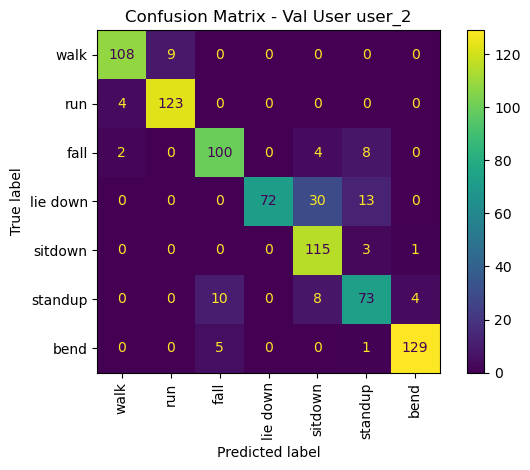

[13:09:32] INFO: Final metrics: accuracy=0.8759, f1=0.8682, recall=0.8693, precision=0.8841
[13:09:32] INFO: Training time: 6568.2 seconds


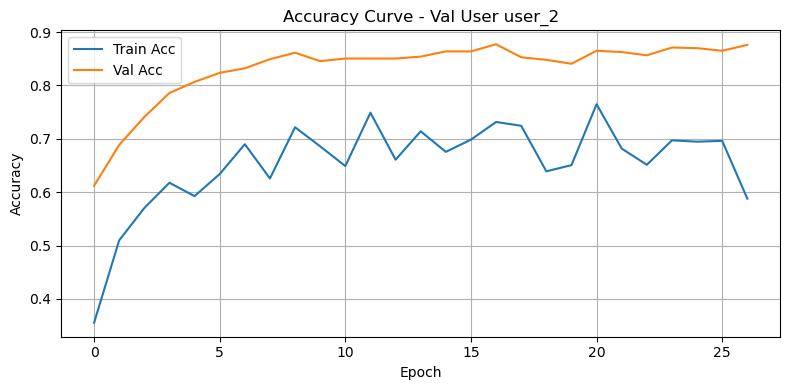

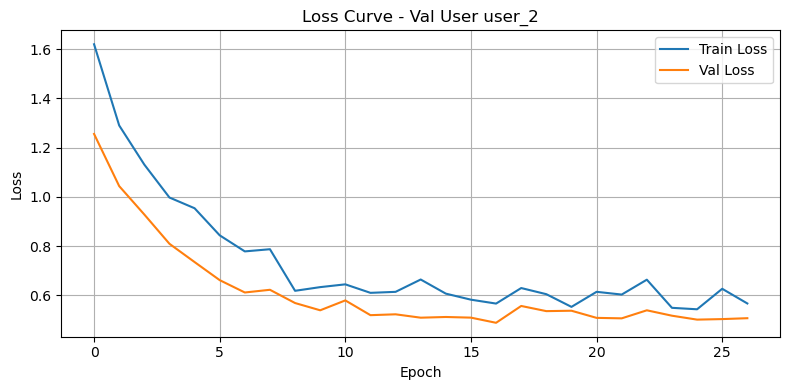

In [16]:
import os
# deterministic CUDA setup (if you want reproducibility); must come before torch import for cuBLAS
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

import re
import logging
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, recall_score, precision_score

# ====== CONFIGURATION ======
DATASET_ROOT = r'F:/Datasets/CSI-HAR-Dataset-Raspberry-Pi-4/CSI-HAR-Dataset'  # adjust if needed
ACTIVITIES = ['walk', 'run', 'fall', 'lie down', 'sitdown', 'standup', 'bend']
USERS = ['user_1', 'user_2', 'user_3']

TRAIN_USERS = ['user_1', 'user_3']
VAL_USER = 'user_2'

INPUT_DIM = 52
HIDDEN_DIM = 64
NUM_CLASSES = len(ACTIVITIES)
BATCH_SIZE = 64
EPOCHS = 150
PATIENCE = 10
LEARNING_RATE = 1e-4
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEED = 42
WINDOW_LEN = 400
STRIDE = 80

# ----- Replace / adjust these hyperparams -----
GAUSSIAN_SIGMA2 = 1e-4     # multiplicative noise variance from paper
SHIFT_STEP = 10            # fixed ±10 shift
MIXUP_ALPHA = 1.0          # paper's best alpha
MIXUP_PROB = 0.7           # reflection ratio: apply mixup with this probability
NOISE_COPIES = 3           # original + 3 noisy variants

# ----- New / replacement augmentation functions -----
def add_gaussian_noise_multiplicative(x, sigma2=GAUSSIAN_SIGMA2):
    """
    Multiplicative Gaussian noise: x + x * N(0, sigma2)
    x: tensor (B, T, C)
    """
    noise = torch.randn_like(x) * (sigma2 ** 0.5)
    return x + x * noise

def fixed_shift_augment_tensor(x, shift=SHIFT_STEP):
    # x: (T, C) torch tensor, returns tuple of (shifted_plus, shifted_minus)
    return torch.roll(x, shifts=shift, dims=0), torch.roll(x, shifts=-shift, dims=0)

def mixup_data(x, y, alpha=MIXUP_ALPHA):
    """
    Standard mixup. Returns mixed inputs, pair of targets, and lambda.
    """
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.0
    batch_size = x.size(0)
    if batch_size == 1:
        return x, y, y, lam
    index = torch.randperm(batch_size, device=x.device)
    x_shuffled = x[index]
    y_shuffled = y[index]
    mixed_x = lam * x + (1 - lam) * x_shuffled
    return mixed_x, y, y_shuffled, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

def augment_training_samples(window_label_pairs):
    """
    Expand training samples: original + multiplicative noise copies + fixed ±SHIFT_STEP shifts.
    Returns new list of (window, label) pairs.
    """
    augmented = []
    for arr, label in window_label_pairs:
        base = torch.tensor(arr, dtype=torch.float32)  # (W, C)
        # original
        augmented.append((arr, label))
        # multiplicative noise variants
        for _ in range(NOISE_COPIES):
            noisy = add_gaussian_noise_multiplicative(base.unsqueeze(0))  # (1, W, C)
            augmented.append((noisy[0].numpy(), label))
        # fixed shifts on original
        shift_p, shift_n = fixed_shift_augment_tensor(base)
        augmented.append((shift_p.numpy(), label))
        augmented.append((shift_n.numpy(), label))
    return augmented


# reproducibility
np.random.seed(SEED)
torch.manual_seed(SEED)
try:
    torch.use_deterministic_algorithms(True)
except Exception:
    pass
torch.backends.cudnn.benchmark = False

# logging
logging.basicConfig(
    level=logging.INFO,
    format='[%(asctime)s] %(levelname)s: %(message)s',
    datefmt='%H:%M:%S'
)
logger = logging.getLogger(__name__)



def load_windowed_data_by_user():
    """
    Returns dict: user -> list of (windowed_array, label_index)
    Each CSV file is normalized (per-column standardization) before windowing.
    Windows are created with stride and window length. No cross-file/global leakage.
    """
    user_windows = {u: [] for u in USERS}
    for activity in ACTIVITIES:
        logger.info(f"Loading activity '{activity}'")
        folder = os.path.join(DATASET_ROOT, activity)
        if not os.path.isdir(folder):
            logger.warning(f"Missing activity folder: {folder} (skipping '{activity}')")
            continue
        parts = activity.strip().split()
        if len(parts) > 1:
            activity_regex = r'[_ ]+'.join(re.escape(p) for p in parts)
        else:
            activity_regex = re.escape(activity)
        pattern = rf'^(user_\d+)_sample_\d+_{activity_regex}.*\.csv$'
        files = [f for f in os.listdir(folder)
                 if f.lower().endswith('.csv') and not f.lower().startswith('annotation')]
        for f in files:
            match = re.match(pattern, f, flags=re.IGNORECASE)
            if not match:
                continue
            user = match.group(1)
            if user not in USERS:
                continue
            label = ACTIVITIES.index(activity)
            full_path = os.path.join(folder, f)
            try:
                arr = pd.read_csv(full_path, header=None)
            except Exception as e:
                logger.warning(f"Failed to read '{full_path}': {e}")
                continue
            arr = arr.apply(pd.to_numeric, errors='coerce').values
            arr = arr[~np.isnan(arr).all(axis=1)]
            arr = arr[:, ~np.isnan(arr).all(axis=0)]
            if arr.shape[1] != INPUT_DIM:
                logger.debug(f"Skipping '{f}' due to unexpected dim {arr.shape}")
                continue
            if arr.shape[0] < WINDOW_LEN:
                continue  # too short for even one window

            # Per-file normalization (standardize each column independently)
            mean = np.nanmean(arr, axis=0, keepdims=True)
            std = np.nanstd(arr, axis=0, keepdims=True)
            std[std < 1e-6] = 1.0  # avoid division by zero
            arr = (arr - mean) / std  # shape (T, C)

            # Windowing
            n_windows = (arr.shape[0] - WINDOW_LEN) // STRIDE + 1
            for w in range(n_windows):
                start = w * STRIDE
                end = start + WINDOW_LEN
                if end > arr.shape[0]:
                    break
                window = arr[start:end, :]  # (WINDOW_LEN, INPUT_DIM)
                user_windows[user].append((window, label))
    return user_windows



class CSIDataset(Dataset):
    def __init__(self, window_label_pairs):
        if len(window_label_pairs) == 0:
            self.data = np.empty((0, 0, 0))
            self.labels = []
            logger.warning("[WARNING] Empty dataset initialized")
            return
        self.labels = [l for _, l in window_label_pairs]
        stack = np.stack([arr for arr, _ in window_label_pairs])  # (N, W, C)
        self.data = stack  # already normalized per-file
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32), self.labels[idx]


# ============== MODEL ===============
class CNNAttentionGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, cnn_channels=128, dropout=0.3):
        super().__init__()
        # CNN front-end: operate over (time, subcarrier) as a 2D “image”
        self.cnn = nn.Sequential(
            nn.Conv2d(1, cnn_channels, kernel_size=(3, 5), padding=(1, 2)),  # preserves T and C
            nn.ReLU(),
            nn.BatchNorm2d(cnn_channels),
            nn.MaxPool2d((1, 2))  # downsample subcarrier dimension by 2
        )
        # After conv+pool: shape (B, cnn_channels, T, input_dim//2)
        self.gru_input_dim = cnn_channels * (input_dim // 2)
        self.gru = nn.GRU(self.gru_input_dim, hidden_dim, batch_first=True)
        # attention layers (same as before)
        self.attn_query = nn.Linear(hidden_dim, hidden_dim)
        self.attn_key = nn.Linear(hidden_dim, hidden_dim)
        self.attn_value = nn.Linear(hidden_dim, hidden_dim)
        self.layer_norm = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        # x: (B, T, C) where C = original input_dim (subcarriers)
        B, T, C = x.shape
        x = x.unsqueeze(1)  # (B,1,T,C) so we can conv2d over time×subcarrier
        x = self.cnn(x)     # (B, F, T, C_new) where C_new = C//2
        B, F, T_new, C_new = x.shape
        # collapse feature maps into a sequence for GRU: (B, T_new, F * C_new)
        x = x.permute(0, 2, 1, 3).reshape(B, T_new, F * C_new)
        gru_out, _ = self.gru(x)  # (B, T_new, H)
        Q = self.attn_query(gru_out)
        K = self.attn_key(gru_out)
        V = self.attn_value(gru_out)
        attn_scores = torch.matmul(Q, K.transpose(1, 2)) / (Q.size(-1) ** 0.5)
        attn_weights = torch.softmax(attn_scores, dim=-1)
        attn_out = torch.matmul(attn_weights, V)  # (B, T_new, H)
        attn_out = self.layer_norm(attn_out + gru_out)
        attn_out = self.dropout(attn_out)
        pooled = attn_out.mean(dim=1)  # (B, H)
        logits = self.fc(pooled)
        return logits

# Evaluation helper
def evaluate(model, loader, criterion):
    model.eval()
    y_true, y_pred = [], []
    total_loss = 0.0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            out = model(xb)
            loss = criterion(out, yb)
            total_loss += loss.item() * xb.size(0)
            preds = out.argmax(dim=1).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(yb.cpu().numpy())
    avg_loss = total_loss / len(loader.dataset) if len(loader.dataset) > 0 else float('inf')
    accuracy = (np.array(y_true) == np.array(y_pred)).mean() if len(y_true) > 0 else 0.0
    return avg_loss, accuracy, y_true, y_pred

def augment_training_samples(samples):
    """
    Expand the training windows by applying shift and white noise augmentations
    per sample, keeping label the same. Does not do MixUp (that’s in-batch).
    """
    augmented = []
    for window, label in samples:
        augmented.append((window, label))  # original

        if USE_SHIFT:
            shift = np.random.randint(-MAX_SHIFT, MAX_SHIFT + 1)
            shifted = np.roll(window, shift, axis=0)
            augmented.append((shifted, label))

        if USE_WHITE_NOISE:
            signal_power = np.mean(window ** 2)
            snr = 10 ** (SNR_DB / 10)
            noise_power = signal_power / snr
            noise = np.random.normal(0, np.sqrt(noise_power), size=window.shape)
            noisy = window + noise
            augmented.append((noisy, label))

        if USE_SHIFT and USE_WHITE_NOISE:
            shift = np.random.randint(-MAX_SHIFT, MAX_SHIFT + 1)
            shifted = np.roll(window, shift, axis=0)
            signal_power = np.mean(shifted ** 2)
            snr = 10 ** (SNR_DB / 10)
            noise_power = signal_power / snr
            noise = np.random.normal(0, np.sqrt(noise_power), size=shifted.shape)
            shifted_noisy = shifted + noise
            augmented.append((shifted_noisy, label))

    return augmented


def main():
    logger.info("=== Starting main pipeline with paper-style augmentations ===")
    user_samples = load_windowed_data_by_user()

    # Build original train/val sets: train = TRAIN_USERS; val = VAL_USER
    train_samples = []
    for u in TRAIN_USERS:
        train_samples += user_samples.get(u, [])
    val_samples = user_samples.get(VAL_USER, [])

    if len(train_samples) == 0 or len(val_samples) == 0:
        logger.error(f"Empty base train or val samples (train: {len(train_samples)}, val: {len(val_samples)})")
        return

    # Expand train set via shift and noise augmentation (paper-style)
    expanded_train_samples = augment_training_samples(train_samples)
    logger.info(f"Train windows before augmentation: {len(train_samples)}; after augmentation: {len(expanded_train_samples)}")

    train_ds = CSIDataset(expanded_train_samples)
    val_ds = CSIDataset(val_samples)
    if len(train_ds) == 0 or len(val_ds) == 0:
        logger.error(f"Empty dataset after wrapping (train: {len(train_ds)}, val: {len(val_ds)}), aborting.")
        return

    logger.info(f"Number of train windows: {len(train_ds)}")
    logger.info(f"Number of val windows:   {len(val_ds)}")

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

    model = CNNAttentionGRU(INPUT_DIM, HIDDEN_DIM, NUM_CLASSES).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
    criterion = nn.CrossEntropyLoss()

    train_accs, val_accs, train_losses, val_losses = [], [], [], []
    best_val_loss = float('inf')
    best_epoch = 0
    patience_counter = 0
    best_model_state = None

    t0 = time.time()
    for epoch in range(1, EPOCHS + 1):
        model.train()
        epoch_loss = 0.0
        y_true_train, y_pred_train = [], []
        lam_accum = 0.0
        mixup_count = 0

        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)

            # In-batch MixUp application with probability
            apply_mix = USE_MIXUP and torch.rand(1).item() < MIXUP_PROB
            optimizer.zero_grad()

            if apply_mix:
                xb_mixed, y_a, y_b_shuffled, lam = mixup_data(xb, yb, MIXUP_ALPHA)
                out = model(xb_mixed)
                loss = mixup_criterion(criterion, out, y_a, y_b_shuffled, lam)
                lam_accum += lam
                mixup_count += 1
                preds = out.argmax(dim=1)
                # for proxy accuracy compare to original yb
                y_pred_train.extend(preds.cpu().numpy())
                y_true_train.extend(yb.cpu().numpy())
            else:
                # no MixUp: apply shift and noise augmentation on-the-fly if desired (optional)
                out = model(xb)
                loss = criterion(out, yb)
                preds = out.argmax(dim=1)
                y_pred_train.extend(preds.cpu().numpy())
                y_true_train.extend(yb.cpu().numpy())

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * xb.size(0)

        train_loss = epoch_loss / len(train_ds)
        train_acc = (np.array(y_true_train) == np.array(y_pred_train)).mean()

        val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]['lr']

        mixup_info = ""
        if USE_MIXUP and mixup_count > 0:
            avg_lam = lam_accum / mixup_count
            mixup_info = f" | MixUp λ(avg): {avg_lam:.3f}"
        mixup_note = " (proxy)" if USE_MIXUP else ""

        logger.info(
            f"Epoch {epoch:02d}/{EPOCHS} | "
            f"Train Loss: {train_loss:.4f} | Train Acc{mixup_note}: {train_acc*100:.2f}% | "
            f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}% | LR: {current_lr:.1e}"
            + mixup_info
        )

        if val_loss < best_val_loss - 1e-5:
            best_val_loss = val_loss
            best_epoch = epoch
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                logger.info(f"Early stopping triggered at epoch {epoch}.")
                break

    elapsed = time.time() - t0
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    # Final evaluation
    val_loss, val_acc, y_true, y_pred = evaluate(model, val_loader, criterion)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_true, y_pred, average='macro', zero_division=0)
    prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
    acc = val_acc

    logger.info("\n--- Final Evaluation ---")
    logger.info(f"Best epoch: {best_epoch} (best val loss: {best_val_loss:.4f})")
    logger.info(classification_report(y_true, y_pred, target_names=ACTIVITIES, digits=3))
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=ACTIVITIES)
    disp.plot(xticks_rotation='vertical')
    plt.title(f'Confusion Matrix - Val User {VAL_USER}')
    plt.tight_layout()
    plt.show()

    logger.info(f'Final metrics: accuracy={acc:.4f}, f1={f1:.4f}, recall={rec:.4f}, precision={prec:.4f}')
    logger.info(f'Training time: {elapsed:.1f} seconds')

    # Curves
    plt.figure(figsize=(8, 4))
    plt.plot(train_accs, label='Train Acc')
    plt.plot(val_accs, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy Curve - Val User {VAL_USER}')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 4))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Loss Curve - Val User {VAL_USER}')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

    return {
        "results": [{
            "user_left_out": VAL_USER,
            "accuracy": acc,
            "f1": f1,
            "recall": rec,
            "precision": prec,
            "train_time": elapsed,
            "best_epoch": best_epoch
        }],
        "model": model,
        "best_epoch": best_epoch,
        "metrics": {
            "accuracy": acc,
            "f1": f1,
            "recall": rec,
            "precision": prec
        },
        "y_true": y_true,
        "y_pred": y_pred
    }

summary = main()


==== LEAVE-ONE-USER-OUT RESULTS SUMMARY ====


,accuracy,f1,recall,precision,train_time,best_epoch
user_left_out,,,,,,
user_2,0.875912,0.868172,0.869318,0.884117,6568.19904,17



==== MEAN METRICS ====
      accuracy        f1    recall  precision  train_time
mean  0.875912  0.868172  0.869318   0.884117  6568.19904

==== MEAN ± STD ====
      accuracy        f1    recall  precision
mean  0.875912  0.868172  0.869318   0.884117
std        NaN       NaN       NaN        NaN

==== MODEL ARCHITECTURE ====
CNNAttentionGRU(
  (cnn): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 5), stride=(1, 1), padding=(1, 2))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (gru): GRU(3328, 64, batch_first=True)
  (attn_query): Linear(in_features=64, out_features=64, bias=True)
  (attn_key): Linear(in_features=64, out_features=64, bias=True)
  (attn_value): Linear(in_features=64, out_features=64, bias=True)
  (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.3, inplace=False)
 

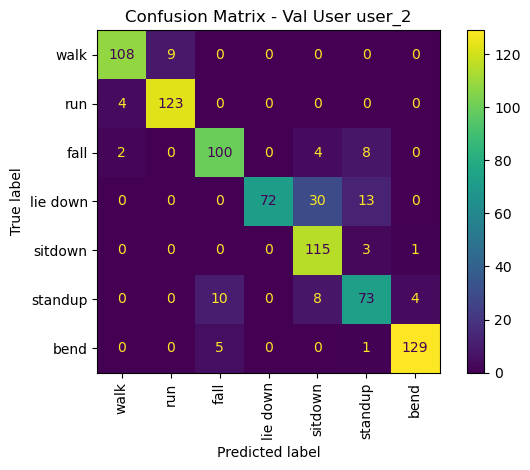

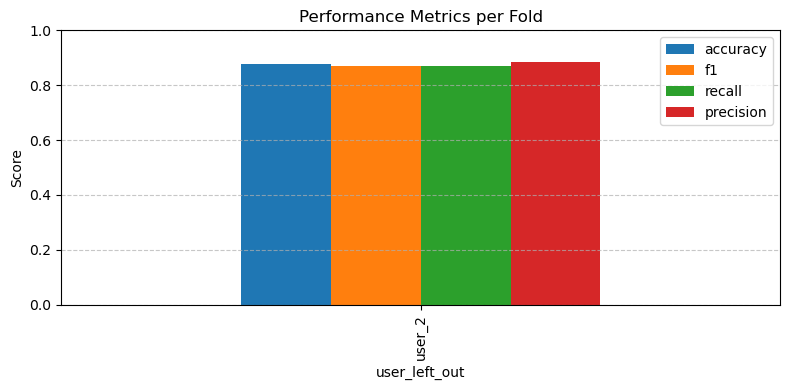

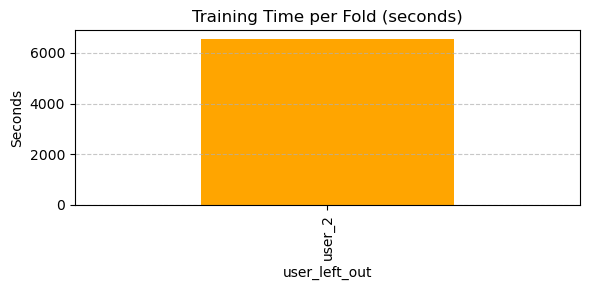

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# --- extract results ---
if 'summary' in globals() and isinstance(summary, dict):
    results = summary.get("results", [])
else:
    # fallback to legacy variables if summary not present
    try:
        results = [{
            "user_left_out": VAL_USER,
            "accuracy": acc,
            "f1": f1,
            "recall": rec,
            "precision": prec,
            "train_time": elapsed,
            "best_epoch": best_epoch
        }]
    except NameError as e:
        raise RuntimeError(f"Cannot build summary: missing variable {e}. Ensure summary or required metrics are in scope.")

# Build DataFrame
df = pd.DataFrame(results)
if "user_left_out" in df.columns:
    df.set_index("user_left_out", inplace=True)

# --- Summary tables ---
print("==== LEAVE-ONE-USER-OUT RESULTS SUMMARY ====")
display(df[['accuracy', 'f1', 'recall', 'precision', 'train_time', 'best_epoch']])

print("\n==== MEAN METRICS ====")
mean_metrics = df[['accuracy', 'f1', 'recall', 'precision', 'train_time']].mean()
print(mean_metrics.to_frame(name="mean").T)

print("\n==== MEAN ± STD ====")
agg = df[['accuracy', 'f1', 'recall', 'precision']].agg(['mean', 'std'])
print(agg)

# --- Model architecture & size ---
print("\n==== MODEL ARCHITECTURE ====")
model_obj = None
if 'summary' in globals():
    model_obj = summary.get('model', None)
if model_obj is None:
    model_obj = globals().get('model', None)
if model_obj is not None:
    print(model_obj)
    try:
        n_params = sum(p.numel() for p in model_obj.parameters())
        print(f"\nTotal parameters: {n_params:,}")
    except Exception:
        pass
else:
    print("Model object not found in scope.")

# --- Classification report & confusion matrix ---
# Prefer summary's y_true/y_pred then globals
y_true = None; y_pred = None
if 'summary' in globals():
    y_true = summary.get("y_true", None)
    y_pred = summary.get("y_pred", None)
if y_true is None or y_pred is None:
    y_true = globals().get('y_true', y_true)
    y_pred = globals().get('y_pred', y_pred)

if y_true is not None and y_pred is not None:
    print("\n==== CLASSIFICATION REPORT ====")
    print(classification_report(y_true, y_pred, target_names=ACTIVITIES, digits=3, zero_division=0))
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=ACTIVITIES)
    disp.plot(xticks_rotation='vertical')
    plt.title(f'Confusion Matrix - Val User {VAL_USER}')
    plt.tight_layout()
    plt.show()
else:
    print("\nNo prediction targets available; skipping classification report/confusion matrix.")

# --- Plots ---
fig, ax = plt.subplots(figsize=(8, 4))
df[['accuracy', 'f1', 'recall', 'precision']].plot(kind='bar', ax=ax)
ax.set_title("Performance Metrics per Fold")
ax.set_ylabel("Score")
ax.set_ylim(0, 1)
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 3))
if 'train_time' in df.columns:
    df['train_time'].plot(kind='bar', color='orange')
    plt.title("Training Time per Fold (seconds)")
    plt.ylabel("Seconds")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("\nNo 'train_time' column to plot.")
